<a href="https://colab.research.google.com/github/ristaardy/econ8030_fluctuations/blob/main/ECON8030_Group_Project_2_Fluctuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1: CROSS-COUNTRY BUSINESS CYCLE ANALYSIS

## 1.1 Library Import & Data Preparation

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.filters.hp_filter import hpfilter

In [ ]:
# Reading the dataset from Sheet1
sheet_url = "https://docs.google.com/spreadsheets/d/1Ay88UGsG3ApByM6i2KC56v9l3qNIzEFUIfvzpjcGJ80/edit?gid=0#gid=0"                      # Paste your data link here
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")                                                             # Convert the link to a CSV format readable in Google Colab
df = pd.read_csv(csv_export_url)                                                                                                        # Load the data into a DataFrame
df.head()

DATE COUNTRY  GDP_USD  GDP_NC  UNEMPLOY  SHARE_PRICE  L_INTEREST_RT  \
0  1914Q1     CAN      NaN     NaN       NaN          NaN            NaN   
1  1914Q2     CAN      NaN     NaN       NaN          NaN            NaN   
2  1914Q3     CAN      NaN     NaN       NaN          NaN            NaN   
3  1914Q4     CAN      NaN     NaN       NaN          NaN            NaN   
4  1915Q1     CAN      NaN     NaN       NaN          NaN            NaN   

   S_INTEREST_RT    CPI_QQ       CPI  GFCF_USD  GFCF_NC  CONS_USD  CONS_NC  
0            NaN       NaN  4.740585       NaN      NaN       NaN      NaN  
1            NaN -0.555560  4.714248       NaN      NaN       NaN      NaN  
2            NaN  0.000000  4.714248       NaN      NaN       NaN      NaN  
3            NaN  2.234637  4.819594       NaN      NaN       NaN      NaN  
4            NaN  0.000000  4.819594       NaN      NaN       NaN      NaN

In [ ]:
# CRITICAL STEP: Convert the 'DATE' column to a PeriodIndex BEFORE setting it as the index
# This ensures Matplotlib handles quarterly data correctly.
df['DATE'] = pd.PeriodIndex(df['DATE'], freq='Q')

# Convert DATE to PeriodIndex and set a MultiIndex
df = df.set_index(['DATE', 'COUNTRY'])
df.head()

GDP_USD  GDP_NC  UNEMPLOY  SHARE_PRICE  L_INTEREST_RT  \
DATE   COUNTRY                                                          
1914Q1 CAN          NaN     NaN       NaN          NaN            NaN   
1914Q2 CAN          NaN     NaN       NaN          NaN            NaN   
1914Q3 CAN          NaN     NaN       NaN          NaN            NaN   
1914Q4 CAN          NaN     NaN       NaN          NaN            NaN   
1915Q1 CAN          NaN     NaN       NaN          NaN            NaN   

                S_INTEREST_RT    CPI_QQ       CPI  GFCF_USD  GFCF_NC  \
DATE   COUNTRY                                                         
1914Q1 CAN                NaN       NaN  4.740585       NaN      NaN   
1914Q2 CAN                NaN -0.555560  4.714248       NaN      NaN   
1914Q3 CAN                NaN  0.000000  4.714248       NaN      NaN   
1914Q4 CAN                NaN  2.234637  4.819594       NaN      NaN   
1915Q1 CAN                NaN  0.000000  4.819594       NaN      NaN   

                CONS_USD  CONS_NC  
DATE   COUNTRY                     
1914Q1 CAN           NaN      NaN  
1914Q2 CAN           NaN      NaN  
1914Q3 CAN           NaN      NaN  
1914Q4 CAN           NaN      NaN  
1915Q1 CAN           NaN      NaN

## 1.2 Data Cleaning & Filtering

In [ ]:
# --- Settings ---
TARGET_COUNTRIES = ['USA', 'UK', 'CAN']  # Countries for Task 1 analysis
START_DATE = '1994Q1'  # Start of the raw data range
END_DATE = '2025Q2'     # End of the consistent data range
LAMBDA = 1600          # Hodrick-Prescott (HP) smoothing parameter for quarterly data

# Variables to be used in the analysis
# LCU variables (to be Log-transformed and HP-Filtered)
VARS_HP = ['GDP_NC', 'GFCF_NC', 'CONS_NC', 'SHARE_PRICE']
# Ratio/Rate variables (used directly or for simple calculation)
VARS_RATIO = ['UNEMPLOY', 'L_INTEREST_RT', 'S_INTEREST_RT', 'CPI']
ALL_VARS = VARS_HP + VARS_RATIO

# 1. Filter Target Countries and select the necessary variables
# Locates data for the TARGET_COUNTRIES across all time periods
df_part1 = df.loc[(slice(None), TARGET_COUNTRIES), ALL_VARS]

# 2. Sort the MultiIndex (CRITICAL for efficient slicing)
# Sorts by DATE (Level 0) then COUNTRY (Level 1)
df_part1 = df_part1.sort_index()

# 3. Filter the Consistent Time Range
# Slices the DataFrame using the PeriodIndex start and end dates
df_filtered = df_part1.loc[(slice(START_DATE, END_DATE), slice(None)), :].copy()  # add copy here to avoid warning from pandas

print(f"DataFrame successfully filtered for {TARGET_COUNTRIES}.")
print(f"Consistent time range: {df_filtered.index.get_level_values('DATE').min()} - {df_filtered.index.get_level_values('DATE').max()}")
print(f"Total observations: {len(df_filtered)}")

DataFrame successfully filtered for ['USA', 'UK', 'CAN'].
Consistent time range: 1994Q1 - 2025Q2
Total observations: 378


## 1.3 Logaritmic Transformation & Inflation

In [ ]:
# A. Logarithmic Transformation
VARS_HP = ['GDP_NC', 'GFCF_NC', 'CONS_NC', 'SHARE_PRICE']
for var in VARS_HP:
    # Create new columns: Log Level (with '_L' suffix)
    # Using .loc to prevent Pandas' SettingWithCopyWarning
    df_filtered.loc[:, f'{var}_L'] = np.log(df_filtered[var])

# B. Calculate Annualized QoQ Inflation (from CPI Level)
def calculate_inflation(series):
    # Use shift(1) to get the previous quarter's CPI value per country
    log_diff = np.log(series) - np.log(series.shift(1))
    # Multiply by 400 for Annualized QoQ Percentage
    return log_diff * 400

# .transform() returns a result with the exact same shape as the input
# This prevents MultiIndex errors when applying the calculation by group
df_filtered.loc[:, 'Inflation_QoQ'] = df_filtered.groupby(level='COUNTRY')['CPI'].transform(calculate_inflation)

# Slice the DataFrame to the final clean analysis range (1995Q1-2025Q2)
START_DATE_FINAL = '1995Q1'
END_DATE = '2025Q2'
# This slice removes the initial NaN rows created by the shift operation
df_transformed = df_filtered.loc[(slice(START_DATE_FINAL, END_DATE), slice(None)), :]

print("\n--- Logarithmic Transformation & Inflation Complete ---")
print(f"Total observations after transformation: {len(df_transformed)}")


--- Logarithmic Transformation & Inflation Complete ---
Total observations after transformation: 366


In [ ]:
df_transformed.head()

GDP_NC   GFCF_NC    CONS_NC  SHARE_PRICE  UNEMPLOY  \
DATE   COUNTRY                                                          
1995Q1 CAN       314818.8   58490.5   157990.0     28.95558  9.633333   
       UK        402390.0   66753.0   239757.0     46.29012  8.900000   
       USA      2829988.0  507046.8  1807758.0     25.82185  5.466667   
1995Q2 CAN       314952.5   58352.5   159204.8     30.81381  9.500000   
       UK        403259.0   66884.0   241450.0     49.72734  8.700000   

                L_INTEREST_RT  S_INTEREST_RT       CPI   GDP_NC_L  GFCF_NC_L  \
DATE   COUNTRY                                                                 
1995Q1 CAN           8.964399       8.090261  68.68581  12.659753  10.976620   
       UK            8.661467       6.722410  65.70000  12.905177  11.108755   
       USA           7.483333       6.183333  63.65226  14.855783  13.136359   
1995Q2 CAN           8.111826       7.585837  69.23888  12.660177  10.974257   
       UK            8.242567       6.742444  66.70000  12.907334  11.110715   

                CONS_NC_L  SHARE_PRICE_L  Inflation_QoQ  
DATE   COUNTRY                                           
1995Q1 CAN      11.970287       3.365763       4.007793  
       UK       12.387381       3.834929       2.442756  
       USA      14.407598       3.251221       3.283457  
1995Q2 CAN      11.977947       3.427963       3.207971  
       UK       12.394418       3.906555       6.042411

## 1.4 Detrending (Hodrick-Prescott Filter)

In [ ]:
# List to store the cyclical components
cycle_results = pd.DataFrame()
LAMBDA = 1600 # HP smoothing parameter for quarterly data

# Variables that will be HP-Filtered (Log Levels)
VARS_HP = ['GDP_NC', 'GFCF_NC', 'CONS_NC', 'SHARE_PRICE']
VARS_TO_CYCLE = [f'{var}_L' for var in VARS_HP]

# Iterate and Apply HP Filter for each country
for country in df_transformed.index.get_level_values('COUNTRY').unique():
    # Retrieve data for the specific country
    # Using .loc[(slice(None), country), :] ensures we only select one country's time series
    df_country = df_transformed.loc[(slice(None), country), :].copy()

    # Detrending on Log Level variables
    for var_log in VARS_TO_CYCLE:
        # Call hpfilter. It returns (cycle, trend). We take the cycle component [0]
        # Multiply by 100 to express the cycle in % deviation from trend (Output Gap)
        df_country[f'{var_log}_Cycle'] = hpfilter(df_country[var_log], lamb=LAMBDA)[0] * 100

    # Combine the cyclical results back into the main DataFrame
    cycle_results = pd.concat([cycle_results, df_country])

# Select the final columns required for the analysis (Step 4)
# This includes the new cycles and the non-HP-filtered ratios (UNEMPLOY, Inflation, Rates)
FINAL_COLUMNS = [f'{var}_L_Cycle' for var in VARS_HP] + ['UNEMPLOY', 'L_INTEREST_RT', 'S_INTEREST_RT', 'Inflation_QoQ']

# This DataFrame now contains all your cyclical signals (366 rows)
df_cycle_analysis = cycle_results.loc[:, FINAL_COLUMNS]

print("\n--- HP Filter Detrending Complete ---")
print("New cycle columns added:")
print(df_cycle_analysis.head())


--- HP Filter Detrending Complete ---
New cycle columns added:
                GDP_NC_L_Cycle  GFCF_NC_L_Cycle  CONS_NC_L_Cycle  \
DATE   COUNTRY                                                     
1995Q1 CAN            2.057544         1.595537         0.289148   
1995Q2 CAN            1.203290        -0.230935         0.159700   
1995Q3 CAN            0.437381        -2.064116         0.348932   
1995Q4 CAN           -0.061196        -3.177369        -0.509106   
1996Q1 CAN           -0.823145        -2.592915        -0.048324   

                SHARE_PRICE_L_Cycle  UNEMPLOY  L_INTEREST_RT  S_INTEREST_RT  \
DATE   COUNTRY                                                                
1995Q1 CAN                -7.260746  9.633333       8.964399       8.090261   
1995Q2 CAN                -4.429663  9.500000       8.111826       7.585837   
1995Q3 CAN                -4.795308  9.433333       8.089530       6.646773   
1995Q4 CAN                -6.913954  9.300000       7.481412    

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires 

## 1.5 Statistical Analysis

In [ ]:
# Statistical Analysis (Volatility & Correlation)
# VARS_HP = ['GDP_NC', 'GFCF_NC', 'CONS_NC', 'SHARE_PRICE'] (From Initial Setup)
VARS_RATIO = ['UNEMPLOY', 'L_INTEREST_RT', 'S_INTEREST_RT']

# Create the correct Cycle Columns List ---
# Must capture the exact column names from Step 3 (original name + '_L_Cycle')
VARS_CYCLE_CORRECT = [f'{var}_L_Cycle' for var in VARS_HP if var != 'SHARE_PRICE']
# Handle SHARE_PRICE separately as it did not have the '_NC' suffix before logging
VARS_CYCLE_CORRECT.append('SHARE_PRICE_L_Cycle')

# List of all cyclical variables ready for analysis
# Combine the correct HP-filtered cycle columns and the ratio variables
ALL_CYCLE_VARS = VARS_CYCLE_CORRECT + VARS_RATIO + ['Inflation_QoQ']

# Group by country
grouped = cycle_results.groupby(level='COUNTRY')

# --- A. Volatility (Standard Deviation) ---
# Calculate the Standard Deviation for all cyclical variables
std_dev = grouped[ALL_CYCLE_VARS].std()

# Calculate Relative Volatility (divided by GDP Cycle STD Dev)
# The reference column is GDP_NC_L_Cycle
std_relatif = std_dev.div(std_dev['GDP_NC_L_Cycle'], axis=0).round(2)
print("\n--- TABLE A: Relative Volatility (vs. GDP Cycle) ---")
print("Value > 1.0 means the variable is more volatile than GDP.")
print(std_relatif)

# --- B. Correlation (with GDP_Cycle) ---
GDP_CYCLE_COL = 'GDP_NC_L_Cycle'
correlation_results = {}

for country in TARGET_COUNTRIES:
    df_country = grouped.get_group(country)
    # Calculate the correlation of every column against the GDP_CYCLE_COL
    corrs = df_country[ALL_CYCLE_VARS].corr()[GDP_CYCLE_COL].round(2)
    correlation_results[country] = corrs

# Convert the dictionary results to a clean DataFrame
correlation_final = pd.DataFrame(correlation_results)

print("\n--- TABLE B: Correlation Coefficients ---")
print("Value > 0: Procyclical, Value < 0: Countercyclical.")
print(correlation_final)


--- TABLE A: Relative Volatility (vs. GDP Cycle) ---
Value > 1.0 means the variable is more volatile than GDP.
         GDP_NC_L_Cycle  GFCF_NC_L_Cycle  CONS_NC_L_Cycle  \
COUNTRY                                                     
CAN                 1.0             2.14             1.12   
UK                  1.0             1.48             1.21   
USA                 1.0             2.38             1.05   

         SHARE_PRICE_L_Cycle  UNEMPLOY  L_INTEREST_RT  S_INTEREST_RT  \
COUNTRY                                                                
CAN                     6.13      0.77           1.13           1.16   
UK                      3.66      0.56           0.78           0.97   
USA                     7.95      1.39           1.21           1.72   

         Inflation_QoQ  
COUNTRY                 
CAN               1.45  
UK                0.92  
USA               2.09  

--- TABLE B: Correlation Coefficients ---
Value > 0: Procyclical, Value < 0: Countercyclical.
 

In [ ]:
from IPython.display import display, Markdown

# 1. Display TABLE A (Relative Volatility)
print("--- TABLE A: Relative Volatility (vs. GDP Cycle) ---")
# Add a title above the table (Optional, but clean)
display(Markdown("**Relative Volatility ($\sigma_x / \sigma_{GDP}$)**"))

# Use display() to trigger the clean HTML/Formatted Pandas table output
display(std_relatif)

# 2. Display TABLE B (Correlation)
print("\n--- TABLE B: Correlation Coefficients (with GDP Cycle) ---")
display(Markdown("**Correlation Coefficient ($\rho_{x, GDP}$)**"))
display(correlation_final)

--- TABLE A: Relative Volatility (vs. GDP Cycle) ---


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2725962750.py:6: SyntaxWarning: invalid escape sequence '\s'
  display(Markdown("**Relative Volatility ($\sigma_x / \sigma_{GDP}$)**"))


**Relative Volatility ($\sigma_x / \sigma_{GDP}$)**

GDP_NC_L_Cycle  GFCF_NC_L_Cycle  CONS_NC_L_Cycle  \
COUNTRY                                                     
CAN                 1.0             2.14             1.12   
UK                  1.0             1.48             1.21   
USA                 1.0             2.38             1.05   

         SHARE_PRICE_L_Cycle  UNEMPLOY  L_INTEREST_RT  S_INTEREST_RT  \
COUNTRY                                                                
CAN                     6.13      0.77           1.13           1.16   
UK                      3.66      0.56           0.78           0.97   
USA                     7.95      1.39           1.21           1.72   

         Inflation_QoQ  
COUNTRY                 
CAN               1.45  
UK                0.92  
USA               2.09


--- TABLE B: Correlation Coefficients (with GDP Cycle) ---


**Correlation Coefficient ($ho_{x, GDP}$)**

USA    UK   CAN
GDP_NC_L_Cycle       1.00  1.00  1.00
GFCF_NC_L_Cycle      0.80  0.79  0.66
CONS_NC_L_Cycle      0.90  0.96  0.87
SHARE_PRICE_L_Cycle  0.67  0.45  0.42
UNEMPLOY            -0.67 -0.19 -0.73
L_INTEREST_RT        0.19  0.10  0.13
S_INTEREST_RT        0.38  0.17  0.30
Inflation_QoQ        0.24  0.20  0.22

## 1.6 Graphs

### 1.6.1 GDP Cycle

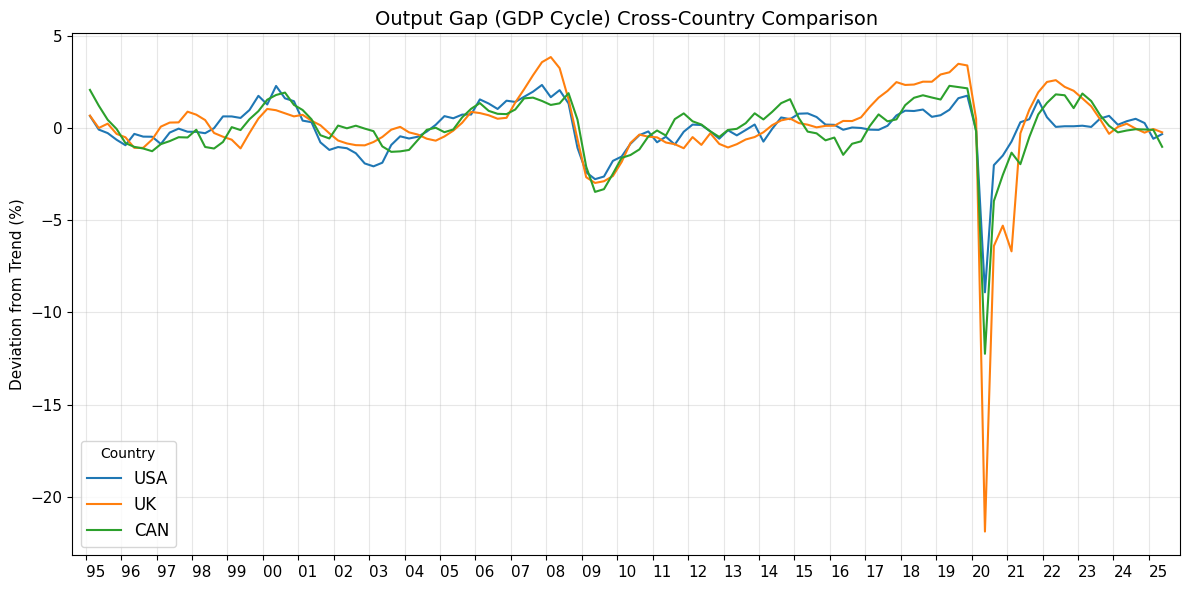

In [ ]:
# --- 1. Data Preparation (Mandatory) ---
# Unstack the GDP Cycle column by country (preparing for plot)
gdp_cycle_df = cycle_results['GDP_NC_L_Cycle'].unstack(level='COUNTRY')

# Convert the Index (PeriodIndex) to DateTimeIndex (Timestamp) - Required by Matplotlib
gdp_cycle_df.index = gdp_cycle_df.index.to_timestamp(freq='Q', how='end')


# --- 2. Comparative Plotting ---
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the GDP Cycle data for the three countries
# marker='o' is commented out, keeping linewidth 1.5
gdp_cycle_df[['USA', 'UK', 'CAN']].plot(
    ax=ax,
    # marker='o',
    markersize=1.5,
    linewidth=1.5
)

# A. Set X-axis Limits (plt.xlim)
# Convert integer years to datetime objects for accurate boundary setting
start_limit = pd.to_datetime('1994-10-01')  # End of 1994 / Start of 1995
end_limit = pd.to_datetime('2026-01-01')
ax.set_xlim(start_limit, end_limit)  # Apply xlim to the correct Axes object

# B. Set Tick Positions (plt.xticks)
# Create a list of tick positions for every year
tick_years = np.arange(1995, 2026, 1)

# Convert integer years to datetime (e.g., set to Feb 15th for central placement)
tick_positions = [pd.to_datetime(f'{year}-02-15') for year in tick_years]
# Create two-digit year labels (e.g., '95' from 1995)
tick_labels = [str(year)[2:] for year in tick_years]

# Apply the custom xticks (datetime objects)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='left', fontsize=11)

# C. Adjust Y-axis Ticks
# Change yticks font size to 11
ax.tick_params(axis='y', labelsize=11)

# --- 4. Finalize Graph ---
ax.set_title('Output Gap (GDP Cycle) Cross-Country Comparison', fontsize=14)
ax.set_ylabel('Deviation from Trend (%)', fontsize=11)
ax.set_xlabel('') # Remove X-axis label by setting it to an empty string
ax.legend(title='Country', loc='lower left', fontsize=12)
ax.grid(True, which='major', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

### 1.6.2 USA

#### Each Vars

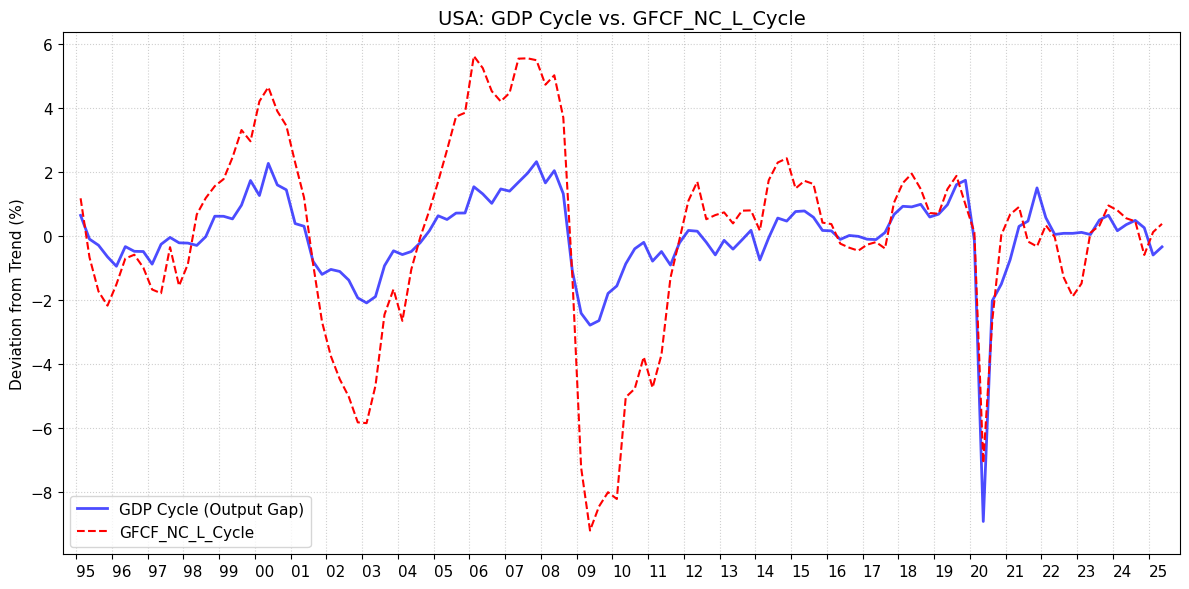

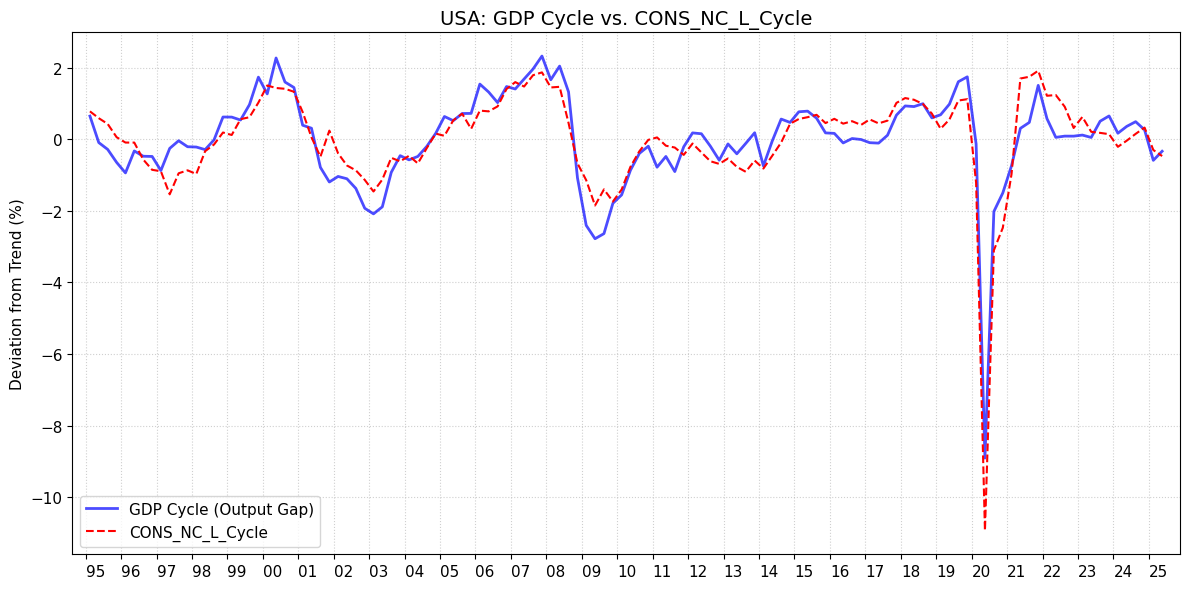

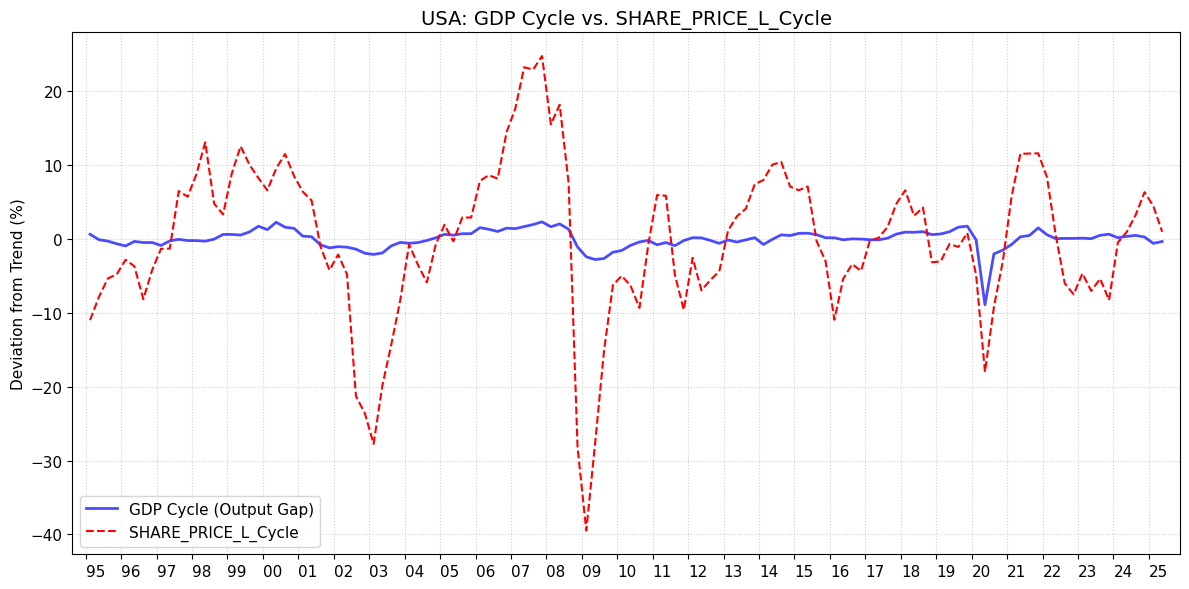

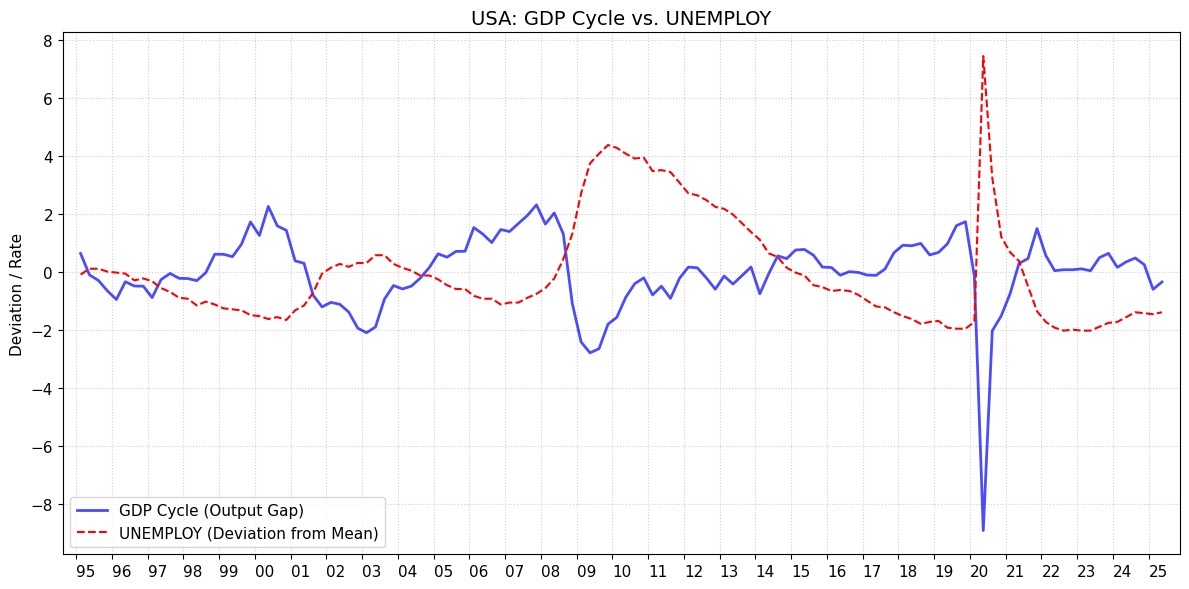

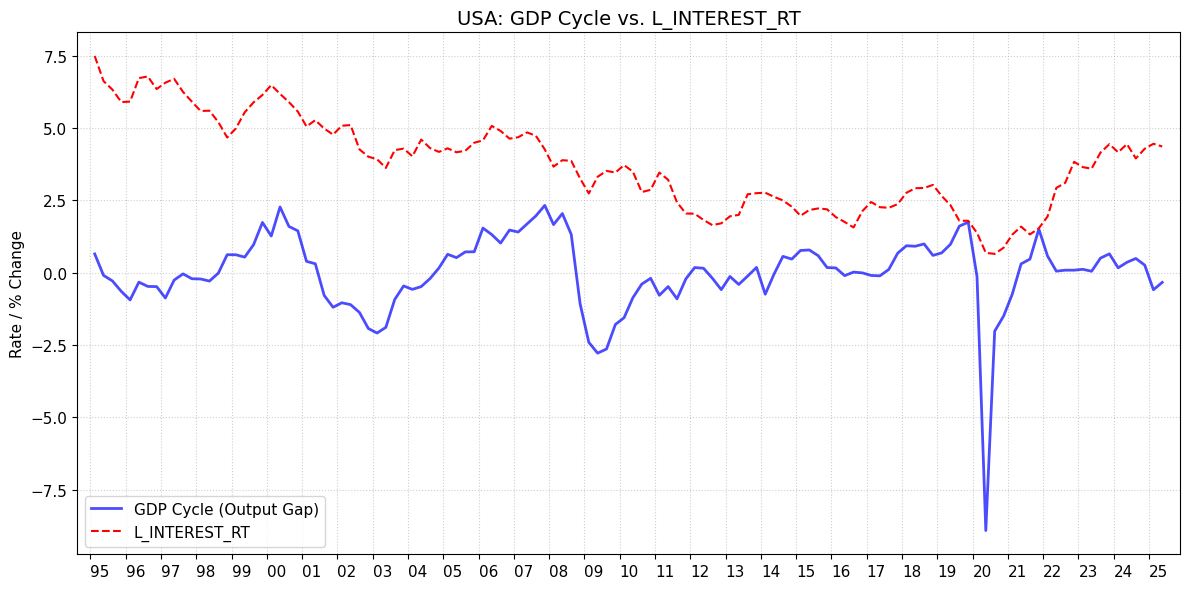

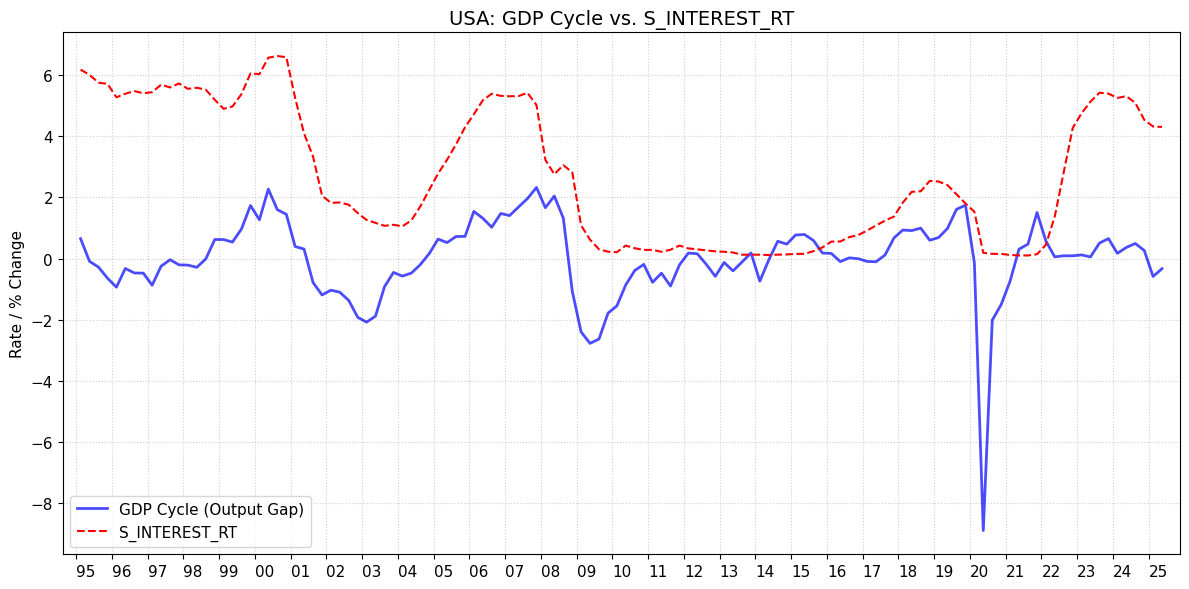

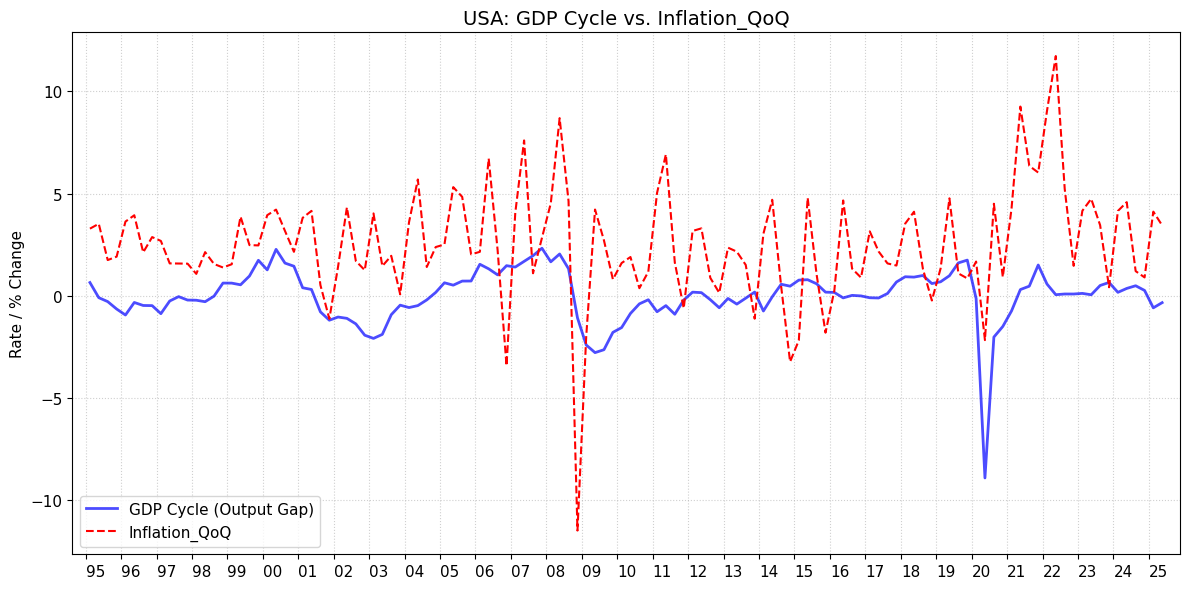

In [ ]:
# Filter data exclusively for the USA
df_usa = cycle_results.loc[(slice(None), 'USA'), :].droplevel(level='COUNTRY').copy()

# CRITICAL: Convert the PeriodIndex (DATE) to a Plottable DateTimeIndex
df_usa['Timestamp'] = df_usa.index.to_timestamp(freq='Q', how='end')

# --- Variables to be Plotted against the GDP Cycle ---
VARS_HP_CYCLES = ['GFCF_NC_L_Cycle', 'CONS_NC_L_Cycle', 'SHARE_PRICE_L_Cycle']
VARS_RATIO_CYCLES = ['UNEMPLOY', 'L_INTEREST_RT', 'S_INTEREST_RT', 'Inflation_QoQ']
COMPARE_VARS = VARS_HP_CYCLES + VARS_RATIO_CYCLES
GDP_CYCLE_COL = 'GDP_NC_L_Cycle'

# --- LOOP PLOTTING ---
for variable in COMPARE_VARS:
    # 1. Create a new Figure and get the Axes object (ax)
    fig, ax = plt.subplots(figsize=(12, 6))

    # 2. Plot the GDP Cycle (Reference Line)
    ax.plot(df_usa['Timestamp'], df_usa[GDP_CYCLE_COL],
             label='GDP Cycle (Output Gap)', color='blue', linewidth=2, alpha=0.7)

    # 3. Plot the Other Variable
    if variable == 'UNEMPLOY':
        # Unemployment Rate: Plot as Deviation from Mean (Cyclical component)
        ax.plot(df_usa['Timestamp'], df_usa[variable] - df_usa[variable].mean(),
                 label=f'{variable} (Deviation from Mean)', color='red', linestyle='--', linewidth=1.5)
        ax.set_ylabel('Deviation / Rate', fontsize=11)
    else:
        # All other Procyclical/Ratio variables
        ax.plot(df_usa['Timestamp'], df_usa[variable],
                 label=f'{variable}', color='red', linestyle='--', linewidth=1.5)

        # Adjust Y-axis label based on variable type
        if variable in VARS_HP_CYCLES:
             ax.set_ylabel('Deviation from Trend (%)', fontsize=11)
        else:
             ax.set_ylabel('Rate / % Change', fontsize=11)

    # --- X-Axis Customization ---
    # Set X-axis Limits (xlim)
    start_limit = pd.to_datetime('1994-10-01')  # End of 1994 / Start of 1995
    end_limit = pd.to_datetime('2026-01-01')
    ax.set_xlim(start_limit, end_limit)

    # Set Tick Positions (xticks)
    tick_years = np.arange(1995, 2026, 1)  # Ticks for every year
    tick_positions = [pd.to_datetime(f'{year}-02-15') for year in tick_years]
    tick_labels = [str(year)[2:] for year in tick_years]  # Two-digit year labels (e.g., '95')

    # Apply xticks to the correct Axes object
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, ha='left', fontsize=11)

    # Adjust Y-axis ticks font size
    ax.tick_params(axis='y', labelsize=11)

    # 4. Finalize Graph and Display
    ax.set_title(f'USA: GDP Cycle vs. {variable}', fontsize=14)
    ax.set_xlabel('')  # Remove X-axis label
    ax.legend(loc='lower left', fontsize=11)
    ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()
    print()

#### Combined Vars

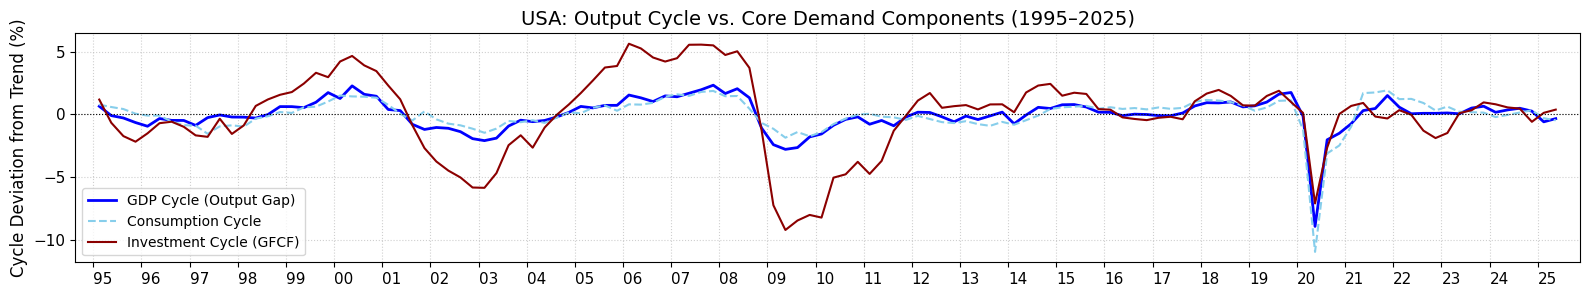

In [ ]:
# Assuming df_usa is defined, and common parameters are set (start_limit, end_limit, etc.)

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle', 'CONS_NC_L_Cycle']
RIGHT_VARS = ['GFCF_NC_L_Cycle'] # Variables moved to the primary axis

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- PRIMARY AXIS (LEFT): GDP, Consumption, and Investment Cycles ---
ax1.set_xlabel('Year', fontsize=12)
# Set Y-label to reflect that all lines are now cycles (deviation from trend)
ax1.set_ylabel('Cycle Deviation from Trend (%)', fontsize=12)

# Plot GDP Cycle (Anchor)
ax1.plot(df_usa['Timestamp'], df_usa['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)
# Plot Consumption Cycle
ax1.plot(df_usa['Timestamp'], df_usa['CONS_NC_L_Cycle'],
         label='Consumption Cycle', color='skyblue', linestyle='--', linewidth=1.5)

# Plot Investment Cycle (GFCF) - Moved from Secondary Axis (ax2) to Primary Axis (ax1)
ax1.plot(df_usa['Timestamp'], df_usa['GFCF_NC_L_Cycle'],
         label='Investment Cycle (GFCF)', color='darkred', linestyle='-', linewidth=1.5)

ax1.tick_params(axis='y', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the single Axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11)
ax1.grid(True, linestyle=':', alpha=0.6)

# Legend moved to lower left as requested
ax1.legend(loc='lower left', fontsize=10)

ax1.set_title(f'USA: Output Cycle vs. Core Demand Components (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


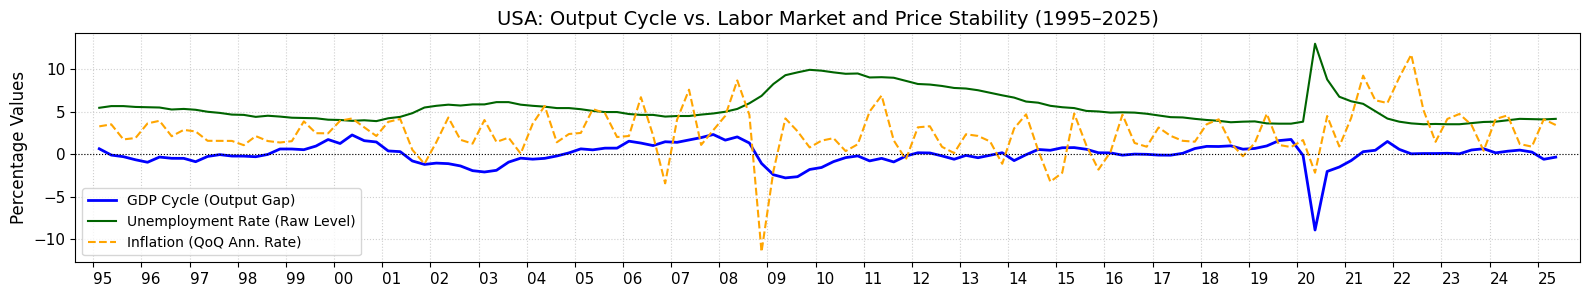

In [ ]:
# Assuming df_usa is defined, and common parameters are set (start_limit, end_limit, etc.)

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle']
RIGHT_VARS = ['UNEMPLOY', 'Inflation_QoQ'] # Variables moved to the primary axis

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- PRIMARY AXIS: GDP Cycle, Unemployment, and Inflation ---
ax1.set_xlabel('Year', fontsize=12)
# NOTE: Using a single generic label as variables have mixed units (Cycle Deviation vs. Raw Rates/Levels)
ax1.set_ylabel('Percentage Values', fontsize=12)

# 1. Plot GDP Cycle (Anchor)
ax1.plot(df_usa['Timestamp'], df_usa['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)

# 2. Plot Unemployment Rate (Raw Level, formerly on ax2)
ax1.plot(df_usa['Timestamp'], df_usa['UNEMPLOY'],
         label='Unemployment Rate (Raw Level)', color='darkgreen', linestyle='-', linewidth=1.5)

# 3. Plot Inflation Rate (Raw Level, formerly on ax2)
ax1.plot(df_usa['Timestamp'], df_usa['Inflation_QoQ'],
         label='Inflation (QoQ Ann. Rate)', color='orange', linestyle='--', linewidth=1.5)

ax1.tick_params(axis='y', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the single Axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11)
ax1.grid(True, linestyle=':', alpha=0.6)

# Legend moved to lower left as requested
ax1.legend(loc='lower left', fontsize=10)

ax1.set_title(f'USA: Output Cycle vs. Labor Market and Price Stability (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


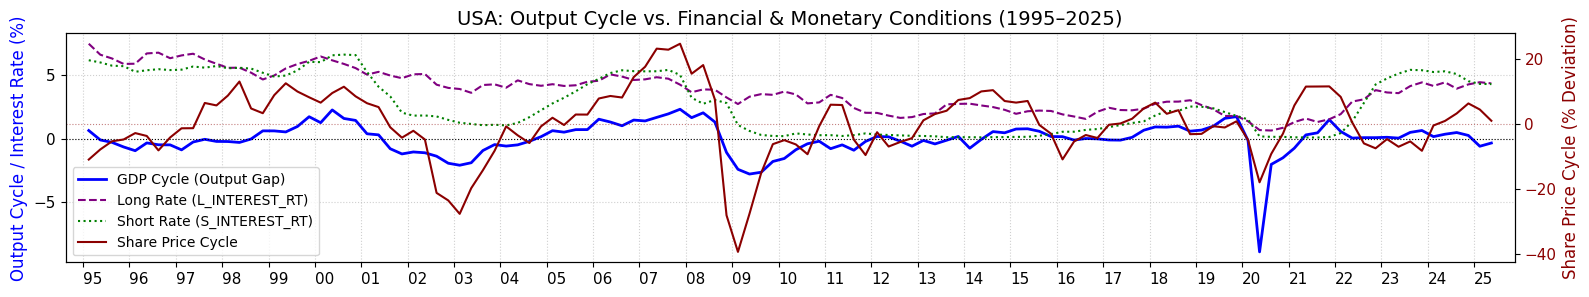

In [ ]:
# Assuming df_usa is defined, and common parameters are set (start_limit, end_limit, etc.)
# Assuming the quarter_formatter function is already defined

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle', 'L_INTEREST_RT', 'S_INTEREST_RT']
RIGHT_VARS = ['SHARE_PRICE_L_Cycle'] # This is the only variable on the secondary axis

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- AXIS 1 (LEFT): GDP Cycle and Interest Rates (Policy & Real Economy) ---
ax1.set_xlabel('Year', fontsize=12)
# Label covers both the cycle deviation and the raw interest rates
ax1.set_ylabel('Output Cycle / Interest Rate (%)', color='blue', fontsize=12)

# 1. Plot GDP Cycle (Anchor)
ax1.plot(df_usa['Timestamp'], df_usa['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)

# 2. Plot Long-term Interest Rate (Raw Level)
ax1.plot(df_usa['Timestamp'], df_usa['L_INTEREST_RT'],
         label='Long Rate (L_INTEREST_RT)', color='purple', linestyle='--', linewidth=1.5)

# 3. Plot Short-term Interest Rate (Raw Level)
ax1.plot(df_usa['Timestamp'], df_usa['S_INTEREST_RT'],
         label='Short Rate (S_INTEREST_RT)', color='green', linestyle=':', linewidth=1.5)


ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the primary axis

# --- AXIS 2 (RIGHT): Share Price Cycle (High Volatility) ---
ax2 = ax1.twinx()
ax2.set_ylabel('Share Price Cycle (% Deviation)', color='darkred', fontsize=12)

# 4. Plot Share Price Cycle
ax2.plot(df_usa['Timestamp'], df_usa['SHARE_PRICE_L_Cycle'],
         label='Share Price Cycle', color='darkred', linestyle='-', linewidth=1.5)

ax2.tick_params(axis='y', labelcolor='darkred', labelsize=11)
ax2.axhline(0, color='darkred', linestyle=':', linewidth=0.8, alpha=0.5) # Zero line for the secondary axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11)
ax1.grid(True, linestyle=':', alpha=0.6)

# Combine Legends and place in the lower left as requested
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize=10)

ax1.set_title(f'USA: Output Cycle vs. Financial & Monetary Conditions (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


### 1.6.3 UK

#### Each Vars

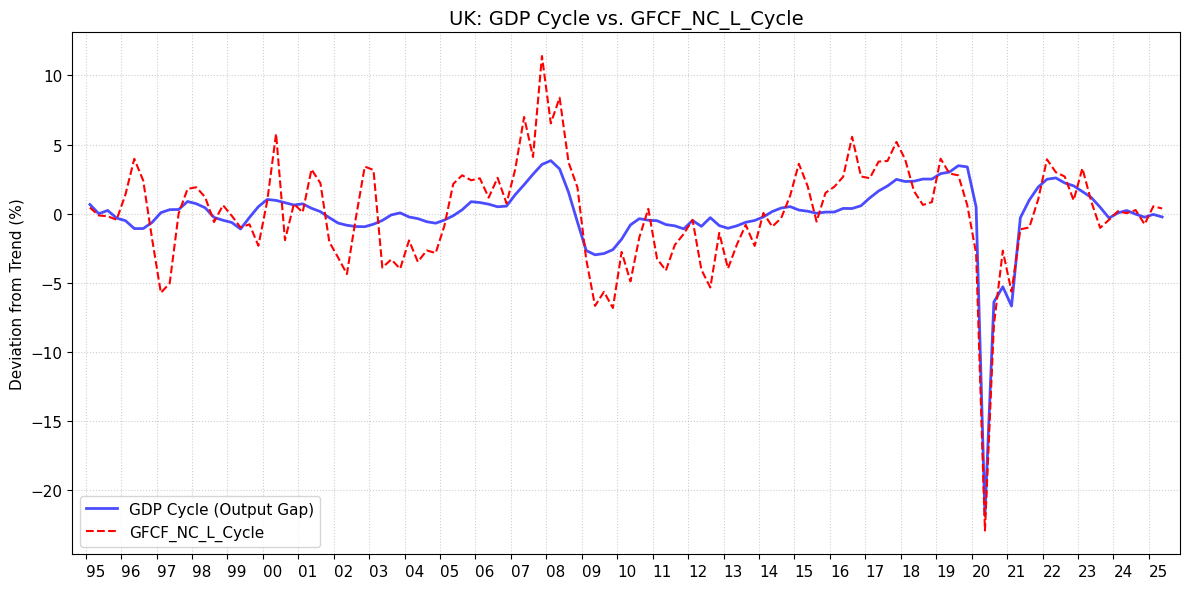

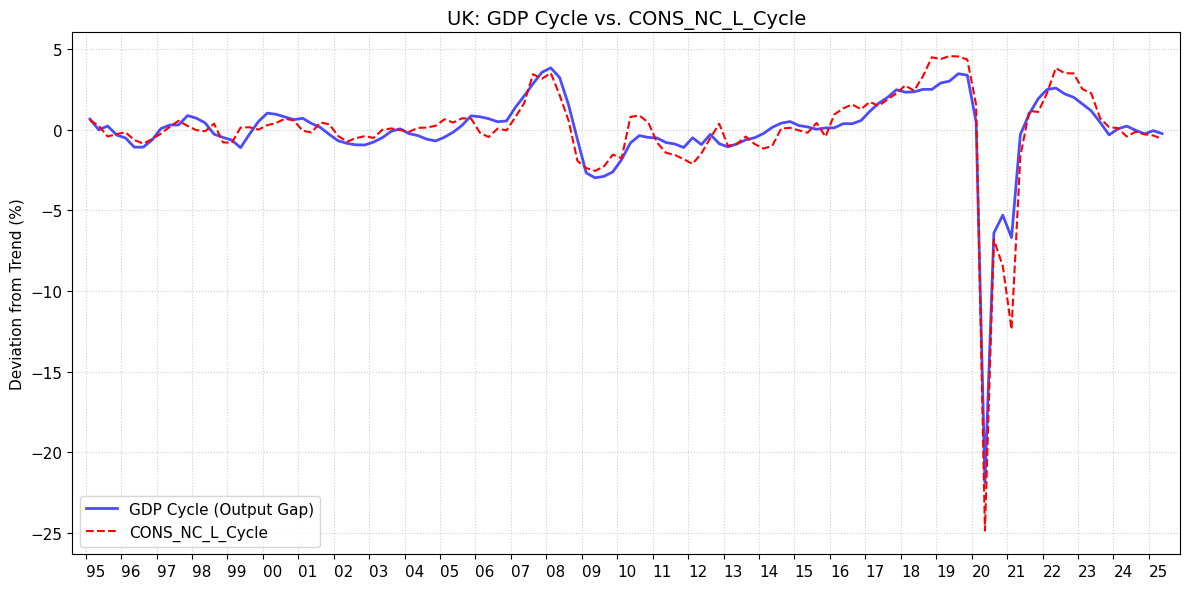

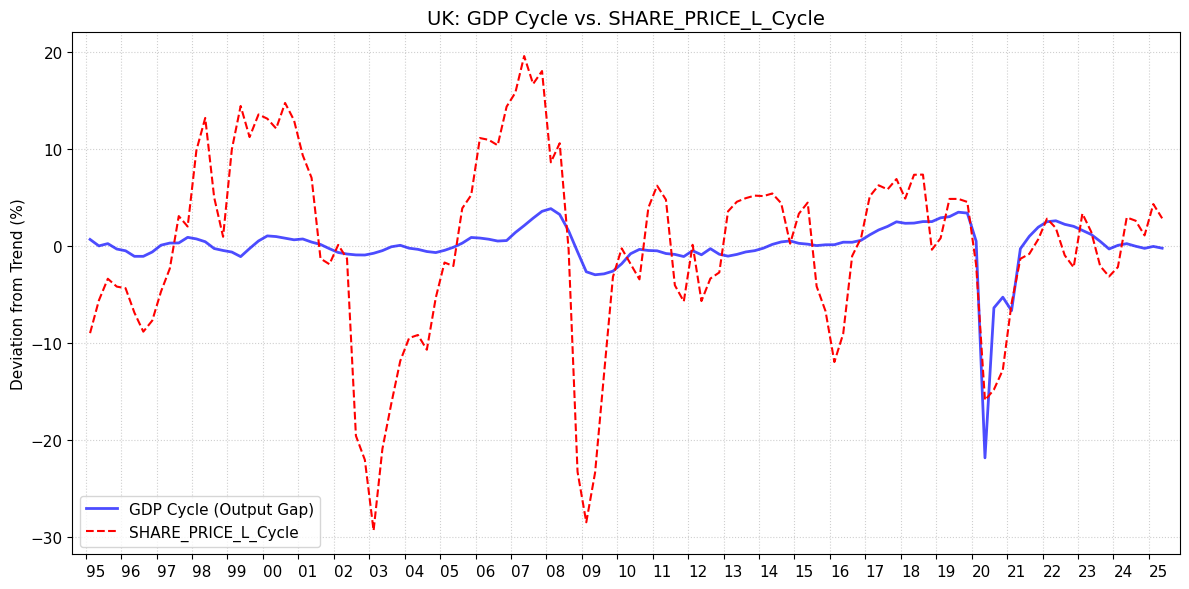

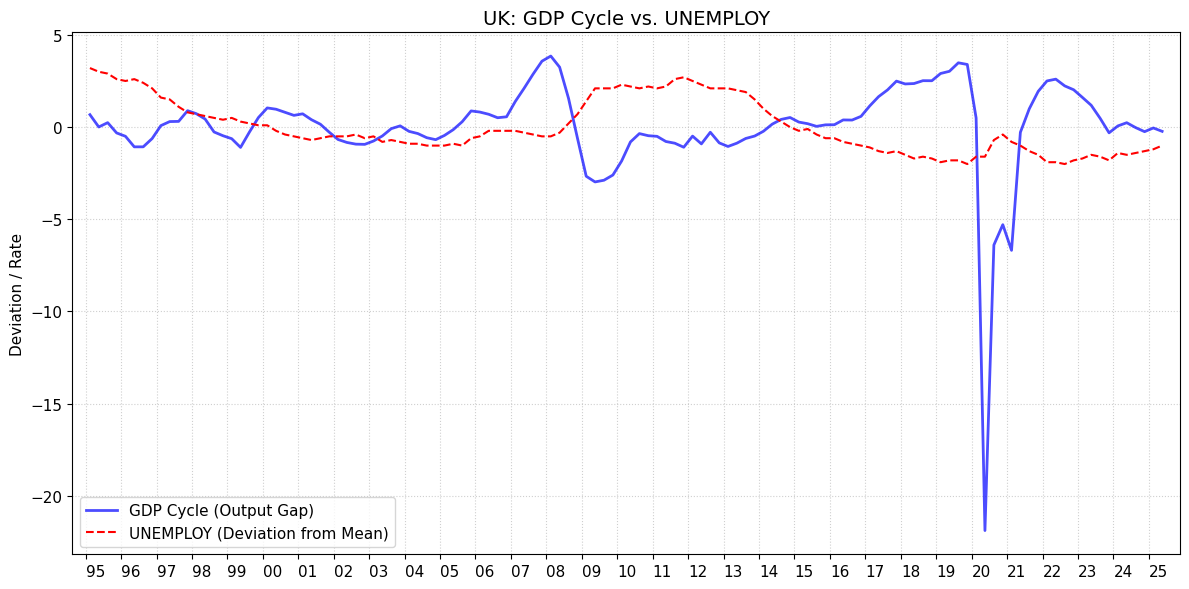

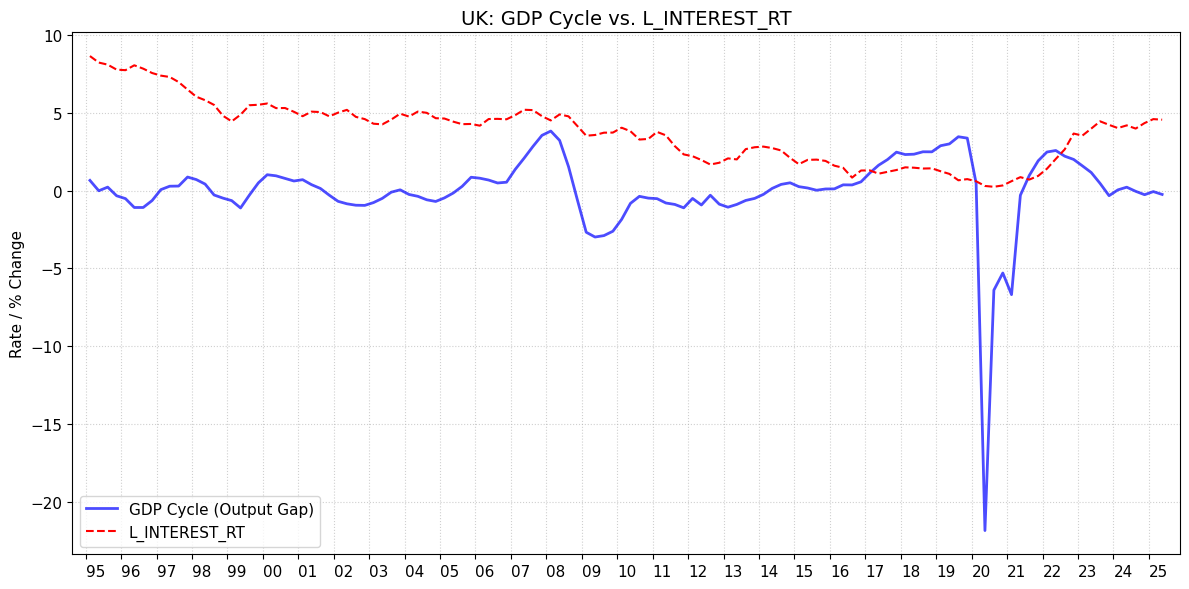

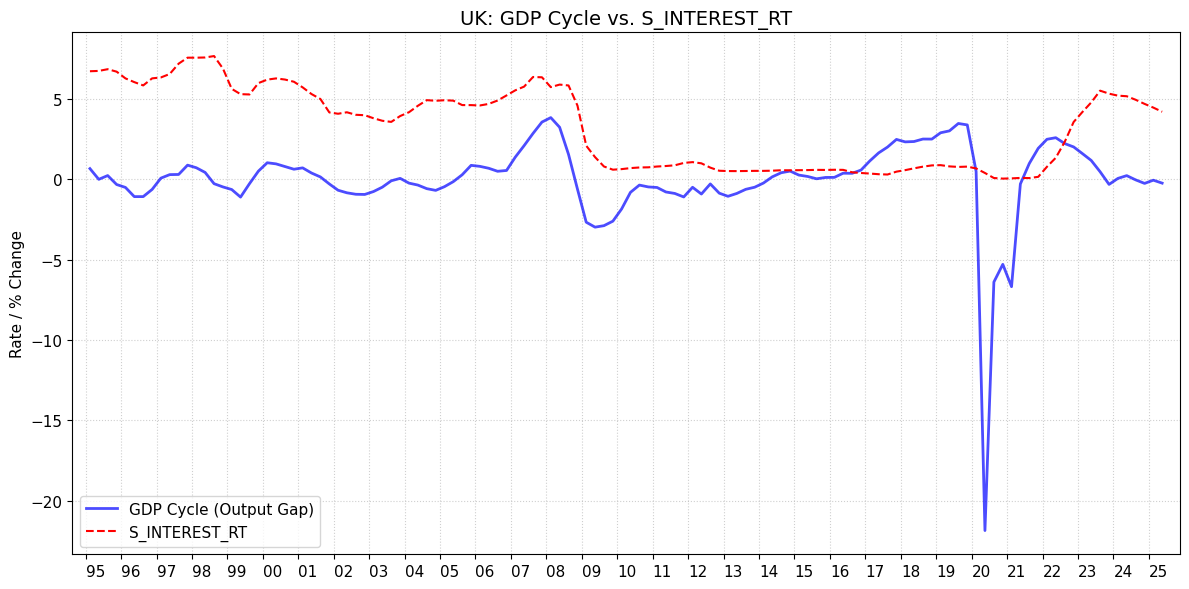

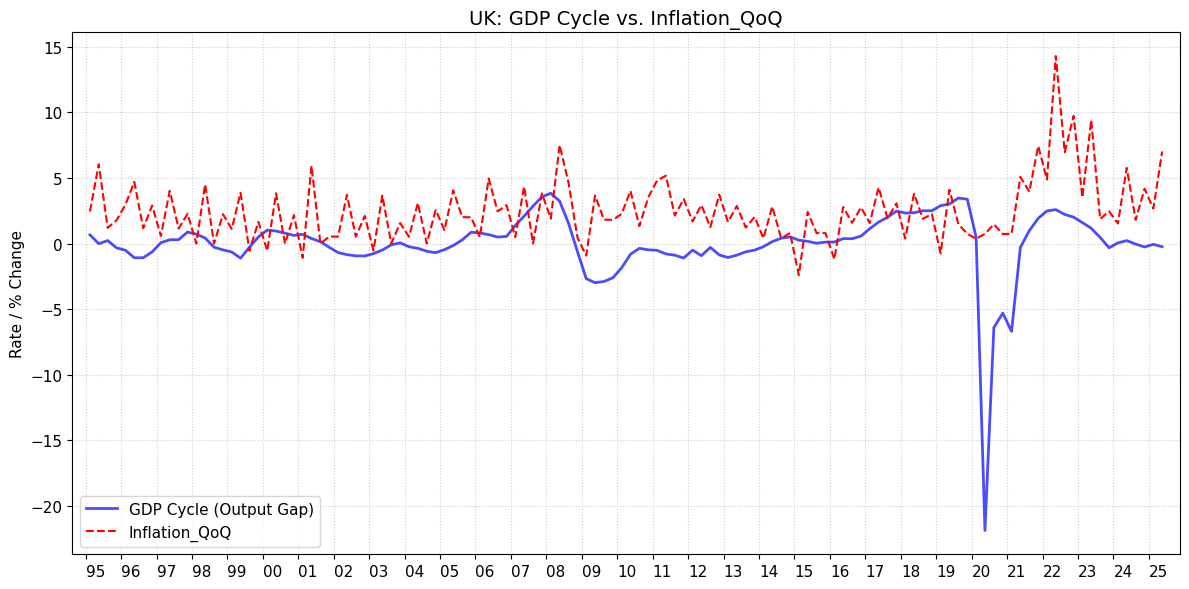

In [ ]:
# Filter data exclusively for the UK
df_uk = cycle_results.loc[(slice(None), 'UK'), :].droplevel(level='COUNTRY').copy()

# CRITICAL: Convert the PeriodIndex (DATE) to a Plottable DateTimeIndex
df_uk['Timestamp'] = df_uk.index.to_timestamp(freq='Q', how='end')

# --- Variables to be Plotted against the GDP Cycle ---
VARS_HP_CYCLES = ['GFCF_NC_L_Cycle', 'CONS_NC_L_Cycle', 'SHARE_PRICE_L_Cycle']
VARS_RATIO_CYCLES = ['UNEMPLOY', 'L_INTEREST_RT', 'S_INTEREST_RT', 'Inflation_QoQ']
COMPARE_VARS = VARS_HP_CYCLES + VARS_RATIO_CYCLES
GDP_CYCLE_COL = 'GDP_NC_L_Cycle'

# --- LOOP PLOTTING ---
for variable in COMPARE_VARS:
    # 1. Create a new Figure and get the Axes object (ax)
    fig, ax = plt.subplots(figsize=(12, 6))

    # 2. Plot the GDP Cycle (Reference Line)
    ax.plot(df_uk['Timestamp'], df_uk[GDP_CYCLE_COL],
             label='GDP Cycle (Output Gap)', color='blue', linewidth=2, alpha=0.7)

    # 3. Plot the Other Variable
    if variable == 'UNEMPLOY':
        # Unemployment Rate: Plot as Deviation from Mean (Cyclical component)
        ax.plot(df_uk['Timestamp'], df_uk[variable] - df_uk[variable].mean(),
                 label=f'{variable} (Deviation from Mean)', color='red', linestyle='--', linewidth=1.5)
        ax.set_ylabel('Deviation / Rate', fontsize=11)
    else:
        # All other Procyclical/Ratio variables
        ax.plot(df_uk['Timestamp'], df_uk[variable],
                 label=f'{variable}', color='red', linestyle='--', linewidth=1.5)

        # Adjust Y-axis label based on variable type
        if variable in VARS_HP_CYCLES:
             ax.set_ylabel('Deviation from Trend (%)', fontsize=11)
        else:
             ax.set_ylabel('Rate / % Change', fontsize=11)

    # --- X-Axis Customization ---
    # Set X-axis Limits (xlim)
    start_limit = pd.to_datetime('1994-10-01')  # End of 1994 / Start of 1995
    end_limit = pd.to_datetime('2026-01-01')
    ax.set_xlim(start_limit, end_limit)

    # Set Tick Positions (xticks) for every year
    tick_years = np.arange(1995, 2026, 1)
    tick_positions = [pd.to_datetime(f'{year}-02-15') for year in tick_years]
    tick_labels = [str(year)[2:] for year in tick_years]  # Two-digit year labels (e.g., '95')

    # Apply xticks to the correct Axes object
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, ha='left', fontsize=11)

    # Adjust Y-axis ticks font size
    ax.tick_params(axis='y', labelsize=11)

    # 4. Finalize Graph and Display
    ax.set_title(f'UK: GDP Cycle vs. {variable}', fontsize=14)
    ax.set_xlabel('')  # Remove X-axis label
    ax.legend(loc='lower left', fontsize=11)
    ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()
    print()

#### Combined Vars

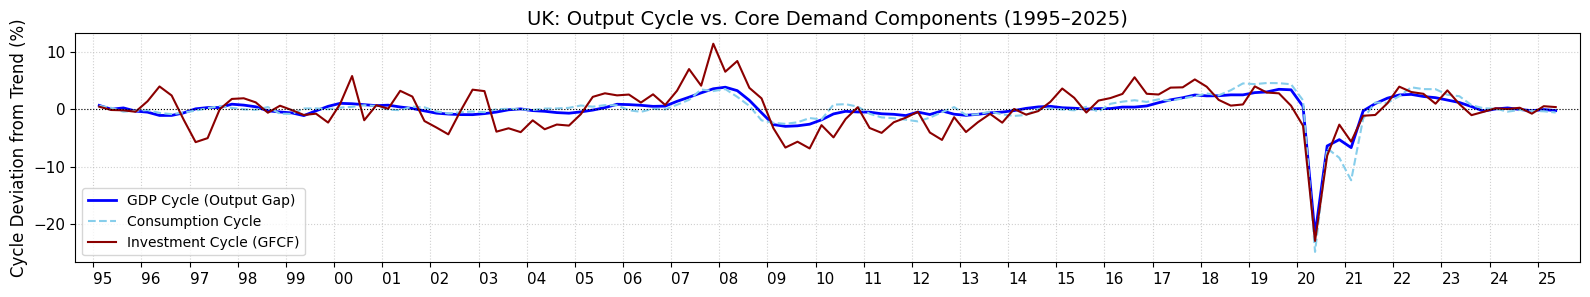

In [ ]:
# Assuming df_uk is defined, and common parameters are set (start_limit, end_limit, etc.)

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle', 'CONS_NC_L_Cycle']
RIGHT_VARS = ['GFCF_NC_L_Cycle'] # Variables moved to the primary axis

# Use df_uk for plotting
df_country = df_uk
COUNTRY_NAME = 'UK'

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- PRIMARY AXIS (LEFT): GDP, Consumption, and Investment Cycles ---
ax1.set_xlabel('Year', fontsize=12)
# Set Y-label to reflect that all lines are now cycles (deviation from trend)
ax1.set_ylabel('Cycle Deviation from Trend (%)', fontsize=12)

# Plot GDP Cycle (Anchor)
ax1.plot(df_country['Timestamp'], df_country['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)
# Plot Consumption Cycle
ax1.plot(df_country['Timestamp'], df_country['CONS_NC_L_Cycle'],
         label='Consumption Cycle', color='skyblue', linestyle='--', linewidth=1.5)

# Plot Investment Cycle (GFCF) - Moved from Secondary Axis (ax2) to Primary Axis (ax1)
ax1.plot(df_country['Timestamp'], df_country['GFCF_NC_L_Cycle'],
         label='Investment Cycle (GFCF)', color='darkred', linestyle='-', linewidth=1.5)

ax1.tick_params(axis='y', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the single Axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11)
ax1.grid(True, linestyle=':', alpha=0.6)

# Legend moved to lower left as requested
ax1.legend(loc='lower left', fontsize=10)

# Updated title to reflect the UK
ax1.set_title(f'{COUNTRY_NAME}: Output Cycle vs. Core Demand Components (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


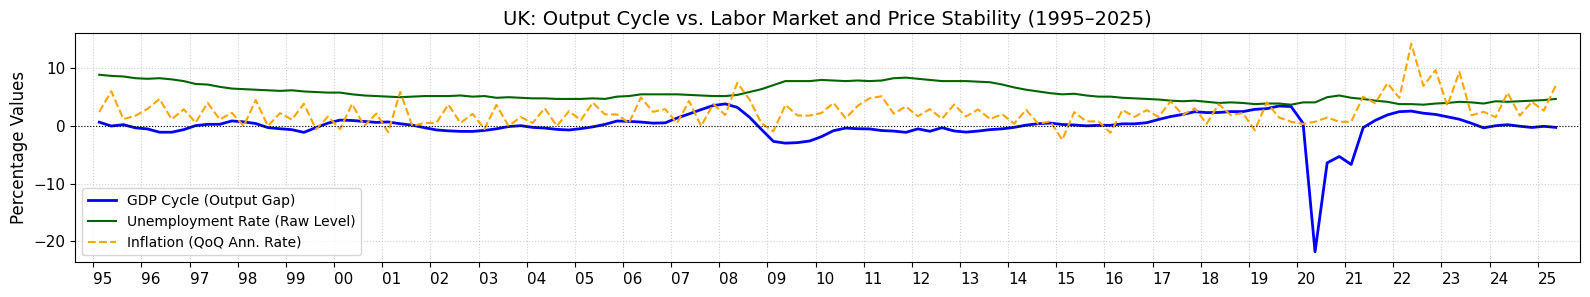

In [ ]:
# Assuming df_uk is defined, and common parameters are set (start_limit, end_limit, tick_positions, etc.)
# Note: df_uk must contain the 'Timestamp' column.

# --- Setup for UK Data (Assuming df_uk is ready) ---
# Use df_uk for plotting
df_country = df_uk
COUNTRY_NAME = 'UK'

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle']
RIGHT_VARS = ['UNEMPLOY', 'Inflation_QoQ'] # Variables now plotted on the primary axis

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- PRIMARY AXIS: GDP Cycle, Unemployment, and Inflation ---
ax1.set_xlabel('Year', fontsize=12)
# NOTE: Using a single generic label as variables have mixed units (Cycle Deviation vs. Raw Rates/Levels)
ax1.set_ylabel('Percentage Values', fontsize=12)

# 1. Plot GDP Cycle (Anchor)
ax1.plot(df_country['Timestamp'], df_country['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)

# 2. Plot Unemployment Rate (Raw Level, formerly on ax2)
ax1.plot(df_country['Timestamp'], df_country['UNEMPLOY'],
         label='Unemployment Rate (Raw Level)', color='darkgreen', linestyle='-', linewidth=1.5)

# 3. Plot Inflation Rate (Raw Level, formerly on ax2)
ax1.plot(df_country['Timestamp'], df_country['Inflation_QoQ'],
         label='Inflation (QoQ Ann. Rate)', color='orange', linestyle='--', linewidth=1.5)

ax1.tick_params(axis='y', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the single Axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11) # Retaining ha='left'
ax1.grid(True, linestyle=':', alpha=0.6)

# Legend moved to lower left as requested
ax1.legend(loc='lower left', fontsize=10)

# Updated title to reflect the UK
ax1.set_title(f'{COUNTRY_NAME}: Output Cycle vs. Labor Market and Price Stability (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


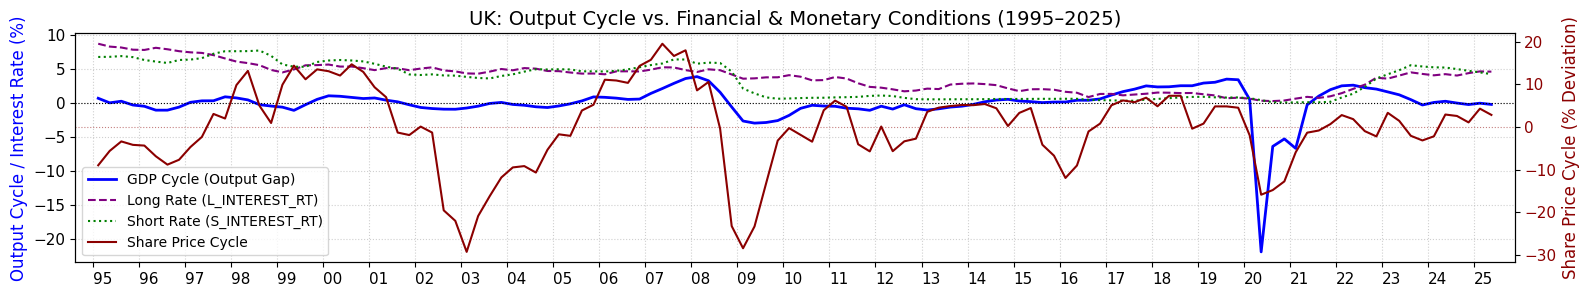

In [ ]:
# Assuming df_uk is defined, and common parameters are set (start_limit, end_limit, tick_positions, etc.)
# Assuming the quarter_formatter function is already defined
# Note: df_uk must contain the 'Timestamp' column.

# --- Setup for UK Data ---
# Use df_uk for plotting
df_country = df_uk
COUNTRY_NAME = 'UK'

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle', 'L_INTEREST_RT', 'S_INTEREST_RT']
RIGHT_VARS = ['SHARE_PRICE_L_Cycle'] # This is the only variable on the secondary axis

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- AXIS 1 (LEFT): GDP Cycle and Interest Rates (Policy & Real Economy) ---
ax1.set_xlabel('Year', fontsize=12)
# Label covers both the cycle deviation and the raw interest rates
ax1.set_ylabel('Output Cycle / Interest Rate (%)', color='blue', fontsize=12)

# 1. Plot GDP Cycle (Anchor)
ax1.plot(df_country['Timestamp'], df_country['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)

# 2. Plot Long-term Interest Rate (Raw Level)
ax1.plot(df_country['Timestamp'], df_country['L_INTEREST_RT'],
         label='Long Rate (L_INTEREST_RT)', color='purple', linestyle='--', linewidth=1.5)

# 3. Plot Short-term Interest Rate (Raw Level)
ax1.plot(df_country['Timestamp'], df_country['S_INTEREST_RT'],
         label='Short Rate (S_INTEREST_RT)', color='green', linestyle=':', linewidth=1.5)


ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the primary axis

# --- AXIS 2 (RIGHT): Share Price Cycle (High Volatility) ---
ax2 = ax1.twinx()
ax2.set_ylabel('Share Price Cycle (% Deviation)', color='darkred', fontsize=12)

# 4. Plot Share Price Cycle
ax2.plot(df_country['Timestamp'], df_country['SHARE_PRICE_L_Cycle'],
         label='Share Price Cycle', color='darkred', linestyle='-', linewidth=1.5)

ax2.tick_params(axis='y', labelcolor='darkred', labelsize=11)
ax2.axhline(0, color='darkred', linestyle=':', linewidth=0.8, alpha=0.5) # Zero line for the secondary axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11) # Retaining ha='left'
ax1.grid(True, linestyle=':', alpha=0.6)

# Combine Legends and place in the lower left as requested
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize=10)

# Updated title to reflect the UK
ax1.set_title(f'{COUNTRY_NAME}: Output Cycle vs. Financial & Monetary Conditions (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


### 1.6.4 Canada

#### Each Vars

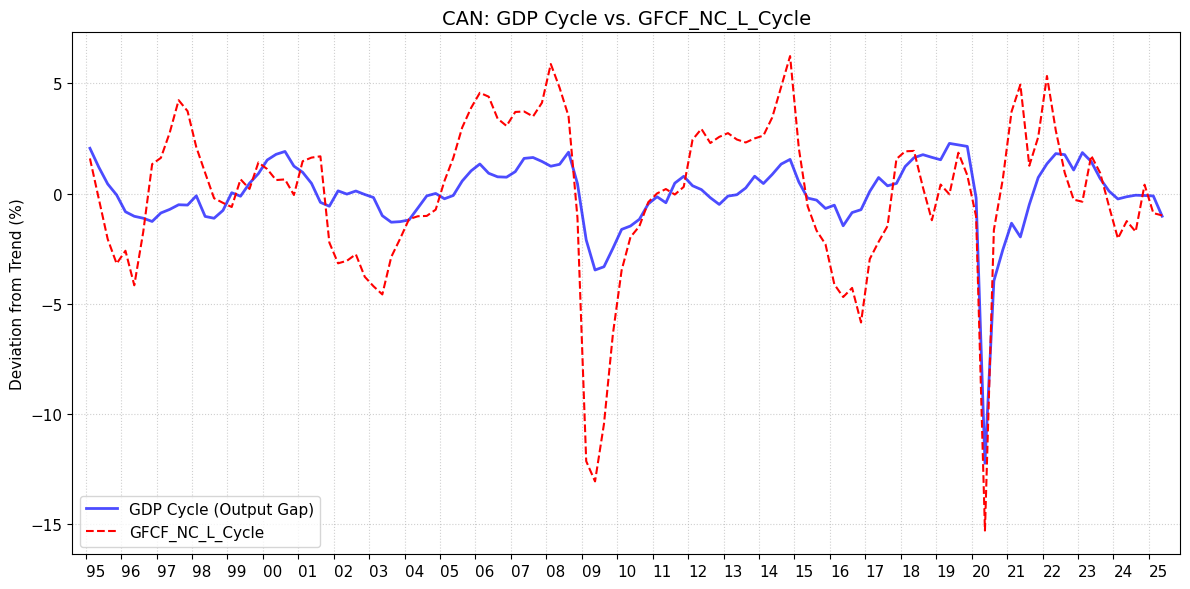

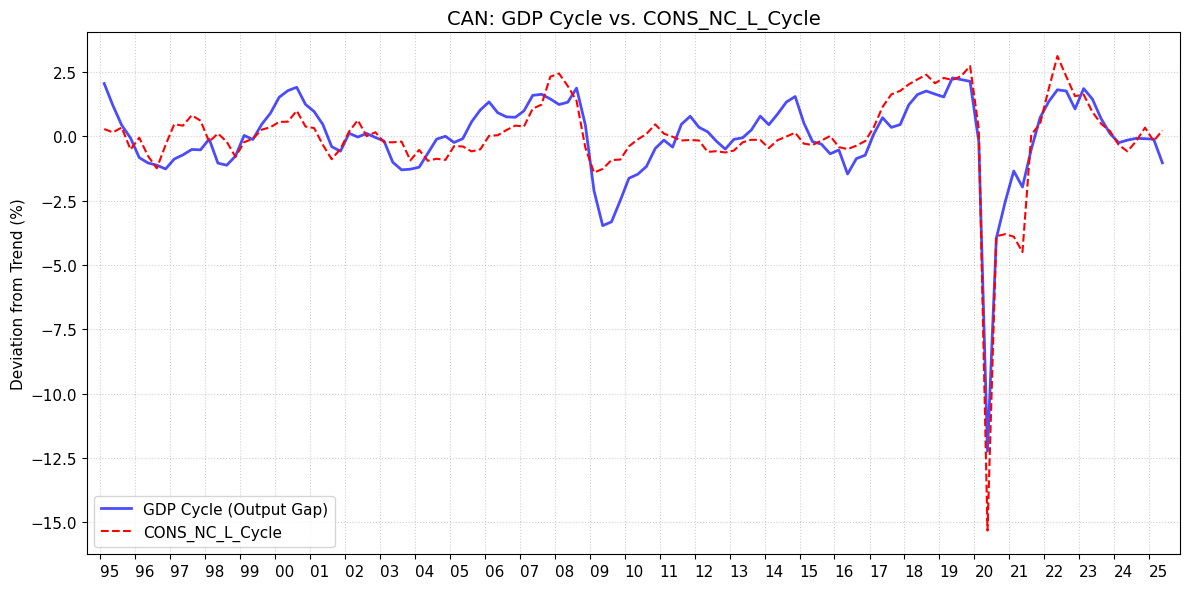

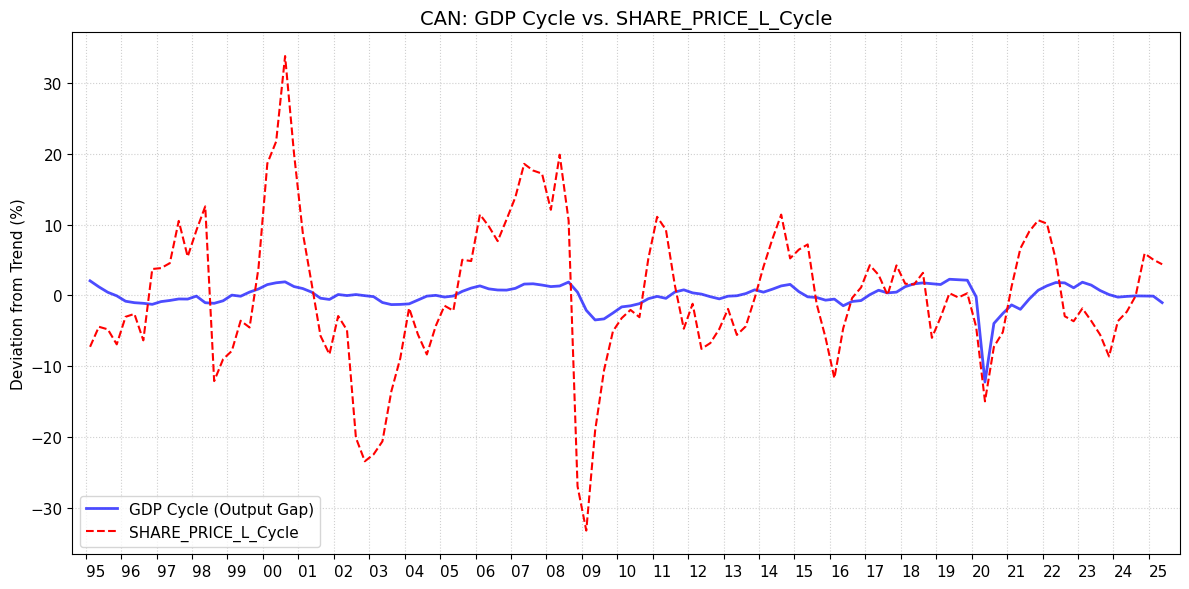

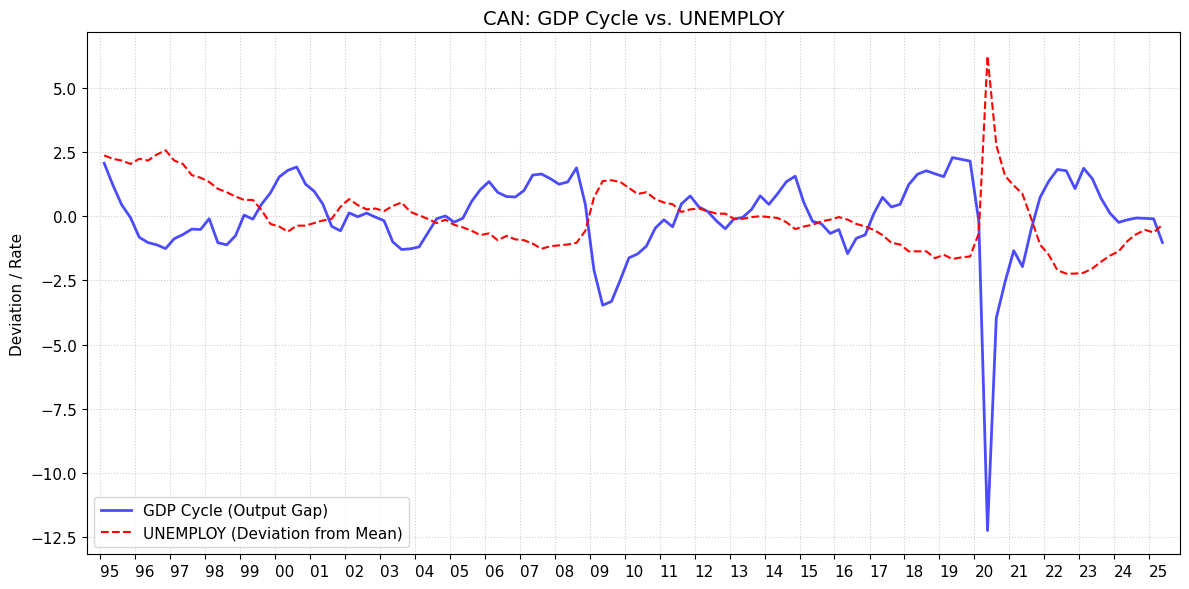

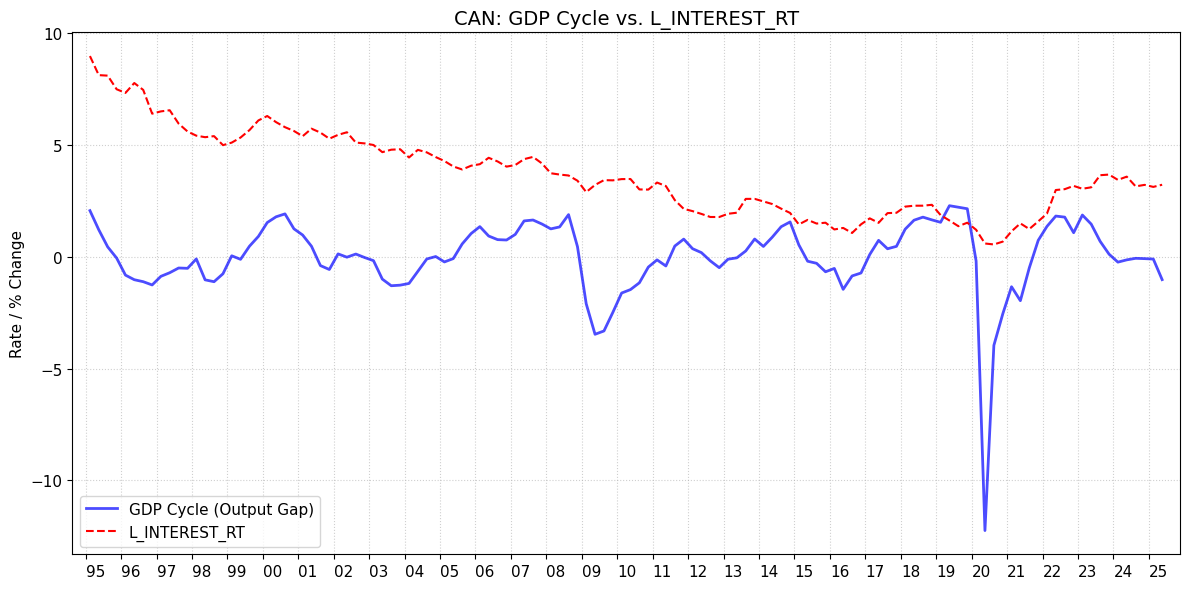

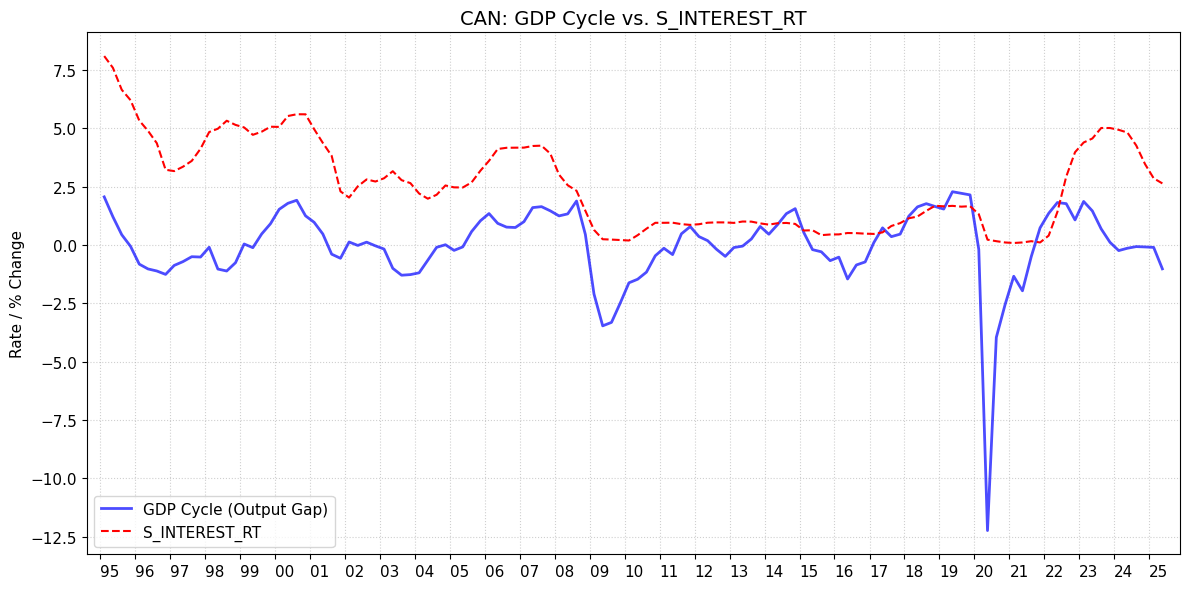

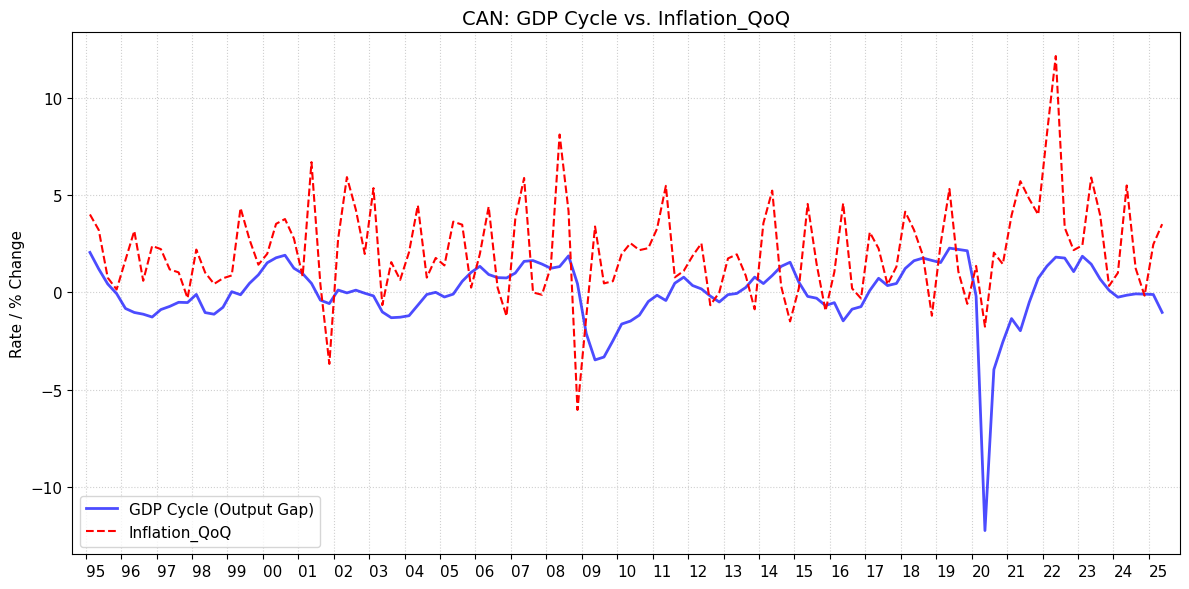

In [ ]:
# Filter data exclusively for CAN
df_can = cycle_results.loc[(slice(None), 'CAN'), :].droplevel(level='COUNTRY').copy()

# CRITICAL: Convert the PeriodIndex (DATE) to a Plottable DateTimeIndex
df_can['Timestamp'] = df_can.index.to_timestamp(freq='Q', how='end')

# --- Variables to be Plotted against the GDP Cycle ---
VARS_HP_CYCLES = ['GFCF_NC_L_Cycle', 'CONS_NC_L_Cycle', 'SHARE_PRICE_L_Cycle']
VARS_RATIO_CYCLES = ['UNEMPLOY', 'L_INTEREST_RT', 'S_INTEREST_RT', 'Inflation_QoQ']
COMPARE_VARS = VARS_HP_CYCLES + VARS_RATIO_CYCLES
GDP_CYCLE_COL = 'GDP_NC_L_Cycle'

# --- LOOP PLOTTING ---
for variable in COMPARE_VARS:
    # 1. Create a new Figure and get the Axes object (ax)
    fig, ax = plt.subplots(figsize=(12, 6))

    # 2. Plot the GDP Cycle (Reference Line)
    ax.plot(df_can['Timestamp'], df_can[GDP_CYCLE_COL],
             label='GDP Cycle (Output Gap)', color='blue', linewidth=2, alpha=0.7)

    # 3. Plot the Other Variable
    if variable == 'UNEMPLOY':
        # Unemployment Rate: Plot as Deviation from Mean (Cyclical component)
        ax.plot(df_can['Timestamp'], df_can[variable] - df_can[variable].mean(),
                 label=f'{variable} (Deviation from Mean)', color='red', linestyle='--', linewidth=1.5)
        ax.set_ylabel('Deviation / Rate', fontsize=11)
    else:
        # All other Procyclical/Ratio variables
        ax.plot(df_can['Timestamp'], df_can[variable],
                 label=f'{variable}', color='red', linestyle='--', linewidth=1.5)

        # Adjust Y-axis label based on variable type
        if variable in VARS_HP_CYCLES:
             ax.set_ylabel('Deviation from Trend (%)', fontsize=11)
        else:
             ax.set_ylabel('Rate / % Change', fontsize=11)

    # --- X-Axis Customization ---
    # Set X-axis Limits (xlim)
    start_limit = pd.to_datetime('1994-10-01')  # End of 1994 / Start of 1995
    end_limit = pd.to_datetime('2026-01-01')

    # Apply xlim to the correct Axes object
    ax.set_xlim(start_limit, end_limit)

    # Set Tick Positions (xticks) for every year
    tick_years = np.arange(1995, 2026, 1)
    tick_positions = [pd.to_datetime(f'{year}-02-15') for year in tick_years]
    tick_labels = [str(year)[2:] for year in tick_years]  # Two-digit year labels (e.g., '95')

    # Apply xticks to the correct Axes object
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, ha='left', fontsize=11)

    # Adjust Y-axis ticks font size
    ax.tick_params(axis='y', labelsize=11)

    # 4. Finalize Graph and Display
    ax.set_title(f'CAN: GDP Cycle vs. {variable}', fontsize=14)
    ax.set_xlabel('')  # Remove X-axis label
    ax.legend(loc='lower left', fontsize=11)
    ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()
    print()

#### Combined Vars

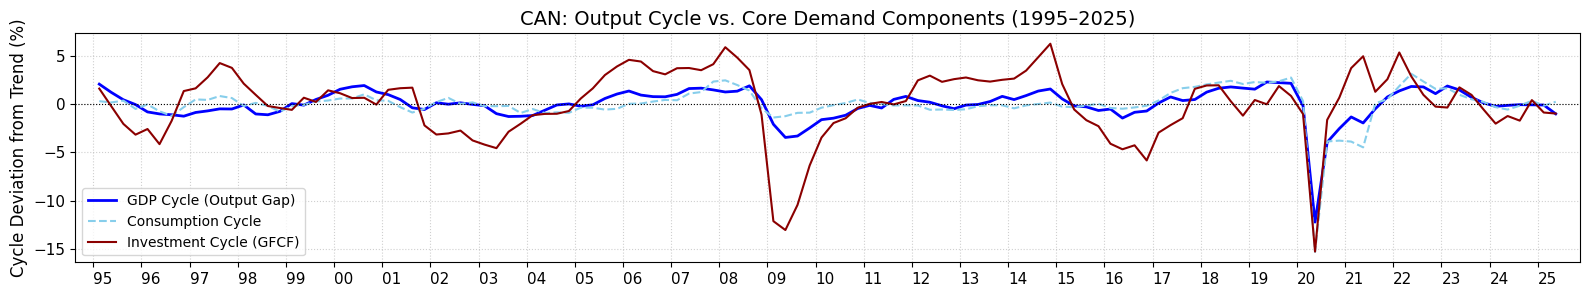

In [ ]:
# Assuming df_can is defined, and common parameters are set (start_limit, end_limit, tick_positions, etc.)
# Note: df_can must contain the 'Timestamp' column.

# --- Setup for Canada (CAN) Data ---
# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle', 'CONS_NC_L_Cycle']
RIGHT_VARS = ['GFCF_NC_L_Cycle'] # Variables moved to the primary axis

# Use df_can for plotting
df_country = df_can
COUNTRY_NAME = 'CAN'

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- PRIMARY AXIS (LEFT): GDP, Consumption, and Investment Cycles ---
ax1.set_xlabel('Year', fontsize=12)
# Set Y-label to reflect that all lines are now cycles (deviation from trend)
ax1.set_ylabel('Cycle Deviation from Trend (%)', fontsize=12)

# Plot GDP Cycle (Anchor)
ax1.plot(df_country['Timestamp'], df_country['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)
# Plot Consumption Cycle
ax1.plot(df_country['Timestamp'], df_country['CONS_NC_L_Cycle'],
         label='Consumption Cycle', color='skyblue', linestyle='--', linewidth=1.5)

# Plot Investment Cycle (GFCF) - All variables on the primary axis
ax1.plot(df_country['Timestamp'], df_country['GFCF_NC_L_Cycle'],
         label='Investment Cycle (GFCF)', color='darkred', linestyle='-', linewidth=1.5)

ax1.tick_params(axis='y', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the single Axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11)
ax1.grid(True, linestyle=':', alpha=0.6)

# Legend moved to lower left as requested
ax1.legend(loc='lower left', fontsize=10)

# Updated title to reflect Canada
ax1.set_title(f'{COUNTRY_NAME}: Output Cycle vs. Core Demand Components (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


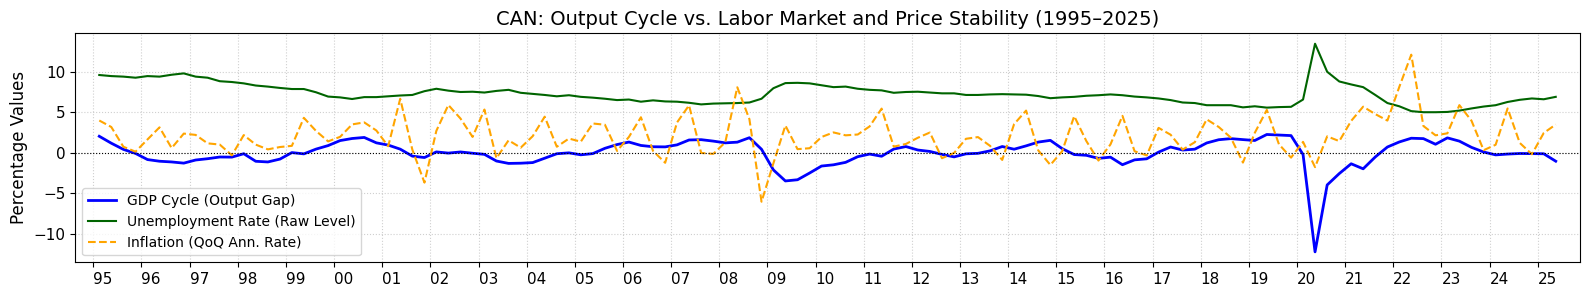

In [ ]:
# Assuming df_can is defined, and common parameters are set (start_limit, end_limit, tick_positions, etc.)
# Note: df_can must contain the 'Timestamp' column.

# --- Setup for Canada (CAN) Data ---
# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle']
RIGHT_VARS = ['UNEMPLOY', 'Inflation_QoQ'] # Variables now plotted on the primary axis

# Use df_can for plotting
df_country = df_can
COUNTRY_NAME = 'CAN'

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- PRIMARY AXIS: GDP Cycle, Unemployment, and Inflation ---
ax1.set_xlabel('Year', fontsize=12)
# NOTE: Using a single generic label as variables have mixed units (Cycle Deviation vs. Raw Rates/Levels)
# This is a visual compromise, as raw rates and cycle deviations are technically on different scales.
ax1.set_ylabel('Percentage Values', fontsize=12)

# 1. Plot GDP Cycle (Anchor)
ax1.plot(df_country['Timestamp'], df_country['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)

# 2. Plot Unemployment Rate (Raw Level)
ax1.plot(df_country['Timestamp'], df_country['UNEMPLOY'],
         label='Unemployment Rate (Raw Level)', color='darkgreen', linestyle='-', linewidth=1.5)

# 3. Plot Inflation Rate (Raw Level)
ax1.plot(df_country['Timestamp'], df_country['Inflation_QoQ'],
         label='Inflation (QoQ Ann. Rate)', color='orange', linestyle='--', linewidth=1.5)

ax1.tick_params(axis='y', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the single Axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11) # Retaining ha='left'
ax1.grid(True, linestyle=':', alpha=0.6)

# Legend moved to lower left as requested
ax1.legend(loc='lower left', fontsize=10)

# Updated title to reflect Canada
ax1.set_title(f'{COUNTRY_NAME}: Output Cycle vs. Labor Market and Price Stability (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


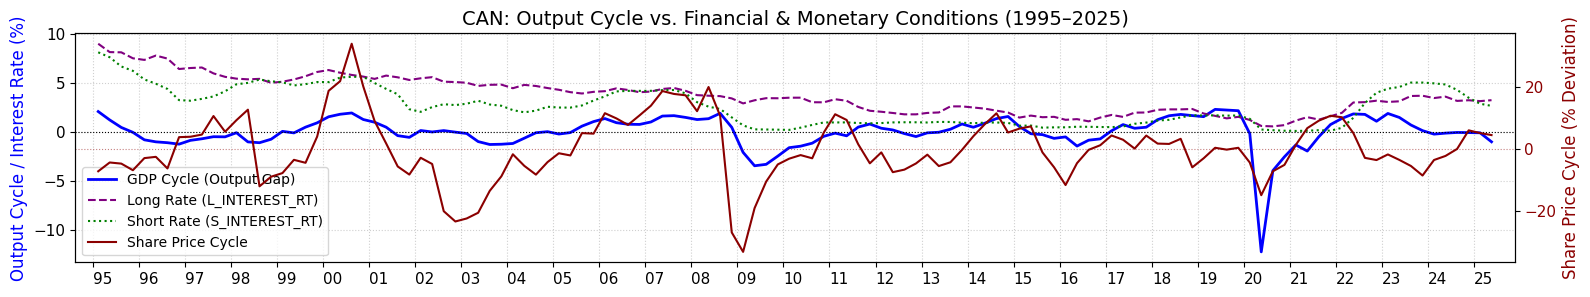

In [ ]:
# Assuming df_can is defined, and common parameters are set (start_limit, end_limit, tick_positions, etc.)
# Assuming the quarter_formatter function is already defined
# Note: df_can must contain the 'Timestamp' column.

# --- Setup for Canada (CAN) Data ---
# Use df_can for plotting
df_country = df_can
COUNTRY_NAME = 'CAN'

# Variables for this plot
LEFT_VARS = ['GDP_NC_L_Cycle', 'L_INTEREST_RT', 'S_INTEREST_RT']
RIGHT_VARS = ['SHARE_PRICE_L_Cycle'] # This is the only variable on the secondary axis

fig, ax1 = plt.subplots(figsize=(16, 3.07))

# --- AXIS 1 (LEFT): GDP Cycle and Interest Rates (Policy & Real Economy) ---
ax1.set_xlabel('Year', fontsize=12)
# Label covers both the cycle deviation and the raw interest rates
ax1.set_ylabel('Output Cycle / Interest Rate (%)', color='blue', fontsize=12)

# 1. Plot GDP Cycle (Anchor)
ax1.plot(df_country['Timestamp'], df_country['GDP_NC_L_Cycle'],
         label='GDP Cycle (Output Gap)', color='blue', linewidth=2)

# 2. Plot Long-term Interest Rate (Raw Level)
ax1.plot(df_country['Timestamp'], df_country['L_INTEREST_RT'],
         label='Long Rate (L_INTEREST_RT)', color='purple', linestyle='--', linewidth=1.5)

# 3. Plot Short-term Interest Rate (Raw Level)
ax1.plot(df_country['Timestamp'], df_country['S_INTEREST_RT'],
         label='Short Rate (S_INTEREST_RT)', color='green', linestyle=':', linewidth=1.5)


ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.axhline(0, color='black', linestyle=':', linewidth=0.8) # Zero line for the primary axis

# --- AXIS 2 (RIGHT): Share Price Cycle (High Volatility) ---
ax2 = ax1.twinx()
ax2.set_ylabel('Share Price Cycle (% Deviation)', color='darkred', fontsize=12)

# 4. Plot Share Price Cycle
ax2.plot(df_country['Timestamp'], df_country['SHARE_PRICE_L_Cycle'],
         label='Share Price Cycle', color='darkred', linestyle='-', linewidth=1.5)

ax2.tick_params(axis='y', labelcolor='darkred', labelsize=11)
ax2.axhline(0, color='darkred', linestyle=':', linewidth=0.8, alpha=0.5) # Zero line for the secondary axis

# --- Final Formatting ---
# Apply Shared X-Axis Settings
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, ha='left', fontsize=11) # Retaining ha='left'
ax1.grid(True, linestyle=':', alpha=0.6)

# Combine Legends and place in the lower left as requested
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize=10)

# Updated title to reflect Canada
ax1.set_title(f'{COUNTRY_NAME}: Output Cycle vs. Financial & Monetary Conditions (1995–2025)', fontsize=14)
ax1.set_xlabel('')
plt.tight_layout()
plt.show()


# PART 2: EVENT STUDY - THE GFC AND ONE OTHER RECESSION

## 2.1 Preparation

### 2.1.1 Library Import

In [ ]:
# Import necessary libraries (if not already imported in previous cells)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from IPython.display import display, Markdown
# Note: IPython.display is primarily used for cleaner output formatting in environments like Jupyter/Colab.

### 2.1.2 Data Preparation

In [ ]:
# Assuming df_cycle_analysis is the resulting DataFrame from your Task 1
# Filter data exclusively for the USA
df_usa_cycle = df_cycle_analysis.loc[(slice(None), 'USA'), :].copy()

# Drop the MultiIndex level ('COUNTRY') for easier plotting and manipulation
df_usa_cycle = df_usa_cycle.droplevel('COUNTRY')

print("USA Cycle Data successfully prepared. Example head:")
print(df_usa_cycle[['GDP_NC_L_Cycle', 'UNEMPLOY']].head())

USA Cycle Data successfully prepared. Example head:
        GDP_NC_L_Cycle  UNEMPLOY
DATE                            
1995Q1        0.648089  5.466667
1995Q2       -0.091969  5.666667
1995Q3       -0.283141  5.666667
1995Q4       -0.645440  5.566667
1996Q1       -0.939173  5.533333


### 2.1.3 Defining Functions

In [ ]:
from matplotlib.ticker import FuncFormatter

# --- Custom Function for Two-Line Quarter Format (YY\nQK) ---
def format_quarter(x, pos=None):
    """
    Custom function to format the date's ordinal value into a 'Year\nQuarter' string.
    e.g., 2005 Q1 becomes '05\nQ1'.
    """
    # Convert the plot value (ordinal) back to datetime object
    x = mdates.num2date(x)

    # Get the last 2 digits of the year
    year_yy = x.strftime('%y')
    # Calculate the Quarter number (1, 2, 3, 4)
    quarter = (x.month - 1) // 3 + 1

    # Use '\n' to create a new line for the two-line format
    return f'{year_yy}\nQ{quarter}'

# Assign the custom function to the formatter variable
quarter_formatter = FuncFormatter(format_quarter)

## 2.2 GFC (2007-2009) & Its Grpahs

The Global Financial Crisis (GFC, 2007–2009)

A. Impulse

Primary Shock: Financial Shock (Credit Collapse).
The initial impulse was not necessarily a fall in output, but the realization of risk in the U.S. subprime mortgage market and the failure of complex financial products (CDOs, MBS).

Empirical Evidence:
Your Share Price Cycle graph shows a significant and early decline, confirming the financial sector was the starting point.

B. Propagation

Deleveraging and Credit Crunch:
Financial institutions (banks) became risk-averse, freezing the interbank lending market. This drastically restricted credit supply to the real economy.

Financial Accelerator:
The fall in asset prices (housing, stocks) destroyed collateral values. This forced firms and households to sell assets or cut spending to meet debt obligations, leading to a vicious cycle:
Falling Asset Prices -> Tighter Credit -> Lower Demand.

Empirical Evidence:
- Duration (7 Quarters): The long duration confirms the slow, balance-sheet healing process required after a credit collapse.
- GDP Cycle and Unemployment: The slow, gradual rise in unemployment and sustained negative GDP gap show a long-lasting demand slump.

### 2.2.1 GDP Cycle

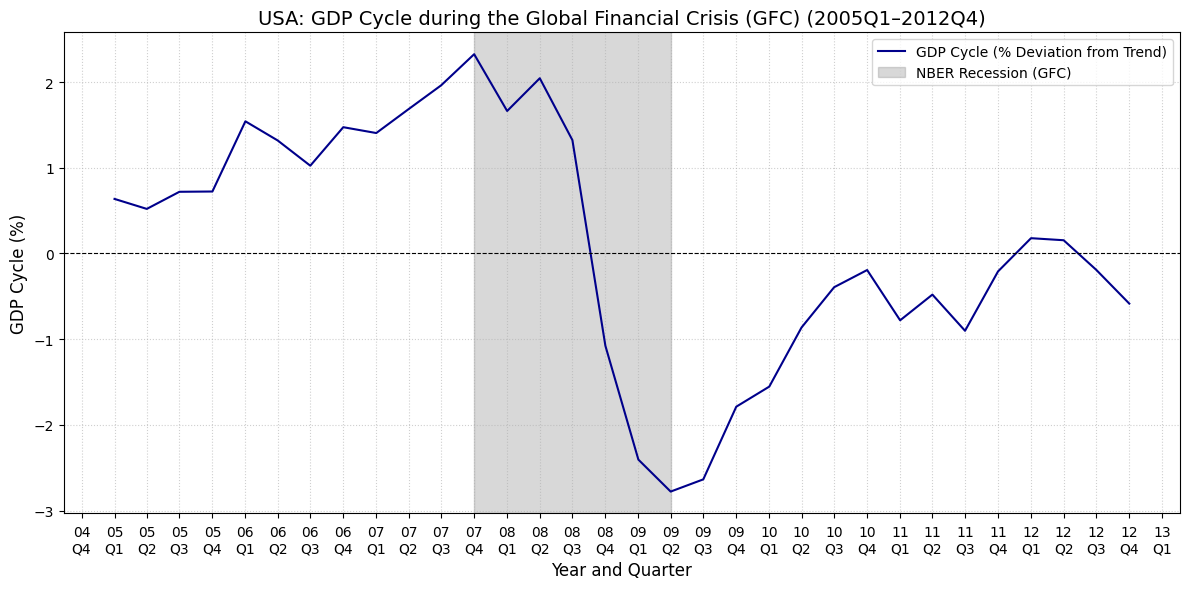

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the custom quarter_formatter function is already defined

## --- Visualization: GDP Cycle - GFC (2007 - 2009) ---

GFC_START = '2005Q1'
GFC_END = '2012Q4'
GFC_REC_START = '2007Q4'
GFC_REC_END = '2009Q2'

df_gfc = df_usa_cycle.loc[GFC_START:GFC_END].copy()

plt.figure(figsize=(12, 6))

# Plot GDP Cycle
plt.plot(df_gfc.index.to_timestamp(), df_gfc['GDP_NC_L_Cycle'], label='GDP Cycle (% Deviation from Trend)', color='darkblue')

# Gray shading to denote the recession period
plt.axvspan(pd.to_datetime(GFC_REC_START), pd.to_datetime(GFC_REC_END), color='gray', alpha=0.3, label='NBER Recession (GFC)')

# Zero line
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Format X-axis to display Quarters using the custom function
ax = plt.gca()

# LOCATOR SETTING: Aligning ticks with the start of the quarters as requested
# (1, 4, 7, and 10 correspond to the start of Q1, Q2, Q3, and Q4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(quarter_formatter)

plt.xticks(rotation=0, fontsize=10)
ax.tick_params(axis='x', which='major', pad=5)


plt.title(f'USA: GDP Cycle during the Global Financial Crisis (GFC) ({GFC_START}–{GFC_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('GDP Cycle (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.2.2 Unemployment

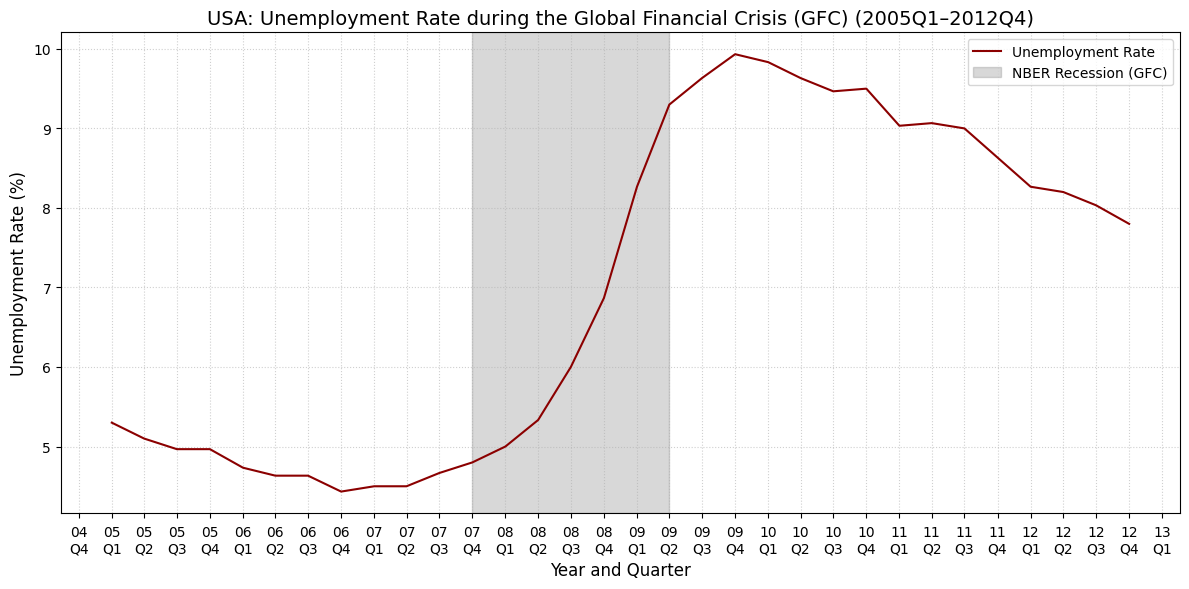

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: UNEMPLOYMENT RATE - GFC (2007 - 2009) ---

GFC_START = '2005Q1'
GFC_END = '2012Q4'
GFC_REC_START = '2007Q4'
GFC_REC_END = '2009Q2'

df_gfc = df_usa_cycle.loc[GFC_START:GFC_END].copy()

plt.figure(figsize=(12, 6))

# Plot Unemployment Rate
plt.plot(df_gfc.index.to_timestamp(), df_gfc['UNEMPLOY'], label='Unemployment Rate', color='darkred')

# Gray shading to denote the recession period
plt.axvspan(pd.to_datetime(GFC_REC_START), pd.to_datetime(GFC_REC_END), color='gray', alpha=0.3, label='NBER Recession (GFC)')

# Format X-axis (Two-Line Quarter Format)
ax = plt.gca()
# Tick placement aligned with the start of the quarters
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(quarter_formatter)

plt.xticks(rotation=0, fontsize=10)
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: Unemployment Rate during the Global Financial Crisis (GFC) ({GFC_START}–{GFC_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.2.3 Long-term Interest Rate

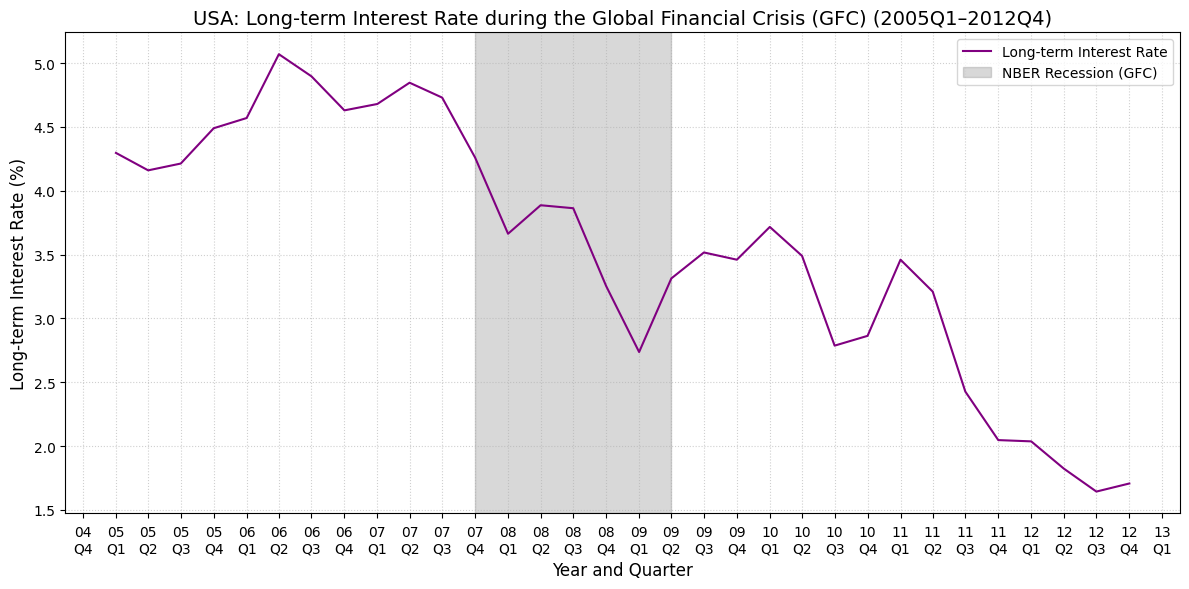

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: LONG-TERM INTEREST RATE - GFC (2007 - 2009) ---

GFC_START = '2005Q1'
GFC_END = '2012Q4'
GFC_REC_START = '2007Q4'
GFC_REC_END = '2009Q2'

df_gfc = df_usa_cycle.loc[GFC_START:GFC_END].copy()

plt.figure(figsize=(12, 6))

# Plot Long-term Interest Rate (L_INTEREST_RT)
plt.plot(df_gfc.index.to_timestamp(), df_gfc['L_INTEREST_RT'],
         label='Long-term Interest Rate', color='purple')

# Gray shading to denote the recession period
plt.axvspan(pd.to_datetime(GFC_REC_START), pd.to_datetime(GFC_REC_END), color='gray', alpha=0.3, label='NBER Recession (GFC)')

# Zero line (The zero line is commented out as interest rates are typically positive)
# plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Format X-axis (Two-Line Quarter Format)
ax = plt.gca()
# Tick placement aligned with the start of the quarters
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(quarter_formatter)

plt.xticks(rotation=0, fontsize=10)
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: Long-term Interest Rate during the Global Financial Crisis (GFC) ({GFC_START}–{GFC_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Long-term Interest Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.2.4 Share Price

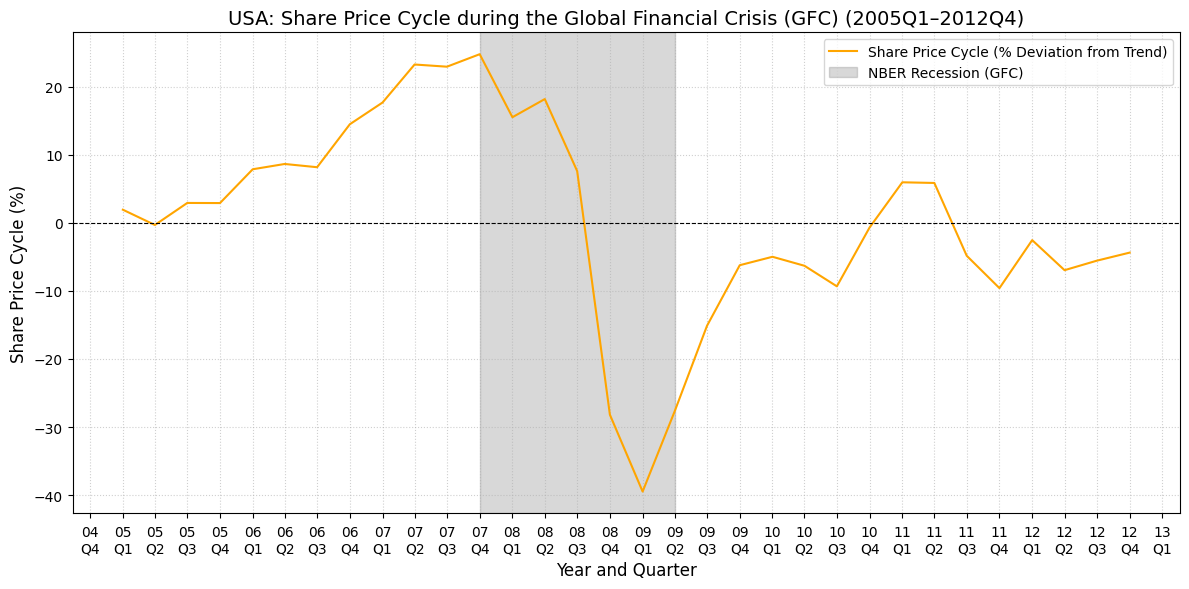

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: SHARE PRICE CYCLE - GFC (2007 - 2009) ---

GFC_START = '2005Q1'
GFC_END = '2012Q4'
GFC_REC_START = '2007Q4'
GFC_REC_END = '2009Q2'

df_gfc = df_usa_cycle.loc[GFC_START:GFC_END].copy()

plt.figure(figsize=(12, 6))

# Plot Share Price Cycle (Note the significantly higher volatility compared to GDP)
plt.plot(df_gfc.index.to_timestamp(), df_gfc['SHARE_PRICE_L_Cycle'],
         label='Share Price Cycle (% Deviation from Trend)', color='orange')

# Gray shading to denote the recession period
plt.axvspan(pd.to_datetime(GFC_REC_START), pd.to_datetime(GFC_REC_END), color='gray', alpha=0.3, label='NBER Recession (GFC)')

# Zero line
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Format X-axis (Two-Line Quarter Format)
ax = plt.gca()
# Tick placement aligned with the start of the quarters(Jan, Apr, Jul, Oct)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(quarter_formatter)

plt.xticks(rotation=0, fontsize=10)
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: Share Price Cycle during the Global Financial Crisis (GFC) ({GFC_START}–{GFC_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Share Price Cycle (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### Combined Vars

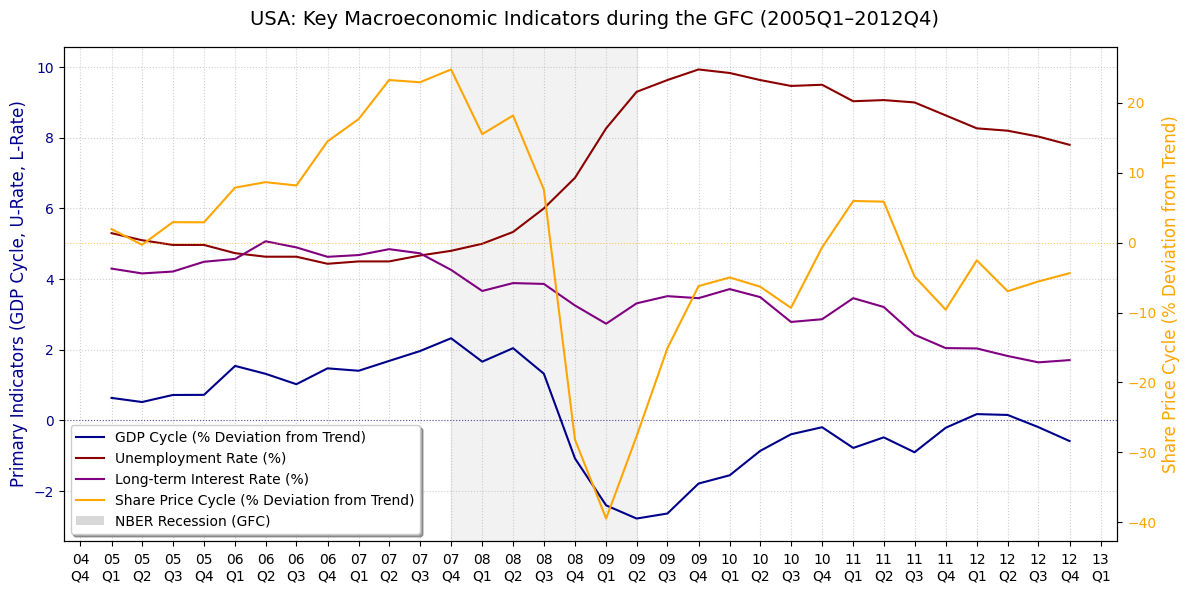

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np

# --- 1. Custom Function for Two-Line Quarter Format (YY\nQK) ---
def format_quarter(x, pos=None):
    """
    Custom function to format the date's ordinal value into a 'Year\nQuarter' string.
    e.g., 2005 Q1 becomes '05\nQ1'.
    """
    # Convert the plot value (ordinal) back to datetime object
    try:
        x = mdates.num2date(x)
    except ValueError:
        # Handle cases where mdates.num2date fails for axis ticks
        return ''

    # Get the last 2 digits of the year
    year_yy = x.strftime('%y')
    # Calculate the Quarter number (1, 2, 3, 4)
    quarter = (x.month - 1) // 3 + 1

    # Use '\n' to create a new line for the two-line format
    return f'{year_yy}\nQ{quarter}'

# Assign the custom function to the formatter variable
quarter_formatter = FuncFormatter(format_quarter)

# Set the dates
GFC_START_DATE = '2005-01-01'
GFC_END_DATE = '2012-10-01'
dates = pd.date_range(start=GFC_START_DATE, end=GFC_END_DATE, freq='QS-JAN')

# Convert dates to your Quarterly PeriodIndex format (e.g., 2005Q1)
index = pd.PeriodIndex(dates, freq='Q')

# --- 2. Plotting Setup and Data Slicing ---
# Define the constants from the original code
GFC_START = '2005Q1'
GFC_END = '2012Q4'
GFC_REC_START = '2007Q4'
GFC_REC_END = '2009Q2'

# Slice the data for the desired period and convert index to timestamp for plotting
df_gfc = df_usa_cycle.loc[GFC_START:GFC_END].copy()
timestamps = df_gfc.index.to_timestamp()

# --- 3. Combined Visualization (Dual-Axis Plot) ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Primary Y-Axis (ax1) ---

# Plot 1: GDP Cycle
p1, = ax1.plot(timestamps, df_gfc['GDP_NC_L_Cycle'],
               label='GDP Cycle (% Deviation from Trend)', color='darkblue')

# Plot 2: Unemployment Rate
p2, = ax1.plot(timestamps, df_gfc['UNEMPLOY'],
               label='Unemployment Rate (%)', color='darkred')

# Plot 3: Long-term Interest Rate
p3, = ax1.plot(timestamps, df_gfc['L_INTEREST_RT'],
               label='Long-term Interest Rate (%)', color='purple')

ax1.set_ylabel('Primary Indicators (GDP Cycle, U-Rate, L-Rate)', fontsize=12, color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Add zero line for GDP Cycle
ax1.axhline(0, color='darkblue', linestyle=':', linewidth=0.8, alpha=0.6)

# --- Secondary Y-Axis (ax2) ---
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

# Plot 4: Share Price Cycle
p4, = ax2.plot(timestamps, df_gfc['SHARE_PRICE_L_Cycle'],
               label='Share Price Cycle (% Deviation from Trend)', color='orange')

ax2.set_ylabel('Share Price Cycle (% Deviation from Trend)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add zero line for Share Price Cycle
ax2.axhline(0, color='orange', linestyle=':', linewidth=0.8, alpha=0.6)

# --- General Plot Formatting (Applied to ax1 and ax2) ---

# Gray shading to denote the recession period (applied to ax1, covers both)
ax1.axvspan(pd.to_datetime(GFC_REC_START), pd.to_datetime(GFC_REC_END),
            color='gray', alpha=0.1, label='NBER Recession (GFC)')

# Format X-axis (Custom Quarter Format)
# Tick placement aligned with the start of the quarters (Jan, Apr, Jul, Oct)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax1.xaxis.set_major_formatter(quarter_formatter)
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='major', pad=5, rotation=0, labelsize=10)

# Title and Grid
fig.suptitle(f'USA: Key Macroeconomic Indicators during the GFC ({GFC_START}–{GFC_END})', fontsize=14)
ax1.grid(True, linestyle=':', alpha=0.6)

# Create a combined legend from all lines (ax1 and ax2)
lines = [p1, p2, p3, p4]
labels = [l.get_label() for l in lines]
# Include the recession label
recession_patch = plt.Rectangle((0, 0), 1, 1, fc="gray", alpha=0.3)
lines.append(recession_patch)
labels.append('NBER Recession (GFC)')

# Place the legend in a spot that doesn't overlap the lines
ax1.legend(lines, labels, loc='lower left', frameon=True, fancybox=True, shadow=True)

fig.tight_layout()
plt.show()


## 2.3 Covid-19 (2020) & Its Graphs

The COVID-19 Recession (2020)

A. Impulse

Primary Shock: Exogenous and Sudden Supply Shock.
The initial impulse was not economic; it was the government-mandated shutdowns and health crisis. This shock instantly removed labor and production capacity (supply).

Secondary Shock: Demand Shock.
Fear, uncertainty, and income loss led to a sharp drop in consumption, especially for services (travel, dining).

Empirical Evidence:
- Severity (-10.65%) and Unemployment: Your quantitative analysis and the Unemployment Rate graph clearly show a massive, near-vertical spike, which is characteristic of an instantaneous, external shock hitting the labor force and supply capacity.

B. Propagation

Uncertainty and Inventory Cycle:
Firms faced extreme uncertainty, halting investment and drawing down inventories.

Policy Intervention (The Dominant Factor):
Unlike the GFC, propagation was immediately counteracted by massive, rapid policy:
- Fiscal Policy: Direct cash transfers and enhanced unemployment benefits prevented a collapse in aggregate demand.
- Monetary Policy: The Federal Reserve provided unlimited liquidity and dropped rates to near zero, stabilizing financial markets.

Empirical Evidence:
- Duration (3 Quarters): The extremely short duration confirms that the aggressive, immediate policy response and the nature of the temporary shutdown prevented the supply shock from propagating into a long, deep, classic financial crisis.
- Share Price Cycle: The V-shaped recovery in stock prices shows that the financial market quickly stabilized due to the overwhelming Fed liquidity.

### 2.3.1 GDP Cycle

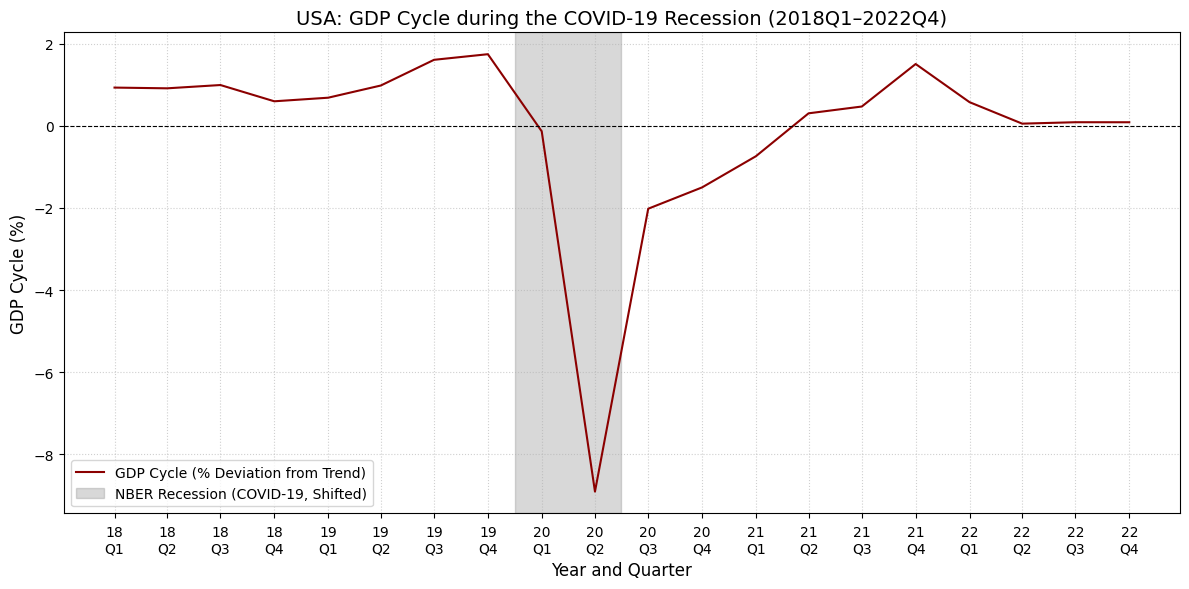

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: GDP Cycle - COVID-19 (2020) ---

COVID_START = '2018Q1'
COVID_END = '2022Q4'
# Note: NBER officially declared 2020Q1-2020Q2. Using the wider range (2019Q4-2020Q2) for visualization.
COVID_REC_START = '2019Q4'
COVID_REC_END = '2020Q2'

# Retrieve COVID-19 specific data range
df_covid = df_usa_cycle.loc[COVID_START:COVID_END].copy()

plt.figure(figsize=(12, 6)) # Slightly increased size for clearer labels

# Plot GDP Cycle
plt.plot(df_covid.index.to_timestamp(), df_covid['GDP_NC_L_Cycle'], label='GDP Cycle (% Deviation from Trend)', color='darkred')

# Gray shading to denote the recession period (shifted to the right)
# Define the offset (e.g., 1 month and 15 days for ~0.5 quarter offset)
offset = pd.DateOffset(months=1, days=15)

# Shift the recession start and end dates
shifted_rec_start = pd.to_datetime(COVID_REC_START) + offset
shifted_rec_end = pd.to_datetime(COVID_REC_END) + offset

plt.axvspan(shifted_rec_start, shifted_rec_end, color='gray', alpha=0.3, label='NBER Recession (COVID-19, Shifted)')

# Zero line
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Format X-axis to display Quarters using the custom function
ax = plt.gca()
# Locator setting: Mark every 3 months (quarterly)
# Note: This MonthLocator setting (interval=3) is generally used to align with the start of Jan, Apr, Jul, Oct.
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
# Formatter uses the custom two-line function (YY\nQK)
ax.xaxis.set_major_formatter(quarter_formatter)

# Rotation is set to 0 for the two-line format
plt.xticks(rotation=0, fontsize=10)
# Adjust padding to prevent the two-line label from clipping
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: GDP Cycle during the COVID-19 Recession ({COVID_START}–{COVID_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('GDP Cycle (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.3.2 Unemployment

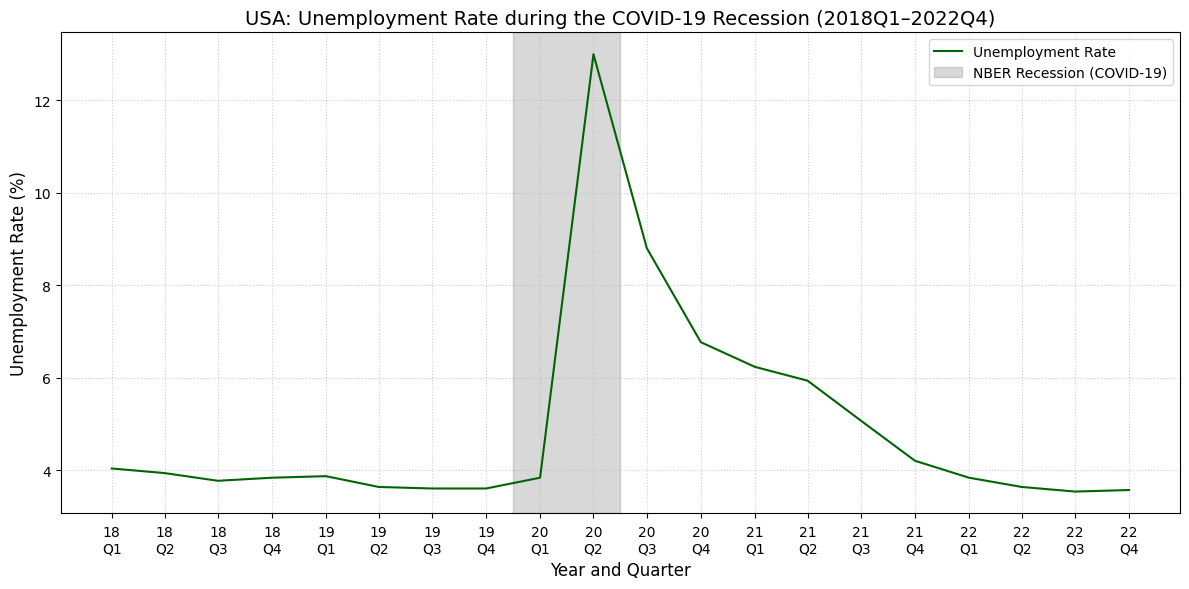

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: UNEMPLOYMENT RATE - COVID-19 (2020) ---

COVID_START = '2018Q1'
COVID_END = '2022Q4'
# Note: NBER officially declared 2020Q1-2020Q2. Using the wider range (2019Q4-2020Q2) for visualization.
COVID_REC_START = '2019Q4'
COVID_REC_END = '2020Q2'

# Retrieve COVID-19 specific data range
df_covid = df_usa_cycle.loc[COVID_START:COVID_END].copy()

plt.figure(figsize=(12, 6))

# Plot Unemployment Rate
plt.plot(df_covid.index.to_timestamp(), df_covid['UNEMPLOY'], label='Unemployment Rate', color='darkgreen')

# Gray shading to denote the recession period (shifted to the right)
# Define the offset (e.g., 1 month and 15 days for ~0.5 quarter offset)
offset = pd.DateOffset(months=1, days=15)

# Shift the recession start and end dates
shifted_rec_start = pd.to_datetime(COVID_REC_START) + offset
shifted_rec_end = pd.to_datetime(COVID_REC_END) + offset

plt.axvspan(shifted_rec_start, shifted_rec_end, color='gray', alpha=0.3, label='NBER Recession (COVID-19)')

# Format X-axis (Two-Line Quarter Format)
ax = plt.gca()
# Tick placement aligned with the start of the quarters(Jan, Apr, Jul, Oct)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
# Formatter uses the custom two-line function (YY\nQK)
ax.xaxis.set_major_formatter(quarter_formatter)

# Rotation is set to 0 for the two-line format
plt.xticks(rotation=0, fontsize=10)
# Adjust padding to prevent the two-line label from clipping
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: Unemployment Rate during the COVID-19 Recession ({COVID_START}–{COVID_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.3.3 Long-term Interest Rate

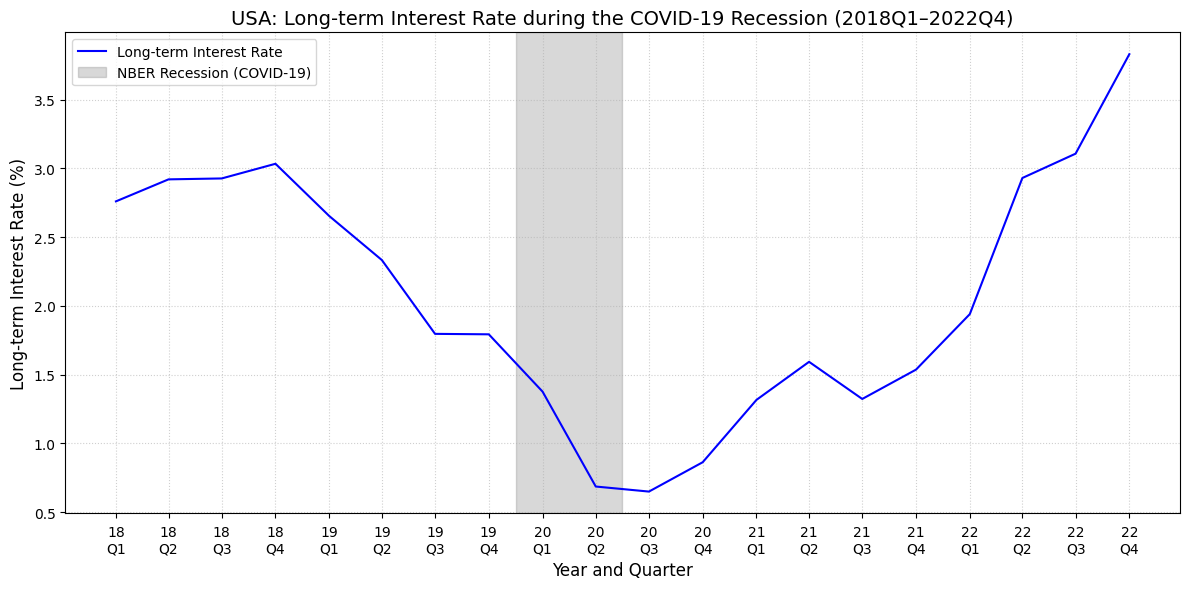

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: LONG-TERM INTEREST RATE - COVID-19 (2020) ---

COVID_START = '2018Q1'
COVID_END = '2022Q4'
# Note: Using the wider recession range (2019Q4-2020Q2) for visualization.
COVID_REC_START = '2019Q4'
COVID_REC_END = '2020Q2'

# Retrieve COVID-19 specific data range
df_covid = df_usa_cycle.loc[COVID_START:COVID_END].copy()

plt.figure(figsize=(12, 6))

# Plot Long-term Interest Rate (L_INTEREST_RT)
plt.plot(df_covid.index.to_timestamp(), df_covid['L_INTEREST_RT'],
         label='Long-term Interest Rate', color='blue')

# Gray shading to denote the recession period (shifted to the right)
# Define the offset (1 month and 15 days for ~0.5 quarter offset)
offset = pd.DateOffset(months=1, days=15)

# Shift the recession start and end dates
shifted_rec_start = pd.to_datetime(COVID_REC_START) + offset
shifted_rec_end = pd.to_datetime(COVID_REC_END) + offset

# Plot the shifted shading
plt.axvspan(shifted_rec_start, shifted_rec_end, color='gray', alpha=0.3, label='NBER Recession (COVID-19)')

# Format X-axis (Two-Line Quarter Format)
ax = plt.gca()
# Tick placement aligned with the start of the quarters (Jan, Apr, Jul, Oct)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(quarter_formatter)

plt.xticks(rotation=0, fontsize=10)
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: Long-term Interest Rate during the COVID-19 Recession ({COVID_START}–{COVID_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Long-term Interest Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.3.4 Share Price

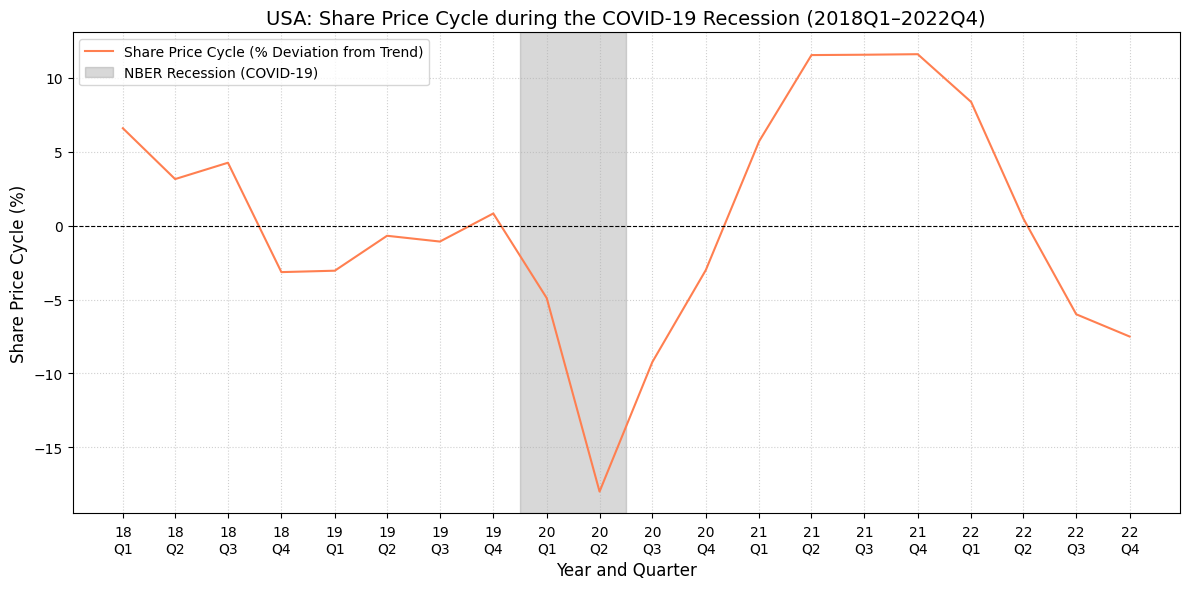

In [ ]:
# Assuming df_usa_cycle is already defined
# Assuming the quarter_formatter function is already defined

## --- Visualization: SHARE PRICE CYCLE - COVID-19 (2020) ---

COVID_START = '2018Q1'
COVID_END = '2022Q4'
# Note: Using the wider recession range (2019Q4-2020Q2) for visualization.
COVID_REC_START = '2019Q4'
COVID_REC_END = '2020Q2'

# Retrieve COVID-19 specific data range
df_covid = df_usa_cycle.loc[COVID_START:COVID_END].copy()

plt.figure(figsize=(12, 6))

# Plot Share Price Cycle
plt.plot(df_covid.index.to_timestamp(), df_covid['SHARE_PRICE_L_Cycle'],
         label='Share Price Cycle (% Deviation from Trend)', color='coral')

# Gray shading to denote the recession period (shifted to the right)
# Define the offset (1 month and 15 days for ~0.5 quarter offset)
offset = pd.DateOffset(months=1, days=15)

# Shift the recession start and end dates
shifted_rec_start = pd.to_datetime(COVID_REC_START) + offset
shifted_rec_end = pd.to_datetime(COVID_REC_END) + offset

# Plot the shifted shading
plt.axvspan(shifted_rec_start, shifted_rec_end, color='gray', alpha=0.3, label='NBER Recession (COVID-19)')

# Zero line
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Format X-axis (Two-Line Quarter Format)
ax = plt.gca()
# Tick placement aligned with the start of the quarters (Jan, Apr, Jul, Oct)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(quarter_formatter)

plt.xticks(rotation=0, fontsize=10)
ax.tick_params(axis='x', which='major', pad=5)

# Revised Title to include the full date range
plt.title(f'USA: Share Price Cycle during the COVID-19 Recession ({COVID_START}–{COVID_END})', fontsize=14)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Share Price Cycle (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### Combined Vars

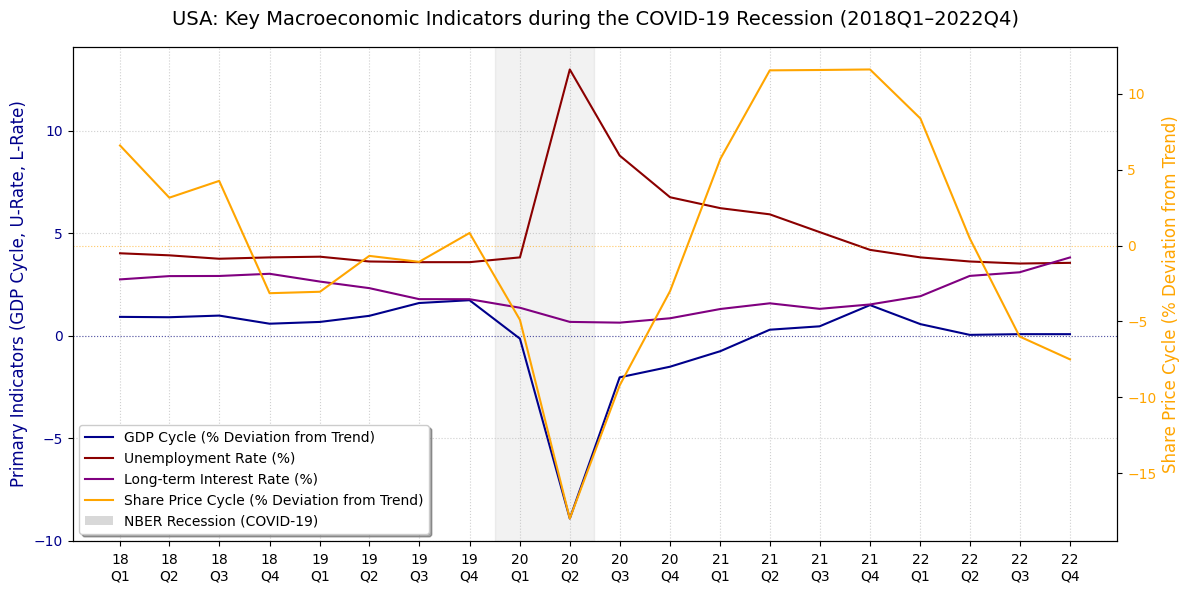

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
from datetime import timedelta

# --- 1. Custom Function for Two-Line Quarter Format (YY\nQK) ---
def format_quarter(x, pos=None):
    """
    Custom function to format the date's ordinal value into a 'Year\nQuarter' string.
    e.g., 2005 Q1 becomes '05\nQ1'.
    """
    # Convert the plot value (ordinal) back to datetime object
    try:
        x = mdates.num2date(x)
    except ValueError:
        # Handle cases where mdates.num2date fails for axis ticks
        return ''

    # Get the last 2 digits of the year
    year_yy = x.strftime('%y')
    # Calculate the Quarter number (1, 2, 3, 4)
    quarter = (x.month - 1) // 3 + 1

    # Use '\n' to create a new line for the two-line format
    return f'{year_yy}\nQ{quarter}'

# Assign the custom function to the formatter variable
quarter_formatter = FuncFormatter(format_quarter)


# --- 2. Generation for Runnability (COVID Period) ---
COVID_START_DATE = '2018-01-01'
COVID_END_DATE = '2022-10-01'
dates = pd.date_range(start=COVID_START_DATE, end=COVID_END_DATE, freq='QS-JAN')

# Convert dates to your Quarterly PeriodIndex format (e.g., 2018Q1)
index = pd.PeriodIndex(dates, freq='Q')

# --- 3. Plotting Setup and Data Slicing ---

# Define the constants for the COVID period
COVID_START = '2018Q1'
COVID_END = '2022Q4'
COVID_REC_START = '2019Q4'
COVID_REC_END = '2020Q2'

# Define the offset for the recession shading
offset = pd.DateOffset(months=1, days=15)

# Slice the data for the desired period and convert index to timestamp for plotting
df_covid = df_usa_cycle.loc[COVID_START:COVID_END].copy()
timestamps = df_covid.index.to_timestamp()

# Calculate shifted recession dates for axvspan
shifted_rec_start = pd.to_datetime(COVID_REC_START) + offset
shifted_rec_end = pd.to_datetime(COVID_REC_END) + offset

# --- 4. Combined Visualization (Dual-Axis Plot) ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Primary Y-Axis (ax1): GDP, UNEMPLOYMENT, L_INTEREST_RT ---

# Plot 1: GDP Cycle (Dark Blue)
p1, = ax1.plot(timestamps, df_covid['GDP_NC_L_Cycle'],
               label='GDP Cycle (% Deviation from Trend)', color='darkblue')

# Plot 2: Unemployment Rate (Dark Red)
p2, = ax1.plot(timestamps, df_covid['UNEMPLOY'],
               label='Unemployment Rate (%)', color='darkred')

# Plot 3: Long-term Interest Rate (Purple)
p3, = ax1.plot(timestamps, df_covid['L_INTEREST_RT'],
               label='Long-term Interest Rate (%)', color='purple')

ax1.set_ylabel('Primary Indicators (GDP Cycle, U-Rate, L-Rate)', fontsize=12, color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Add zero line for GDP Cycle
ax1.axhline(0, color='darkblue', linestyle=':', linewidth=0.8, alpha=0.6)

# --- Secondary Y-Axis (ax2): SHARE_PRICE_L_Cycle ---
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

# Plot 4: Share Price Cycle (Orange)
p4, = ax2.plot(timestamps, df_covid['SHARE_PRICE_L_Cycle'],
               label='Share Price Cycle (% Deviation from Trend)', color='orange')

ax2.set_ylabel('Share Price Cycle (% Deviation from Trend)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add zero line for Share Price Cycle
ax2.axhline(0, color='orange', linestyle=':', linewidth=0.8, alpha=0.6)

# --- General Plot Formatting ---

# Gray shading to denote the recession period (shifted)
ax1.axvspan(shifted_rec_start, shifted_rec_end,
            color='gray', alpha=0.1, label='NBER Recession (COVID-19)')

# Format X-axis (Custom Quarter Format)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax1.xaxis.set_major_formatter(quarter_formatter)
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='major', pad=5, rotation=0, labelsize=10)

# Title and Grid
fig.suptitle(f'USA: Key Macroeconomic Indicators during the COVID-19 Recession ({COVID_START}–{COVID_END})', fontsize=14)
ax1.grid(True, linestyle=':', alpha=0.6)

# Create a combined legend from all lines (using 'upper left' to avoid overlap)
lines = [p1, p2, p3, p4]
labels = [l.get_label() for l in lines]
# Include the recession label
recession_patch = plt.Rectangle((0, 0), 1, 1, fc="gray", alpha=0.3)
lines.append(recession_patch)
labels.append('NBER Recession (COVID-19)')

# Use 'upper left' for the legend to avoid line overlap
ax1.legend(lines, labels, loc='lower left', frameon=True, fancybox=True, shadow=True)

fig.tight_layout()
plt.show()


## 2.4 Severity & Recession Duration

### 2.4.1 Calculating Severity

In [ ]:
# Assuming df_gfc and df_covid are defined from previous visualization steps
gdp_gfc = df_gfc['GDP_NC_L_Cycle']
gdp_covid = df_covid['GDP_NC_L_Cycle']

# --- A. GFC Severity ---
# Find the Peak (maximum) and Trough (minimum) values
peak_gfc = gdp_gfc.max()
trough_gfc = gdp_gfc.min()
severity_gfc = trough_gfc - peak_gfc

# --- B. COVID-19 Severity ---
# Find the Peak (maximum) and Trough (minimum) values
peak_covid = gdp_covid.max()
trough_covid = gdp_covid.min()
severity_covid = trough_covid - peak_covid

print("--- Peak-to-Trough Severity ---")
print(f"GFC Severity: {severity_gfc:.2f}% (GDP deviates by {abs(severity_gfc):.2f}% from trend)")
print(f"COVID-19 Severity: {severity_covid:.2f}% (GDP deviates by {abs(severity_covid):.2f}% from trend)")

--- Peak-to-Trough Severity ---
GFC Severity: -5.10% (GDP deviates by 5.10% from trend)
COVID-19 Severity: -10.65% (GDP deviates by 10.65% from trend)


Quantitative analysis of the recession's severity, measured by the maximum decline in the Cyclical GDP (percentage deviation from trend) from peak to trough, reveals a striking difference between the two events. The COVID-19 Crisis (2020) was significantly more severe in terms of the depth of contraction compared to the Global Financial Crisis (GFC). During the GFC, the U.S. Cyclical GDP experienced a maximum decline of -5.10% from its trend. In contrast, the COVID-19 Recession resulted in a Cyclical GDP decline of up to -10.65%.

This data clearly indicates that, at its peak, the exogenous shock and forced shutdowns caused by COVID-19 exerted more than double the negative pressure on real Output (GDP) relative to the long-term growth trend, compared to the financial crisis driven by the credit crunch during the GFC. Nevertheless, this figure must be interpreted alongside the recession's duration; while COVID-19 was deeper, the GFC was characterized by a significantly longer contraction and early recovery phase, which will be further discussed in the duration analysis.

### 2.4.2 Recession Duration

In [ ]:
# --- C. GFC Duration ---
# Find the quarter date/index for the Peak (maximum) and Trough (minimum)
peak_date_gfc = gdp_gfc.idxmax()
trough_date_gfc = gdp_gfc.idxmin()

# Calculate the difference in quarters (using PeriodIndex for precise quarterly difference)
duration_quarters_gfc = (pd.PeriodIndex([trough_date_gfc]) - pd.PeriodIndex([peak_date_gfc]))[0].n + 1

# --- D. COVID-19 Duration ---
# Find the quarter date/index for the Peak (maximum) and Trough (minimum)
peak_date_covid = gdp_covid.idxmax()
trough_date_covid = gdp_covid.idxmin()

# Calculate the difference in quarters
duration_quarters_covid = (pd.PeriodIndex([trough_date_covid]) - pd.PeriodIndex([peak_date_covid]))[0].n + 1

print("\n--- Recession Duration (Peak-to-Trough) ---")
print(f"GFC Peak: {peak_date_gfc} to Trough: {trough_date_gfc}")
print(f"GFC Duration: {duration_quarters_gfc} Quarters")
print(f"COVID-19 Peak: {peak_date_covid} to Trough: {trough_date_covid}")
print(f"COVID-19 Duration: {duration_quarters_covid} Quarters")


--- Recession Duration (Peak-to-Trough) ---
GFC Peak: 2007Q4 to Trough: 2009Q2
GFC Duration: 7 Quarters
COVID-19 Peak: 2019Q4 to Trough: 2020Q2
COVID-19 Duration: 3 Quarters


The recession duration analysis, measured from the Cyclical GDP Peak to the Trough, confirms the fundamentally distinct nature of the two crises. The Global Financial Crisis (GFC) exhibited a relatively long contraction phase, lasting 7 Quarters (from 2007Q4 to 2009Q2). This protracted duration is consistent with macroeconomic literature explaining the GFC as a crisis driven by the buildup of financial fragility and deleveraging. This type of crisis spreads through slow-moving mechanisms of financial contagion and credit constraints, which require a long period to clean up the balance sheets of households and banks.

In contrast, the COVID-19 Recession showed an extremely brief and sharp contraction, lasting only 3 Quarters (from 2019Q4 to 2020Q2). This short duration reflects its nature as an exogenous and mandated shutdown shock. Once social restrictions were lifted and massive stimulus was injected, output was able to reverse direction immediately, resulting in a very rapid (V-shaped) recovery, despite the depth of its contraction (as shown by the previous severity data) being more than double that of the GFC.

### Combining The Results

In [ ]:
import pandas as pd

# Data taken from your Duration and Severity analysis
data = {
    'Metric': [
        'Severity (Max Peak-to-Trough Decline)',
        'Recession Duration (Quarters)',
        'Peak-to-Trough Period'
    ],
    'GFC (2007-2009)': [
        '-5.10%',
        '7 Quarters',
        '2007Q4 to 2009Q2'
    ],
    'COVID-19 (2020)': [
        '-10.65%',
        '3 Quarters',
        '2019Q4 to 2020Q2'
    ]
}

# Create the DataFrame
df_comparison = pd.DataFrame(data)

print("Quantitative Recession Comparison Table (USA):")
df_comparison

Quantitative Recession Comparison Table (USA):


Metric   GFC (2007-2009)   COVID-19 (2020)
0  Severity (Max Peak-to-Trough Decline)            -5.10%           -10.65%
1          Recession Duration (Quarters)        7 Quarters        3 Quarters
2                  Peak-to-Trough Period  2007Q4 to 2009Q2  2019Q4 to 2020Q2

Comparison of Two Recessions (USA)

| Feature | GFC (2007–2009) - Financial Crisis | COVID-19 (2020) - Exogenous Crisis |
| :--- | :--- | :--- |
| **Type of Shock** | Endogenous Demand Shock (Financial System Failure) | Exogenous Supply Shock (Pandemic/Shutdowns) |
| **Severity vs. Duration** | Less Severe (-5.10%), but Longer Duration (7 Quarters). | More Severe (-10.65%), but Shorter Duration (3 Quarters). |
| **Policy Response** | Dominated by Monetary Policy (QE, ZIRP) and financial bailouts. Fiscal response was belated. | Dominated by Massive Fiscal Policy (Direct Aid) alongside rapid Monetary Policy (liquidity). |
| **Speed of Recovery** | Slow, sluggish recovery (U-shaped). | Very fast recovery (V-shaped). |


# PART 3: FIRM-LEVEL RESPONSES USING WRDS COMPUSTAT DATA

## 3.1 Library Import & Data Preparation

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.filters.hp_filter import hpfilter

In [ ]:
# Reading the dataset from Sheet1
sheet_url = "https://docs.google.com/spreadsheets/d/1txf-JaTaRj_b1qaUxZIaNUsDQgjPndwu/edit?gid=2991575#gid=2991575"                      # Paste your data link here
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")                                                             # Convert the link to a CSV format readable in Google Colab
df_ratio = pd.read_csv(csv_export_url)                                                                                                        # Load the data into a DataFrame
df_ratio.head()

adate       qdate public_date    npm   roce  sale_invcap TICKER
0  1999-05-31  1999-11-30  2000-01-31  0.042  0.161        2.045    AIR
1  1999-05-31  1999-11-30  2000-02-29  0.042  0.161        2.045    AIR
2  1999-05-31  1999-11-30  2000-03-31  0.042  0.161        2.045    AIR
3  1999-05-31  2000-02-29  2000-04-30  0.042  0.160        2.064    AIR
4  1999-05-31  2000-02-29  2000-05-31  0.042  0.160        2.064    AIR

In [ ]:
df_ratio.columns

Index(['npm', 'roce', 'sale_invcap', 'npm_WINS', 'roce_WINS',
       'sale_invcap_WINS'],
      dtype='object')

## 3.2 Panel Structuring and Time Conversion

In [ ]:
# Assume your DataFrame is named df_ratio

# A. Convert Date to Quarterly PeriodIndex
# public_date is the date most commonly used in Compustat for time indexing
df_ratio['public_date'] = pd.to_datetime(df_ratio['public_date'])
df_ratio['QUARTER'] = pd.PeriodIndex(df_ratio['public_date'], freq='Q')

# B. Set MultiIndex and Sorting
# This is the CRITICAL step for panel data analysis
df_ratio = df_ratio.set_index(['QUARTER', 'TICKER']).sort_index()

# C. Drop date columns that are no longer needed
df_ratio = df_ratio.drop(columns=['adate', 'qdate', 'public_date'], errors='ignore')

# Display the first 5 rows to ensure the MultiIndex is correct
print(df_ratio.head())

                  npm   roce  sale_invcap
QUARTER TICKER                           
2000Q1  A       0.063  0.247        2.272
        AA      0.058  0.182        1.582
        AA      0.065  0.204        1.565
        AA      0.065  0.204        1.565
        AAABB  -0.034  0.101        0.558


## 3.3 Data Cleaning & Outlier Handling

In [ ]:
# Import numpy library (if not already imported)
import numpy as np

# A. Handle NaN and Infinite Values
INDICATORS = ['npm', 'roce', 'sale_invcap']
df_ratio.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf with NaN

# B. Define the Winsorizing Function
def winsorize(series, lower=0.01, upper=0.99):
    # Cap extreme values (outliers) at the 1% and 99% percentiles
    q_low = series.quantile(lower)
    q_high = series.quantile(upper)
    return series.clip(lower=q_low, upper=q_high)

# C. Apply Winsorizing to Key Indicators
for col in INDICATORS:
    # Create a new column with the '_WINS' suffix
    df_ratio[col + '_WINS'] = df_ratio.groupby(level='TICKER')[col].transform(winsorize)

# D. Drop all rows that still contain NaN in the WINSORIZED columns
INDICATORS_WINS = [col + '_WINS' for col in INDICATORS]
df_clean = df_ratio.dropna(subset=INDICATORS_WINS).copy()

print(f"\nNumber of observations after cleaning: {len(df_clean)}")
print(df_clean[INDICATORS_WINS].head())


Number of observations after cleaning: 950875
                npm_WINS  roce_WINS  sale_invcap_WINS
QUARTER TICKER                                       
2000Q1  A        0.06300    0.24700           2.19681
        AA       0.05800    0.18200           1.58200
        AA       0.06500    0.20400           1.56500
        AA       0.06500    0.20400           1.56500
        AAABB   -0.02161    0.09764           0.55800


## 3.4 Performance Analysis (All Q Data)

In [ ]:
# A. Define a function to label the time periods
def label_period(q):
    if q <= pd.Period('2007Q3'):
        return '1. Pre-GFC (Expansion)'
    elif q <= pd.Period('2009Q2'):
        return '2. During-GFC (Recession)'
    elif q <= pd.Period('2012Q4'):
        return '3. Post-GFC (Recovery)'
    return np.nan

# B. Create the period column in the cleaned data
df_clean['GFC_PERIOD'] = df_clean.index.get_level_values('QUARTER').map(label_period)

# C. Filter the data to include only the relevant periods
df_gfc_period = df_clean.dropna(subset=['GFC_PERIOD']).copy()

# D. Calculate the Median Firm Performance by period
INDICATORS_WINS = ['npm_WINS', 'roce_WINS', 'sale_invcap_WINS']
performance_by_period = df_gfc_period.groupby('GFC_PERIOD')[INDICATORS_WINS].median()

print("\n--- Median Firm Performance Analysis Based on GFC Period ---")
print(performance_by_period)


--- Median Firm Performance Analysis Based on GFC Period ---
                           npm_WINS  roce_WINS  sale_invcap_WINS
GFC_PERIOD                                                      
1. Pre-GFC (Expansion)        0.034      0.084             1.095
2. During-GFC (Recession)     0.041      0.089             1.086
3. Post-GFC (Recovery)        0.040      0.091             1.045


1. Net Profit Margin (npm_WINS)

Pre-GFC (0.034 or 3.4%) --> During GFC (0.041 or 4.1%) --> Post-GFC (0.040 or 4.0%)

Increased During Recessions: The median net profit margin increased during the GFC recession and remained elevated in the Post-GFC period.

Economic Mechanism: This is highly unusual for a major recession, which typically sees margins compressed due to falling demand and lower pricing power. Possible explanations include: 1. Cost Cutting: Firms aggressively reduced operational costs (labor, inventory) faster than revenues fell. 2. Sample Bias (Survivorship Bias): Only healthier, more resilient firms with stable margins survived the crisis and remained in the Compustat data sample. Firms that failed or delisted would have had low/negative margins, which are now excluded from the median. 3. Accounting Effects: Companies may have booked write-offs or restructuring charges that temporarily lowered sales or capital but preserved margin ratios.

2. Return on Capital Employed (roce_WINS)

Pre-GFC (0.084 or 8.4%) --> During GFC (0.089 or 8.9%) --> Post-GFC (0.091 or 9.1%)

Slight Increase & Improvement: Similar to NPM, ROCE, which measures profitability relative to the capital used, slightly improved during and after the GFC.

Economic Mechanism: This reinforces the NPM finding. It suggests that the capital efficiency of the median firm improved, likely due to the same reasons: aggressive cost and capital expenditure (CAPEX) reductions. By cutting back on new investment and focusing on existing assets, the denominator (Capital Employed) relative to profit may have fallen or stabilized effectively, leading to a higher ROCE for the median surviving firm.

3. Sales / Invested Capital (sale_invcap_WINS)

Pre-GFC (1.095) --> During GFC (1.086) --> Post-GFC (1.045)

Slight Decline: This is the only metric showing the expected negative effect of a recession, albeit very small, during the crisis itself. The metric measures how efficiently a firm uses its capital to generate sales.

Economic Mechanism: The minor drop during the GFC is consistent with a demand shock: sales slightly declined while invested capital remained stable or adjusted slowly. The continued decline in the Post-GFC period is notable. It could indicate that despite improvements in profitability (NPM, ROCE), the median firm struggled to ramp up sales volume relative to its asset base during the initial recovery phase (a characteristic of a weak "jobless recovery").

Survivorship Bias:

The observed median increase in NPM and ROCE during the GFC, contrary to aggregate macroeconomic indicators, strongly suggests the presence of survivorship bias. The firms that experienced the most severe profit and margin compression—which should have dragged the median down—were likely the ones that failed, were acquired, or delisted, removing them from the Compustat sample. The remaining median firm pool consists of companies with strong operational resilience and an ability to protect profitability even amid falling demand.

## 3.5 Import Data Again for Comparison

In [ ]:
# Reading the dataset from Sheet1
sheet_url = "https://docs.google.com/spreadsheets/d/13C0V4uwpdc19hhXy8fMtDVrdTpcGgFQG/edit?gid=928409893#gid=928409893"                      # Paste your data link here
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")                                                             # Convert the link to a CSV format readable in Google Colab
df_ann = pd.read_csv(csv_export_url)                                                                                                        # Load the data into a DataFrame
df_ann.head()

COSTAT CURCD DATAFMT INDFMT CONSOL  TIC  DATADATE  GVKEY  GSECTOR   SIC  \
0      A   USD     STD   INDL      C  AIR  31/05/99   1004     20.0  5080   
1      A   USD     STD   INDL      C  AIR  31/05/00   1004     20.0  5080   
2      A   USD     STD   INDL      C  AIR  31/05/01   1004     20.0  5080   
3      A   USD     STD   INDL      C  AIR  31/05/02   1004     20.0  5080   
4      A   USD     STD   INDL      C  AIR  31/05/03   1004     20.0  5080   

        AT    ICAPT  
0  726.630  506.974  
1  740.998  519.962  
2  701.854  520.199  
3  710.199  527.934  
4  686.621  459.646

In [ ]:
df_ann.columns

Index(['COSTAT', 'CURCD', 'DATAFMT', 'INDFMT', 'CONSOL', 'TIC', 'DATADATE',
       'GVKEY', 'GSECTOR', 'SIC', 'AT', 'ICAPT'],
      dtype='object')

## 3.6 Annual Data Structuring and Aggregation

In [ ]:
# --- 1. Prepare df_ann (New Annual Data) ---
df_ann.columns = df_ann.columns.str.lower() # Convert column names to lowercase
df_ann = df_ann.rename(columns={'icapt': 'invcap', 'tic': 'TICKER', 'datadate': 'DATE'}) # Rename for consistency

# Convert Date and Create ANNUAL Index
df_ann['DATE'] = pd.to_datetime(df_ann['DATE'], format='%d/%m/%y', errors='coerce')
df_ann['YEAR'] = df_ann['DATE'].dt.to_period('Y')

# Select key columns
df_ann_clean = df_ann[['gvkey', 'TICKER', 'YEAR', 'gsector', 'sic', 'at']].copy()


# --- 2. Aggregate df_ratio (Quarterly Ratio Data) to Annual ---
# df_ratio currently has a MultiIndex [QUARTER, TICKER].
# We need to convert it to ANNUAL.

# Reset index to access TICKER and QUARTER columns
df_ratio_reset = df_ratio.reset_index()

# Convert QUARTER to YEAR (extract the year)
df_ratio_reset['YEAR'] = df_ratio_reset['QUARTER'].dt.to_timestamp().dt.to_period('Y')

# Take the median of the ratios (npm_WINS, roce_WINS, sale_invcap_WINS) per YEAR and TICKER
INDICATORS_WINS = ['npm_WINS', 'roce_WINS', 'sale_invcap_WINS']
df_ratio_annual = df_ratio_reset.groupby(['YEAR', 'TICKER'])[INDICATORS_WINS].median().reset_index()


# --- 3. Final Data Merging ---
# Merge the annual ratio data with the annual comparative variable data
df_final_annual = pd.merge(
    df_ratio_annual,
    df_ann_clean,
    on=['YEAR', 'TICKER'],
    how='left'
)

# Set the ANNUAL MultiIndex
df_final_annual = df_final_annual.set_index(['YEAR', 'TICKER']).sort_index()
df_final_annual = df_final_annual.dropna(subset=INDICATORS_WINS + ['at', 'gsector']).copy()

print("\nCombined Annual Data Ready for Comparative Analysis:")
print(df_final_annual.head())


Combined Annual Data Ready for Comparative Analysis:
             npm_WINS  roce_WINS  sale_invcap_WINS     gvkey  gsector     sic  \
YEAR TICKER                                                                     
2000 A          0.060      0.247             2.169  126554.0     35.0  3826.0   
     AABC       0.098      0.106             0.526   16855.0     40.0  6035.0   
     AABC       0.098      0.106             0.526   16855.0     40.0  6035.0   
     AAI       -0.185      0.212             2.483   30399.0     20.0  4512.0   
     AAME       0.079      0.058             1.180   16671.0     40.0  6321.0   

                   at  
YEAR TICKER            
2000 A       8425.000  
     AABC     154.345  
     AABC     154.345  
     AAI      546.255  
     AAME     375.777  


## 3.7 Small vs Large Company Analysis

In [ ]:
# --- A. Classification of Size Based on AT in 2006 ---
PRE_CRISIS_YEAR = pd.Period('2006', freq='Y')

# 1. Retrieve asset data for the year 2006
size_data_2006 = df_final_annual.loc[pd.IndexSlice[PRE_CRISIS_YEAR, :], 'at']

# 2. Calculate the median percentile (50%)
median_size = size_data_2006.median()

# 3. Create a dictionary mapping the TICKER to the Size Group
size_mapping = {}
for ticker in size_data_2006.index.get_level_values('TICKER').unique():
    size_value = size_data_2006.loc[pd.IndexSlice[:, ticker]].iloc[0] # Retrieve asset value
    if size_value >= median_size:
        size_mapping[ticker] = 'Large Firm'
    else:
        size_mapping[ticker] = 'Small Firm'

# --- B. Apply Size Group and Analysis ---
df_comp = df_final_annual.reset_index(level='TICKER')
df_comp['SIZE_GROUP'] = df_comp['TICKER'].map(size_mapping)

# Define the ANNUAL GFC periods
def label_period_annual(y):
    if y <= pd.Period('2007', freq='Y'):
        return '1. Pre-GFC (Expansion)'
    elif y <= pd.Period('2009', freq='Y'):
        return '2. During-GFC (Recession)'
    elif y <= pd.Period('2011', freq='Y'):
        return '3. Post-GFC (Recovery)'
    return np.nan

df_comp['GFC_PERIOD'] = df_comp.index.get_level_values('YEAR').map(label_period_annual)
df_comp = df_comp.dropna(subset=['GFC_PERIOD', 'SIZE_GROUP'])

# Calculate Median Performance based on Period AND Size
size_performance = df_comp.groupby(['GFC_PERIOD', 'SIZE_GROUP'])[INDICATORS_WINS].median()

print("\n--- Comparative Analysis: Median Performance by SIZE (Small vs. Large) ---")
print(size_performance)


--- Comparative Analysis: Median Performance by SIZE (Small vs. Large) ---
                                      npm_WINS  roce_WINS  sale_invcap_WINS
GFC_PERIOD                SIZE_GROUP                                       
1. Pre-GFC (Expansion)    Large Firm     0.087      0.122           0.84025
                          Small Firm     0.037      0.079           1.08600
2. During-GFC (Recession) Large Firm     0.065      0.097           0.77100
                          Small Firm     0.031      0.067           1.06400
3. Post-GFC (Recovery)    Large Firm     0.061      0.098           0.71075
                          Small Firm     0.033      0.077           1.07300


The analysis confirms the classic hypothesis that smaller firms are significantly more vulnerable to economic shocks like the GFC, especially due to restricted credit access and lower operational scale.

1. Pre-Crisis Snapshot (Baseline Differences)
    - Profitability: Large Firms (8.7% NPM, 12.2% ROCE) were substantially more profitable than Small Firms (3.7% NPM, 7.9% ROCE) during the pre-crisis expansion.

    - Capital Efficiency (sale_invcap): Small Firms (1.086) were more efficient at generating sales from their invested capital than Large Firms (0.84025). This often indicates that smaller firms operate with tighter capital margins but face higher risk.

2. The GFC Impact: Severity of the Downturn

To measure the impact, we look at the percentage change in the median metric from the Pre-GFC (1) $\rightarrow$ During-GFC (2) period.

| Metric | Large Firms (Change) | Small Firms (Change) | Conclusion |
| :--- | :--- | :--- | :--- |
| **NPM (Profit Margin)** | -25.3% (0.087 → 0.065) | -16.2% (0.037 → 0.031) | Large Firms experienced a greater collapse in their profit margin percentage. |
| **ROCE (Capital Return)** | -20.49% (0.122 → 0.097) | -15.19% (0.079 → 0.067) | Large Firms experienced a greater decline in returns on capital. |
| **Sale/InvCap (Efficiency)** | -8.24% (0.840 → 0.771) | -2.03% (1.086 → 1.064) | Large Firms experienced a much larger drop in capital efficiency. |

Key Finding on Severity: While Small Firms had lower absolute profitability, Large Firms experienced a greater relative collapse across all three metrics. This suggests that the shock was highly disruptive to the operations of large, complex firms (which often include the deeply affected financial and industrial giants).

3. Post-Crisis Recovery: Resilience and Recovery SpeedWe compare the During-GFC (2) $\rightarrow$ Post-GFC (3) period to gauge recovery.

| Metric | Large Firms (Change) | Small Firms (Change) | Conclusion |
| :--- | :--- | :--- | :--- |
| **NPM (Profit Margin)** | -6.15% (0.065 → 0.061) | +6.45% (0.031 → 0.033) | **Small Firms** began recovering margins immediately; **Large Firms** saw a further decline in margins. |
| **ROCE (Capital Return)** | +1.03% (0.097 → 0.098) | +14.93% (0.067 → 0.077) | **Small Firms** achieved a much more vigorous recovery in ROCE, showing a **V-shaped rebound**. |
| **Sale/InvCap (Efficiency)** | -7.91% (0.771 → 0.710) | +0.85% (1.064 → 1.073) | **Small Firms** quickly stabilized capital efficiency, while **Large Firms** continued to lose efficiency (a pattern consistent with **sluggish recovery**). |

Key Finding on Recovery: Small Firms demonstrated much faster recovery (a V-shape) in profitability and capital efficiency metrics immediately following the recession, while Large Firms experienced an L-shaped or slow, sluggish recovery.

---


**Discussion Points Task 3**

interpretation should be integrated with your macro findings (Task 2) using economic reasoning:

Financial Vulnerability (Small Firms): Small firms showed a less severe relative drop in NPM/ROCE but a higher absolute risk. Their reliance on local/regional bank credit (which dried up quickly) often causes them to cut costs and focus on core efficiency faster to survive. Their quick recovery suggests that as soon as credit markets eased (Post-GFC), they bounced back.

Structural Disruption (Large Firms): The deeper relative collapse in NPM and ROCE for Large Firms indicates that the GFC was a crisis of large, systemic balance sheets. The shock was transmitted directly through financial losses, write-downs, and a total freeze in global, complex supply chains, which are more common among large corporations.

The L-Shaped Recovery: The continued decline in NPM and efficiency for Large Firms Post-GFC supports the macro concept of a "jobless" or "sluggish" recovery. It suggests large firms faced prolonged balance sheet restructuring, debt deleveraging, and slow demand growth, preventing a rapid return to pre-crisis profitability.

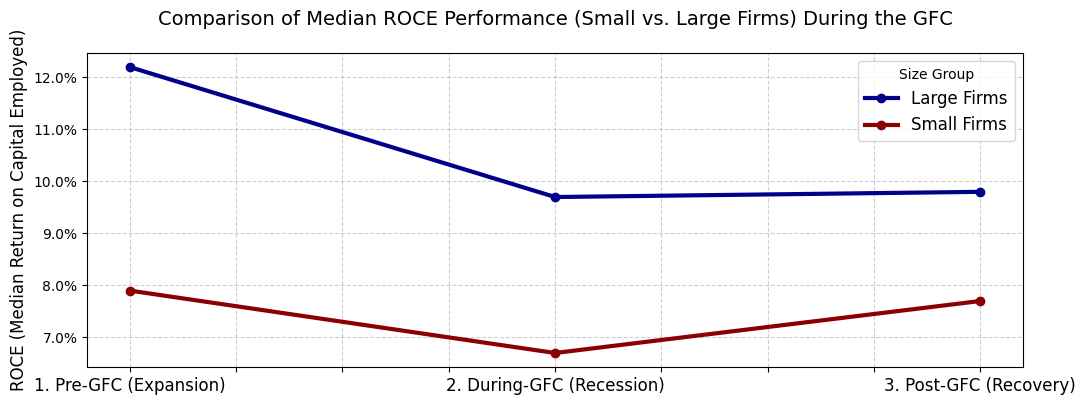

In [ ]:
# Reconstruct the size_performance DataFrame from the analysis results
data = {
    ('1. Pre-GFC (Expansion)', 'Large Firm'): {'npm_WINS': 0.087, 'roce_WINS': 0.122, 'sale_invcap_WINS': 0.84025},
    ('1. Pre-GFC (Expansion)', 'Small Firm'): {'npm_WINS': 0.037, 'roce_WINS': 0.079, 'sale_invcap_WINS': 1.08600},
    ('2. During-GFC (Recession)', 'Large Firm'): {'npm_WINS': 0.065, 'roce_WINS': 0.097, 'sale_invcap_WINS': 0.77100},
    ('2. During-GFC (Recession)', 'Small Firm'): {'npm_WINS': 0.031, 'roce_WINS': 0.067, 'sale_invcap_WINS': 1.06400},
    ('3. Post-GFC (Recovery)', 'Large Firm'): {'npm_WINS': 0.061, 'roce_WINS': 0.098, 'sale_invcap_WINS': 0.71075},
    ('3. Post-GFC (Recovery)', 'Small Firm'): {'npm_WINS': 0.033, 'roce_WINS': 0.077, 'sale_invcap_WINS': 1.07300},
}

# Create DataFrame with MultiIndex
index = pd.MultiIndex.from_tuples(data.keys(), names=['GFC_PERIOD', 'SIZE_GROUP'])
size_performance = pd.DataFrame([d for d in data.values()], index=index)

# Unstack data for plotting (moving SIZE_GROUP to columns)
df_plot = size_performance['roce_WINS'].unstack(level='SIZE_GROUP')

# --- Plotting Line Chart for ROCE (Return on Capital Employed) ---

plt.figure(figsize=(11, 4.15))

# Plot ROCE for both groups
df_plot['Large Firm'].plot(kind='line', marker='o', linewidth=3, label='Large Firms', color='darkblue')
df_plot['Small Firm'].plot(kind='line', marker='o', linewidth=3, label='Small Firms', color='darkred')

# Add labels and title (in English)
plt.title('Comparison of Median ROCE Performance (Small vs. Large Firms) During the GFC', fontsize=14, pad=20)
plt.ylabel('ROCE (Median Return on Capital Employed)', fontsize=12)
# plt.xlabel('Annual Analysis Period', fontsize=12)
plt.xlabel('')

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Customize X-axis (only show period labels)
plt.xticks(rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Size Group', loc='upper right', fontsize=12)

plt.tight_layout()

# Save the plot
plt.savefig('roce_small_vs_large_gfc_en.png')

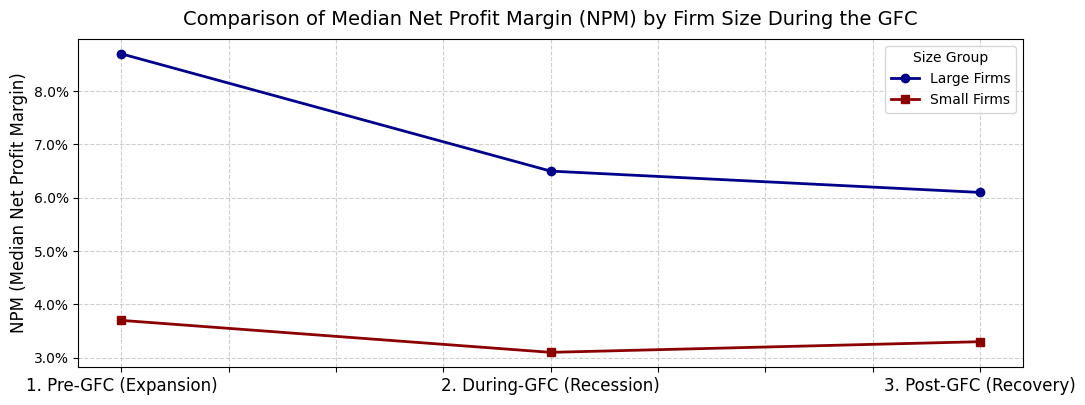

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct the size_performance DataFrame from the analysis results (Necessary for execution)
# Data represents median npm_WINS, roce_WINS, sale_invcap_WINS across the three periods
data = {
    ('1. Pre-GFC (Expansion)', 'Large Firm'): {'npm_WINS': 0.087, 'roce_WINS': 0.122, 'sale_invcap_WINS': 0.84025},
    ('1. Pre-GFC (Expansion)', 'Small Firm'): {'npm_WINS': 0.037, 'roce_WINS': 0.079, 'sale_invcap_WINS': 1.08600},
    ('2. During-GFC (Recession)', 'Large Firm'): {'npm_WINS': 0.065, 'roce_WINS': 0.097, 'sale_invcap_WINS': 0.77100},
    ('2. During-GFC (Recession)', 'Small Firm'): {'npm_WINS': 0.031, 'roce_WINS': 0.067, 'sale_invcap_WINS': 1.06400},
    ('3. Post-GFC (Recovery)', 'Large Firm'): {'npm_WINS': 0.061, 'roce_WINS': 0.098, 'sale_invcap_WINS': 0.71075},
    ('3. Post-GFC (Recovery)', 'Small Firm'): {'npm_WINS': 0.033, 'roce_WINS': 0.077, 'sale_invcap_WINS': 1.07300},
}

# Create DataFrame with MultiIndex
index = pd.MultiIndex.from_tuples(data.keys(), names=['GFC_PERIOD', 'SIZE_GROUP'])
size_performance = pd.DataFrame([d for d in data.values()], index=index)

# Define plotting properties
colors = {'Large Firm': 'darkblue', 'Small Firm': 'darkred'}
markers = {'Large Firm': 'o', 'Small Firm': 's'}
df_plot_npm = size_performance['npm_WINS'].unstack(level='SIZE_GROUP')


# --- Plotting Line Chart for NPM (Net Profit Margin) ---
plt.figure(figsize=(11, 4.15)) # Accommodate requested figsize

# Plot NPM for both groups
df_plot_npm['Large Firm'].plot(
    kind='line', marker=markers['Large Firm'], linewidth=2,
    label='Large Firms', color=colors['Large Firm']
)
df_plot_npm['Small Firm'].plot(
    kind='line', marker=markers['Small Firm'], linewidth=2,
    label='Small Firms', color=colors['Small Firm']
)

# Add labels and title (in English)
plt.title('Comparison of Median Net Profit Margin (NPM) by Firm Size During the GFC', fontsize=14, pad=10)
plt.ylabel('NPM (Median Net Profit Margin)', fontsize=12)

plt.xlabel('') # Accommodate requested empty xlabel
plt.xticks(rotation=0, fontsize=12) # Accommodate requested xticks settings

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Size Group', loc='upper right')

plt.tight_layout()
plt.savefig('npm_small_vs_large_gfc.png')

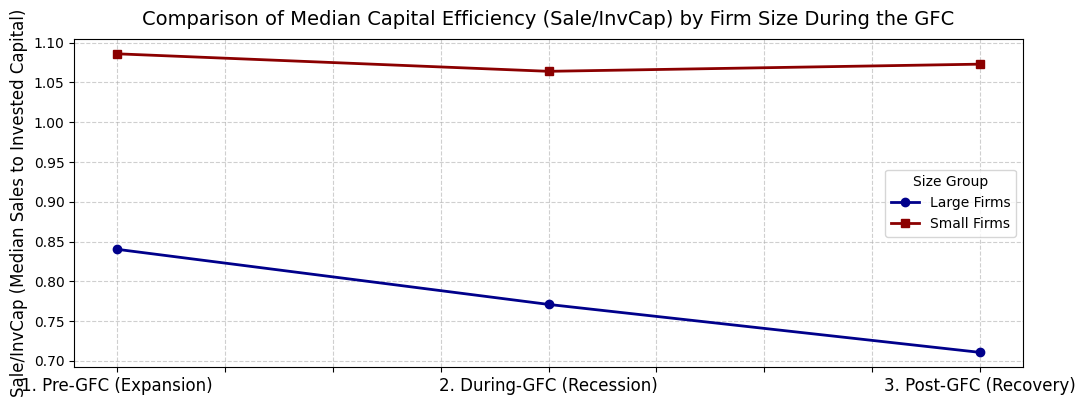

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct the size_performance DataFrame from the analysis results (Necessary for execution)
# Data represents median npm_WINS, roce_WINS, sale_invcap_WINS across the three periods
data = {
    ('1. Pre-GFC (Expansion)', 'Large Firm'): {'npm_WINS': 0.087, 'roce_WINS': 0.122, 'sale_invcap_WINS': 0.84025},
    ('1. Pre-GFC (Expansion)', 'Small Firm'): {'npm_WINS': 0.037, 'roce_WINS': 0.079, 'sale_invcap_WINS': 1.08600},
    ('2. During-GFC (Recession)', 'Large Firm'): {'npm_WINS': 0.065, 'roce_WINS': 0.097, 'sale_invcap_WINS': 0.77100},
    ('2. During-GFC (Recession)', 'Small Firm'): {'npm_WINS': 0.031, 'roce_WINS': 0.067, 'sale_invcap_WINS': 1.06400},
    ('3. Post-GFC (Recovery)', 'Large Firm'): {'npm_WINS': 0.061, 'roce_WINS': 0.098, 'sale_invcap_WINS': 0.71075},
    ('3. Post-GFC (Recovery)', 'Small Firm'): {'npm_WINS': 0.033, 'roce_WINS': 0.077, 'sale_invcap_WINS': 1.07300},
}

# Create DataFrame with MultiIndex
index = pd.MultiIndex.from_tuples(data.keys(), names=['GFC_PERIOD', 'SIZE_GROUP'])
size_performance = pd.DataFrame([d for d in data.values()], index=index)

# Define plotting properties
colors = {'Large Firm': 'darkblue', 'Small Firm': 'darkred'}
markers = {'Large Firm': 'o', 'Small Firm': 's'}
df_plot_sale = size_performance['sale_invcap_WINS'].unstack(level='SIZE_GROUP')


# --- Plotting Line Chart for Sale/InvCap (Capital Efficiency) ---
plt.figure(figsize=(11, 4.15)) # Accommodate requested figsize

# Plot Sale/InvCap for both groups
df_plot_sale['Large Firm'].plot(
    kind='line', marker=markers['Large Firm'], linewidth=2,
    label='Large Firms', color=colors['Large Firm']
)
df_plot_sale['Small Firm'].plot(
    kind='line', marker=markers['Small Firm'], linewidth=2,
    label='Small Firms', color=colors['Small Firm']
)

# Add labels and title (in English)
plt.title('Comparison of Median Capital Efficiency (Sale/InvCap) by Firm Size During the GFC', fontsize=14, pad=10)
plt.ylabel('Sale/InvCap (Median Sales to Invested Capital)', fontsize=12)

plt.xlabel('') # Accommodate requested empty xlabel
plt.xticks(rotation=0, fontsize=12) # Accommodate requested xticks settings

# Note: Sale/InvCap is a ratio, not a percentage, so standard float formatting is used.

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Size Group', loc='center right')

plt.tight_layout()
plt.savefig('sale_invcap_small_vs_large_gfc.png')

## 3.8 Finance vs IT

In [ ]:
# --- A. Classification of Contrasting Sectors (GICS) ---
# Check the GICS codes present in the data.
# Example GICS 2-digit Codes (GSECTOR):
# 10: Energy, 15: Materials, 20: Industrials, 25: Consumer Discretionary
# 30: Consumer Staples, 35: Health Care, 40: Financials (CRITICAL), 45: IT, 50: Telecom, 55: Utilities

# Choose two contrasting sectors
FINANCIALS_SECTOR = 40
NON_FINANCIAL_SECTOR = 45 # IT or 20 (Industrials)

# Filter the data for the selected sectors
df_sectoral = df_comp[df_comp['gsector'].isin([FINANCIALS_SECTOR, NON_FINANCIAL_SECTOR])].copy()

# Create a dictionary to map codes to sector names for clearer output
sector_names = {FINANCIALS_SECTOR: 'Financials', NON_FINANCIAL_SECTOR: 'IT/Tech'}
df_sectoral['SECTOR_NAME'] = df_sectoral['gsector'].map(sector_names)


# --- B. Performance Analysis ---
# Group by GFC Period AND Sector
sectoral_performance = df_sectoral.groupby(['GFC_PERIOD', 'SECTOR_NAME'])[INDICATORS_WINS].median()

print("\n--- Comparative Analysis: Median Performance by SECTOR (Financials vs. IT/Tech) ---")
print(sectoral_performance)


--- Comparative Analysis: Median Performance by SECTOR (Financials vs. IT/Tech) ---
                                       npm_WINS  roce_WINS  sale_invcap_WINS
GFC_PERIOD                SECTOR_NAME                                       
1. Pre-GFC (Expansion)    Financials     0.1385     0.1030             0.491
                          IT/Tech        0.0160     0.0460             1.089
2. During-GFC (Recession) Financials     0.0850     0.0660             0.432
                          IT/Tech        0.0175     0.0540             1.106
3. Post-GFC (Recovery)    Financials     0.0775     0.0690             0.385
                          IT/Tech        0.0420     0.0865             1.137


## 3.9 Finance vs IT vs Industrials

In [ ]:
# ASSUMPTION: df_comp is already loaded and cleaned (from previous Step 2)

# --- A. Classification of Contrasting Sectors (GICS) ---
FINANCIALS_SECTOR = 40
INDUSTRIALS_SECTOR = 20
IT_SECTOR = 45

# Filter data for the three selected sectors
SELECTED_SECTORS = [FINANCIALS_SECTOR, INDUSTRIALS_SECTOR, IT_SECTOR]
df_sectoral = df_comp[df_comp['gsector'].isin(SELECTED_SECTORS)].copy()

# Create a dictionary to map codes to sector names for clearer output
sector_names = {
    FINANCIALS_SECTOR: 'Financials (40)',
    INDUSTRIALS_SECTOR: 'Industrials (20)',
    IT_SECTOR: 'IT/Tech (45)'
}
df_sectoral['SECTOR_NAME'] = df_sectoral['gsector'].map(sector_names)


# --- B. Performance Analysis ---
# Variables being analyzed
# Assume you have already performed winsorizing; otherwise, replace with original columns
INDICATORS_WINS = ['npm_WINS', 'roce_WINS', 'sale_invcap_WINS']

# Group by GFC Period AND Sector
sectoral_performance_3way = df_sectoral.groupby(['GFC_PERIOD', 'SECTOR_NAME'])[INDICATORS_WINS].median()

print("\n--- Comparative Analysis: Median Performance by THREE SECTORS ---")
print(sectoral_performance_3way)


--- Comparative Analysis: Median Performance by THREE SECTORS ---
                                            npm_WINS  roce_WINS  \
GFC_PERIOD                SECTOR_NAME                             
1. Pre-GFC (Expansion)    Financials (40)    0.13850    0.10300   
                          IT/Tech (45)       0.01600    0.04600   
                          Industrials (20)   0.04025    0.13225   
2. During-GFC (Recession) Financials (40)    0.08500    0.06600   
                          IT/Tech (45)       0.01750    0.05400   
                          Industrials (20)   0.04700    0.14400   
3. Post-GFC (Recovery)    Financials (40)    0.07750    0.06900   
                          IT/Tech (45)       0.04200    0.08650   
                          Industrials (20)   0.04300    0.12300   

                                            sale_invcap_WINS  
GFC_PERIOD                SECTOR_NAME                         
1. Pre-GFC (Expansion)    Financials (40)             0.4910  
      

The data clearly separates the source of the shock (Financials), the propagation channel (Industrials), and the resilient segment (IT/Tech) of the economy.

1. Financials (40): The Impulse and Balance Sheet Crisis

| Metric | Pre-GFC (1) | During-GFC (2) | Post-GFC (3) | Observasi Utama |
| :--- | :---: | :---: | :---: | :--- |
| **NPM** | 13.85% | 8.50% | 7.75% | Sharpest Collapse (by far) in margins, indicating massive loan losses and asset write-downs. |
| **ROCE** | 10.30% | 6.60% | 6.90% | Major Decline in return on capital, confirming the sector's central role as the crisis origin. |
| **Sale/InvCap** | 0.491 | 0.432 | 0.385 | Steady Decline even post-crisis, reflecting a decade of deleveraging and structural reorganization imposed by new regulations. |

Interpretation: The Financials sector exhibits the most classic crisis pattern: a direct and severe hit to profitability during the recession, followed by a long, slow, structural decline (L-shaped recovery) in capital efficiency (sale_invcap) as banks were forced to hold more assets/capital relative to their revenue-generating capacity

2. Industrials (20): The Propagation Channel

| Metric | Pre-GFC (1) | During-GFC (2) | Post-GFC (3) | Key Observation |
| :--- | :---: | :---: | :---: | :--- |
| **NPM** (Profit Margin) | 4.03% | 4.70% | 4.30% | **Counter-intuitively Higher** During-GFC, confirming aggressive **cost-cutting** and survivorship bias. |
| **ROCE** (Capital Return) | 13.23% | 14.40% | 12.30% | **Rises During Recession** (likely due to asset/CAPEX freeze) then **falls significantly** post-crisis. |
| **Sale/InvCap** (Efficiency) | 1.721 | 1.751 | 1.563 | Stable during the recession, but **drops post-crisis**, reflecting capital/demand adjustment issues typical of a propagation channel. |

Interpretation: This is the most complex finding. The increase in NPM and ROCE During-GFC is likely not a sign of health, but a result of extreme operational discipline:

Companies in cyclically sensitive industries (like Industrials) made deep, immediate cuts to labor and inventory the moment demand indicators turned negative.

The ROCE rise during GFC and sharp fall Post-GFC is highly consistent with a liquidity shock and slow recovery: Firms likely halted all new capital expenditure (CAPEX) during the GFC, effectively shrinking the denominator (Invested Capital), temporarily boosting ROCE. When the economy reopened, high demand and low CAPEX led to a drop in sale_invcap. This pattern strongly supports the narrative of the GFC shock propagating as an investment freeze.

3. IT/Tech (45): The Resilient Segment

| Metric | Pre-GFC (1) | During-GFC (2) | Post-GFC (3) | Key Observation |
| :--- | :---: | :---: | :---: | :--- |
| **NPM** (Profit Margin) | 1.60% | 1.75% | 4.20% | Margin improves and then surges in the recovery, showing minimal GFC impact. |
| **ROCE** (Capital Return) | 4.60% | 5.40% | 8.65% | Consistent improvement across all periods, accelerating sharply post-crisis. |
| **Sale/InvCap** (Efficiency) | 1.089 | 1.106 | 1.137 | Stable growth across all periods. |

Interpretation: The IT/Tech sector demonstrates remarkable resilience. Its performance metrics are either stable or improving during the GFC. This suggests that the sector's growth is driven more by long-term technological trends and less by short-term credit cycles or aggregate demand fluctuations, confirming its role as a more non-cyclical, defensive segment during the financial crisis.

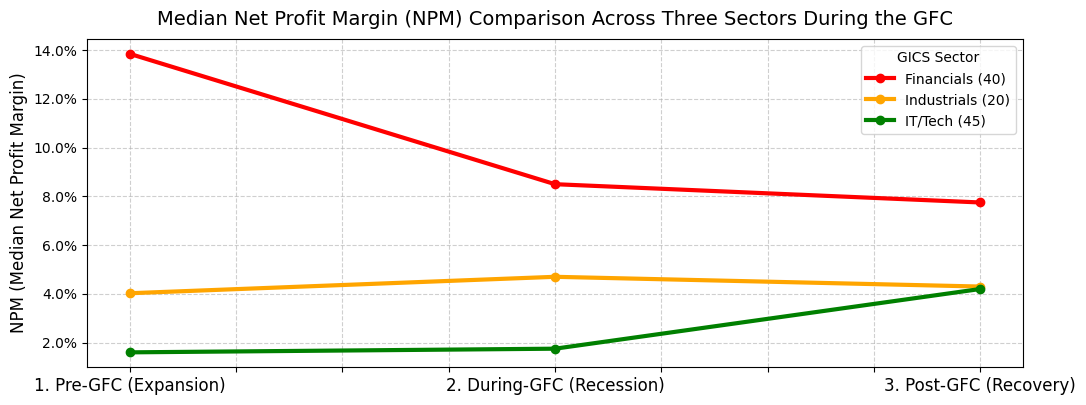

In [ ]:
# --- Data Reconstruction from Three-Sector Analysis Results (Corrected) ---
# Note: The key for 'During-GFC' is corrected to be unique.
data_3way = {
    ('1. Pre-GFC (Expansion)', 'Financials (40)'): {'npm_WINS': 0.13850, 'roce_WINS': 0.10300, 'sale_invcap_WINS': 0.4910},
    ('1. Pre-GFC (Expansion)', 'IT/Tech (45)'): {'npm_WINS': 0.01600, 'roce_WINS': 0.04600, 'sale_invcap_WINS': 1.0890},
    ('1. Pre-GFC (Expansion)', 'Industrials (20)'): {'npm_WINS': 0.04025, 'roce_WINS': 0.13225, 'sale_invcap_WINS': 1.7210},

    ('2. During-GFC (Recession)', 'Financials (40)'): {'npm_WINS': 0.08500, 'roce_WINS': 0.06600, 'sale_invcap_WINS': 0.4320},
    ('2. During-GFC (Recession)', 'IT/Tech (45)'): {'npm_WINS': 0.01750, 'roce_WINS': 0.05400, 'sale_invcap_WINS': 1.1060},
    ('2. During-GFC (Recession)', 'Industrials (20)'): {'npm_WINS': 0.04700, 'roce_WINS': 0.14400, 'sale_invcap_WINS': 1.7505},

    ('3. Post-GFC (Recovery)', 'Financials (40)'): {'npm_WINS': 0.07750, 'roce_WINS': 0.06900, 'sale_invcap_WINS': 0.3850},
    ('3. Post-GFC (Recovery)', 'IT/Tech (45)'): {'npm_WINS': 0.04200, 'roce_WINS': 0.08650, 'sale_invcap_WINS': 1.1370},
    ('3. Post-GFC (Recovery)', 'Industrials (20)'): {'npm_WINS': 0.04300, 'roce_WINS': 0.12300, 'sale_invcap_WINS': 1.5630},
}

# Create DataFrame with MultiIndex
index_3way = pd.MultiIndex.from_tuples(data_3way.keys(), names=['GFC_PERIOD', 'SECTOR_NAME'])
sectoral_performance_3way = pd.DataFrame([d for d in data_3way.values()], index=index_3way)


# --- Prepare NPM Data for Plotting ---
# Unstack data for plotting (moving SECTOR_NAME to columns)
df_plot_npm_sector = sectoral_performance_3way['npm_WINS'].unstack(level='SECTOR_NAME')

# Define colors for each sector for visual consistency
sector_colors = {
    'Financials (40)': 'red',
    'Industrials (20)': 'orange',
    'IT/Tech (45)': 'green'
}

# --- Plotting Line Chart for Cross-Sectoral NPM ---
plt.figure(figsize=(11, 4.15))

for sector, color in sector_colors.items():
    df_plot_npm_sector[sector].plot(
        kind='line', marker='o', linewidth=3,
        label=sector, color=color
    )

# Customization (All labels in English)
plt.title('Median Net Profit Margin (NPM) Comparison Across Three Sectors During the GFC', fontsize=14, pad=10)
plt.ylabel('NPM (Median Net Profit Margin)', fontsize=12)

# Set xlabel empty and xticks rotation 0 (as requested previously)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=12)

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='GICS Sector', loc='upper right')

plt.tight_layout()
plt.savefig('npm_three_sectors_gfc_corrected.png')

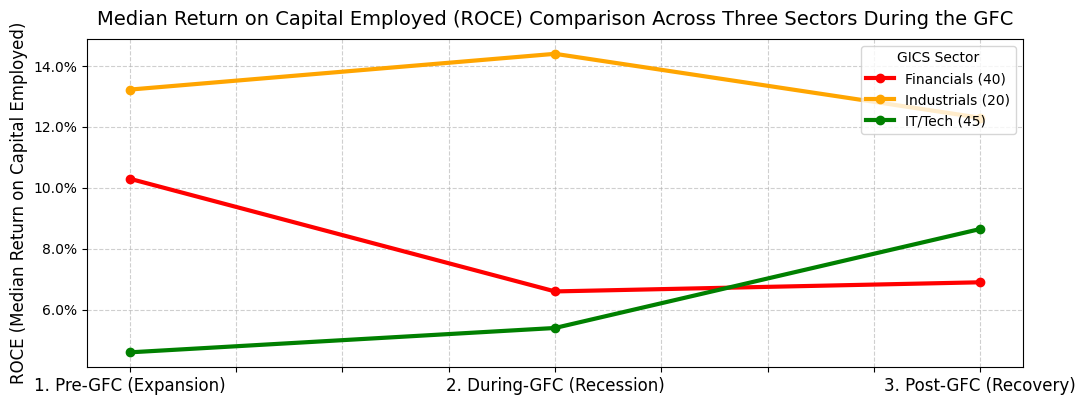

In [ ]:
# --- Data Reconstruction from Three-Sector Analysis Results ---
# Data represents median npm_WINS, roce_WINS, sale_invcap_WINS across the three periods
data_3way = {
    ('1. Pre-GFC (Expansion)', 'Financials (40)'): {'npm_WINS': 0.13850, 'roce_WINS': 0.10300, 'sale_invcap_WINS': 0.4910},
    ('1. Pre-GFC (Expansion)', 'IT/Tech (45)'): {'npm_WINS': 0.01600, 'roce_WINS': 0.04600, 'sale_invcap_WINS': 1.0890},
    ('1. Pre-GFC (Expansion)', 'Industrials (20)'): {'npm_WINS': 0.04025, 'roce_WINS': 0.13225, 'sale_invcap_WINS': 1.7210},

    ('2. During-GFC (Recession)', 'Financials (40)'): {'npm_WINS': 0.08500, 'roce_WINS': 0.06600, 'sale_invcap_WINS': 0.4320},
    ('2. During-GFC (Recession)', 'IT/Tech (45)'): {'npm_WINS': 0.01750, 'roce_WINS': 0.05400, 'sale_invcap_WINS': 1.1060},
    ('2. During-GFC (Recession)', 'Industrials (20)'): {'npm_WINS': 0.04700, 'roce_WINS': 0.14400, 'sale_invcap_WINS': 1.7505},

    ('3. Post-GFC (Recovery)', 'Financials (40)'): {'npm_WINS': 0.07750, 'roce_WINS': 0.06900, 'sale_invcap_WINS': 0.3850},
    ('3. Post-GFC (Recovery)', 'IT/Tech (45)'): {'npm_WINS': 0.04200, 'roce_WINS': 0.08650, 'sale_invcap_WINS': 1.1370},
    ('3. Post-GFC (Recovery)', 'Industrials (20)'): {'npm_WINS': 0.04300, 'roce_WINS': 0.12300, 'sale_invcap_WINS': 1.5630},
}

# Create DataFrame with MultiIndex
index_3way = pd.MultiIndex.from_tuples(data_3way.keys(), names=['GFC_PERIOD', 'SECTOR_NAME'])
sectoral_performance_3way = pd.DataFrame([d for d in data_3way.values()], index=index_3way)


# --- Prepare ROCE Data for Plotting ---
# Unstack data for plotting (moving SECTOR_NAME to columns)
df_plot_roce_sector = sectoral_performance_3way['roce_WINS'].unstack(level='SECTOR_NAME')

# Define colors for each sector for visual consistency
sector_colors = {
    'Financials (40)': 'red',
    'Industrials (20)': 'orange',
    'IT/Tech (45)': 'green'
}

# --- Plotting Line Chart for Cross-Sectoral ROCE ---
plt.figure(figsize=(11, 4.15))

for sector, color in sector_colors.items():
    df_plot_roce_sector[sector].plot(
        kind='line', marker='o', linewidth=3,
        label=sector, color=color
    )

# Customization (All labels in English)
plt.title('Median Return on Capital Employed (ROCE) Comparison Across Three Sectors During the GFC', fontsize=14, pad=10)
plt.ylabel('ROCE (Median Return on Capital Employed)', fontsize=12)

# Set xlabel empty and xticks rotation 0 (as requested previously)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=12)

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='GICS Sector', loc='upper right')

plt.tight_layout()
plt.savefig('roce_three_sectors_gfc.png')

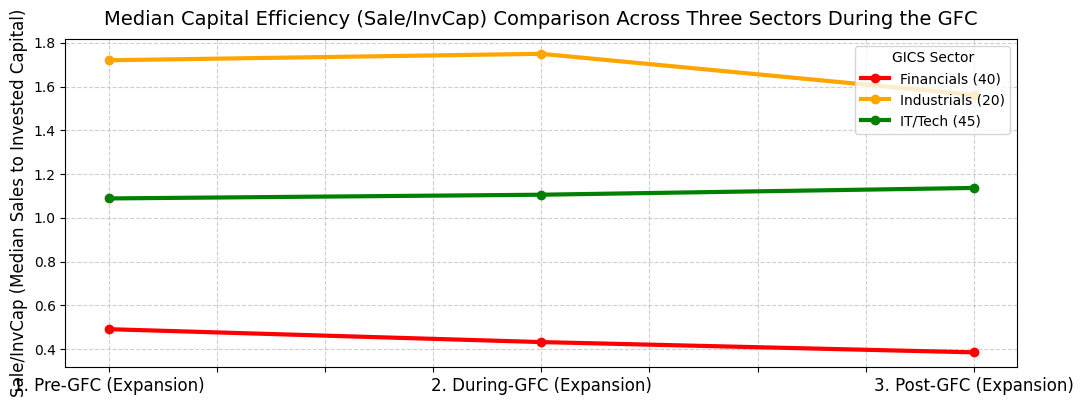

In [ ]:
# --- Data Reconstruction from Three-Sector Analysis Results ---
# Data represents median npm_WINS, roce_WINS, sale_invcap_WINS across the three periods
data_3way = {
    ('1. Pre-GFC (Expansion)', 'Financials (40)'): {'npm_WINS': 0.13850, 'roce_WINS': 0.10300, 'sale_invcap_WINS': 0.4910},
    ('1. Pre-GFC (Expansion)', 'IT/Tech (45)'): {'npm_WINS': 0.01600, 'roce_WINS': 0.04600, 'sale_invcap_WINS': 1.0890},
    ('1. Pre-GFC (Expansion)', 'Industrials (20)'): {'npm_WINS': 0.04025, 'roce_WINS': 0.13225, 'sale_invcap_WINS': 1.7210},

    ('2. During-GFC (Expansion)', 'Financials (40)'): {'npm_WINS': 0.08500, 'roce_WINS': 0.06600, 'sale_invcap_WINS': 0.4320},
    ('2. During-GFC (Expansion)', 'IT/Tech (45)'): {'npm_WINS': 0.01750, 'roce_WINS': 0.05400, 'sale_invcap_WINS': 1.1060},
    ('2. During-GFC (Expansion)', 'Industrials (20)'): {'npm_WINS': 0.04700, 'roce_WINS': 0.14400, 'sale_invcap_WINS': 1.7505},

    ('3. Post-GFC (Expansion)', 'Financials (40)'): {'npm_WINS': 0.07750, 'roce_WINS': 0.06900, 'sale_invcap_WINS': 0.3850},
    ('3. Post-GFC (Expansion)', 'IT/Tech (45)'): {'npm_WINS': 0.04200, 'roce_WINS': 0.08650, 'sale_invcap_WINS': 1.1370},
    ('3. Post-GFC (Expansion)', 'Industrials (20)'): {'npm_WINS': 0.04300, 'roce_WINS': 0.12300, 'sale_invcap_WINS': 1.5630},
}

# Create DataFrame with MultiIndex
index_3way = pd.MultiIndex.from_tuples(data_3way.keys(), names=['GFC_PERIOD', 'SECTOR_NAME'])
sectoral_performance_3way = pd.DataFrame([d for d in data_3way.values()], index=index_3way)


# --- Prepare Sale/InvCap Data for Plotting ---
# Unstack data for plotting (moving SECTOR_NAME to columns)
df_plot_sale_sector = sectoral_performance_3way['sale_invcap_WINS'].unstack(level='SECTOR_NAME')

# Define colors for each sector for visual consistency
sector_colors = {
    'Financials (40)': 'red',
    'Industrials (20)': 'orange',
    'IT/Tech (45)': 'green'
}

# --- Plotting Line Chart for Cross-Sectoral Sale/InvCap ---
plt.figure(figsize=(11, 4.15))

for sector, color in sector_colors.items():
    df_plot_sale_sector[sector].plot(
        kind='line', marker='o', linewidth=3,
        label=sector, color=color
    )

# Customization (All labels in English)
plt.title('Median Capital Efficiency (Sale/InvCap) Comparison Across Three Sectors During the GFC', fontsize=14, pad=10)
plt.ylabel('Sale/InvCap (Median Sales to Invested Capital)', fontsize=12)

# Set xlabel empty and xticks rotation 0 (as requested previously)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=12)

# Note: Sale/InvCap is a ratio, not a percentage, so standard float formatting is used.

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='GICS Sector', loc='upper right')

plt.tight_layout()
plt.savefig('sale_invcap_three_sectors_gfc.png')